In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS, BRAIN_AREAS

epoch_key = ('bon', 3, 2)

In [4]:
import itertools
from src.load_data import load_data

speed_metric='linear_speed'

data_types = set(itertools.chain(*USE_LIKELIHOODS.values()))
data = load_data(epoch_key, ANIMALS, SAMPLING_FREQUENCY, data_types,
                 BRAIN_AREAS, speed_metric)

INFO:src.load_data:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)
INFO:src.load_data:Finding ripple times...


In [73]:
from replay_identification import ReplayDetector

position_metric = 'linear_distance'

replay_detector = ReplayDetector(lfp_model_kwargs={'n_components': 3})
replay_detector.fit(
    is_replay=data['is_ripple'], speed=data['position_info'].linear_speed,
    position=data['position_info'][position_metric],
    lfp_power=data['power'], spikes=None,
    multiunit=data['multiunit'])

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


In [74]:
from src.summarize_replay import (add_epoch_info_to_dataframe, compare_overlap,
                                  decode_replays, get_replay_times,
                                  summarize_replays)

likelihoods = ['lfp_power']
data_source = 'lfp_power'

detector_results = replay_detector.predict(
    speed=data['position_info'].linear_speed,
    position=data['position_info'][position_metric],
    lfp_power=data['power'],
    spikes=data['spikes'], multiunit=data['multiunit'],
    time=data['position_info'].index,
    use_likelihoods=likelihoods)

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


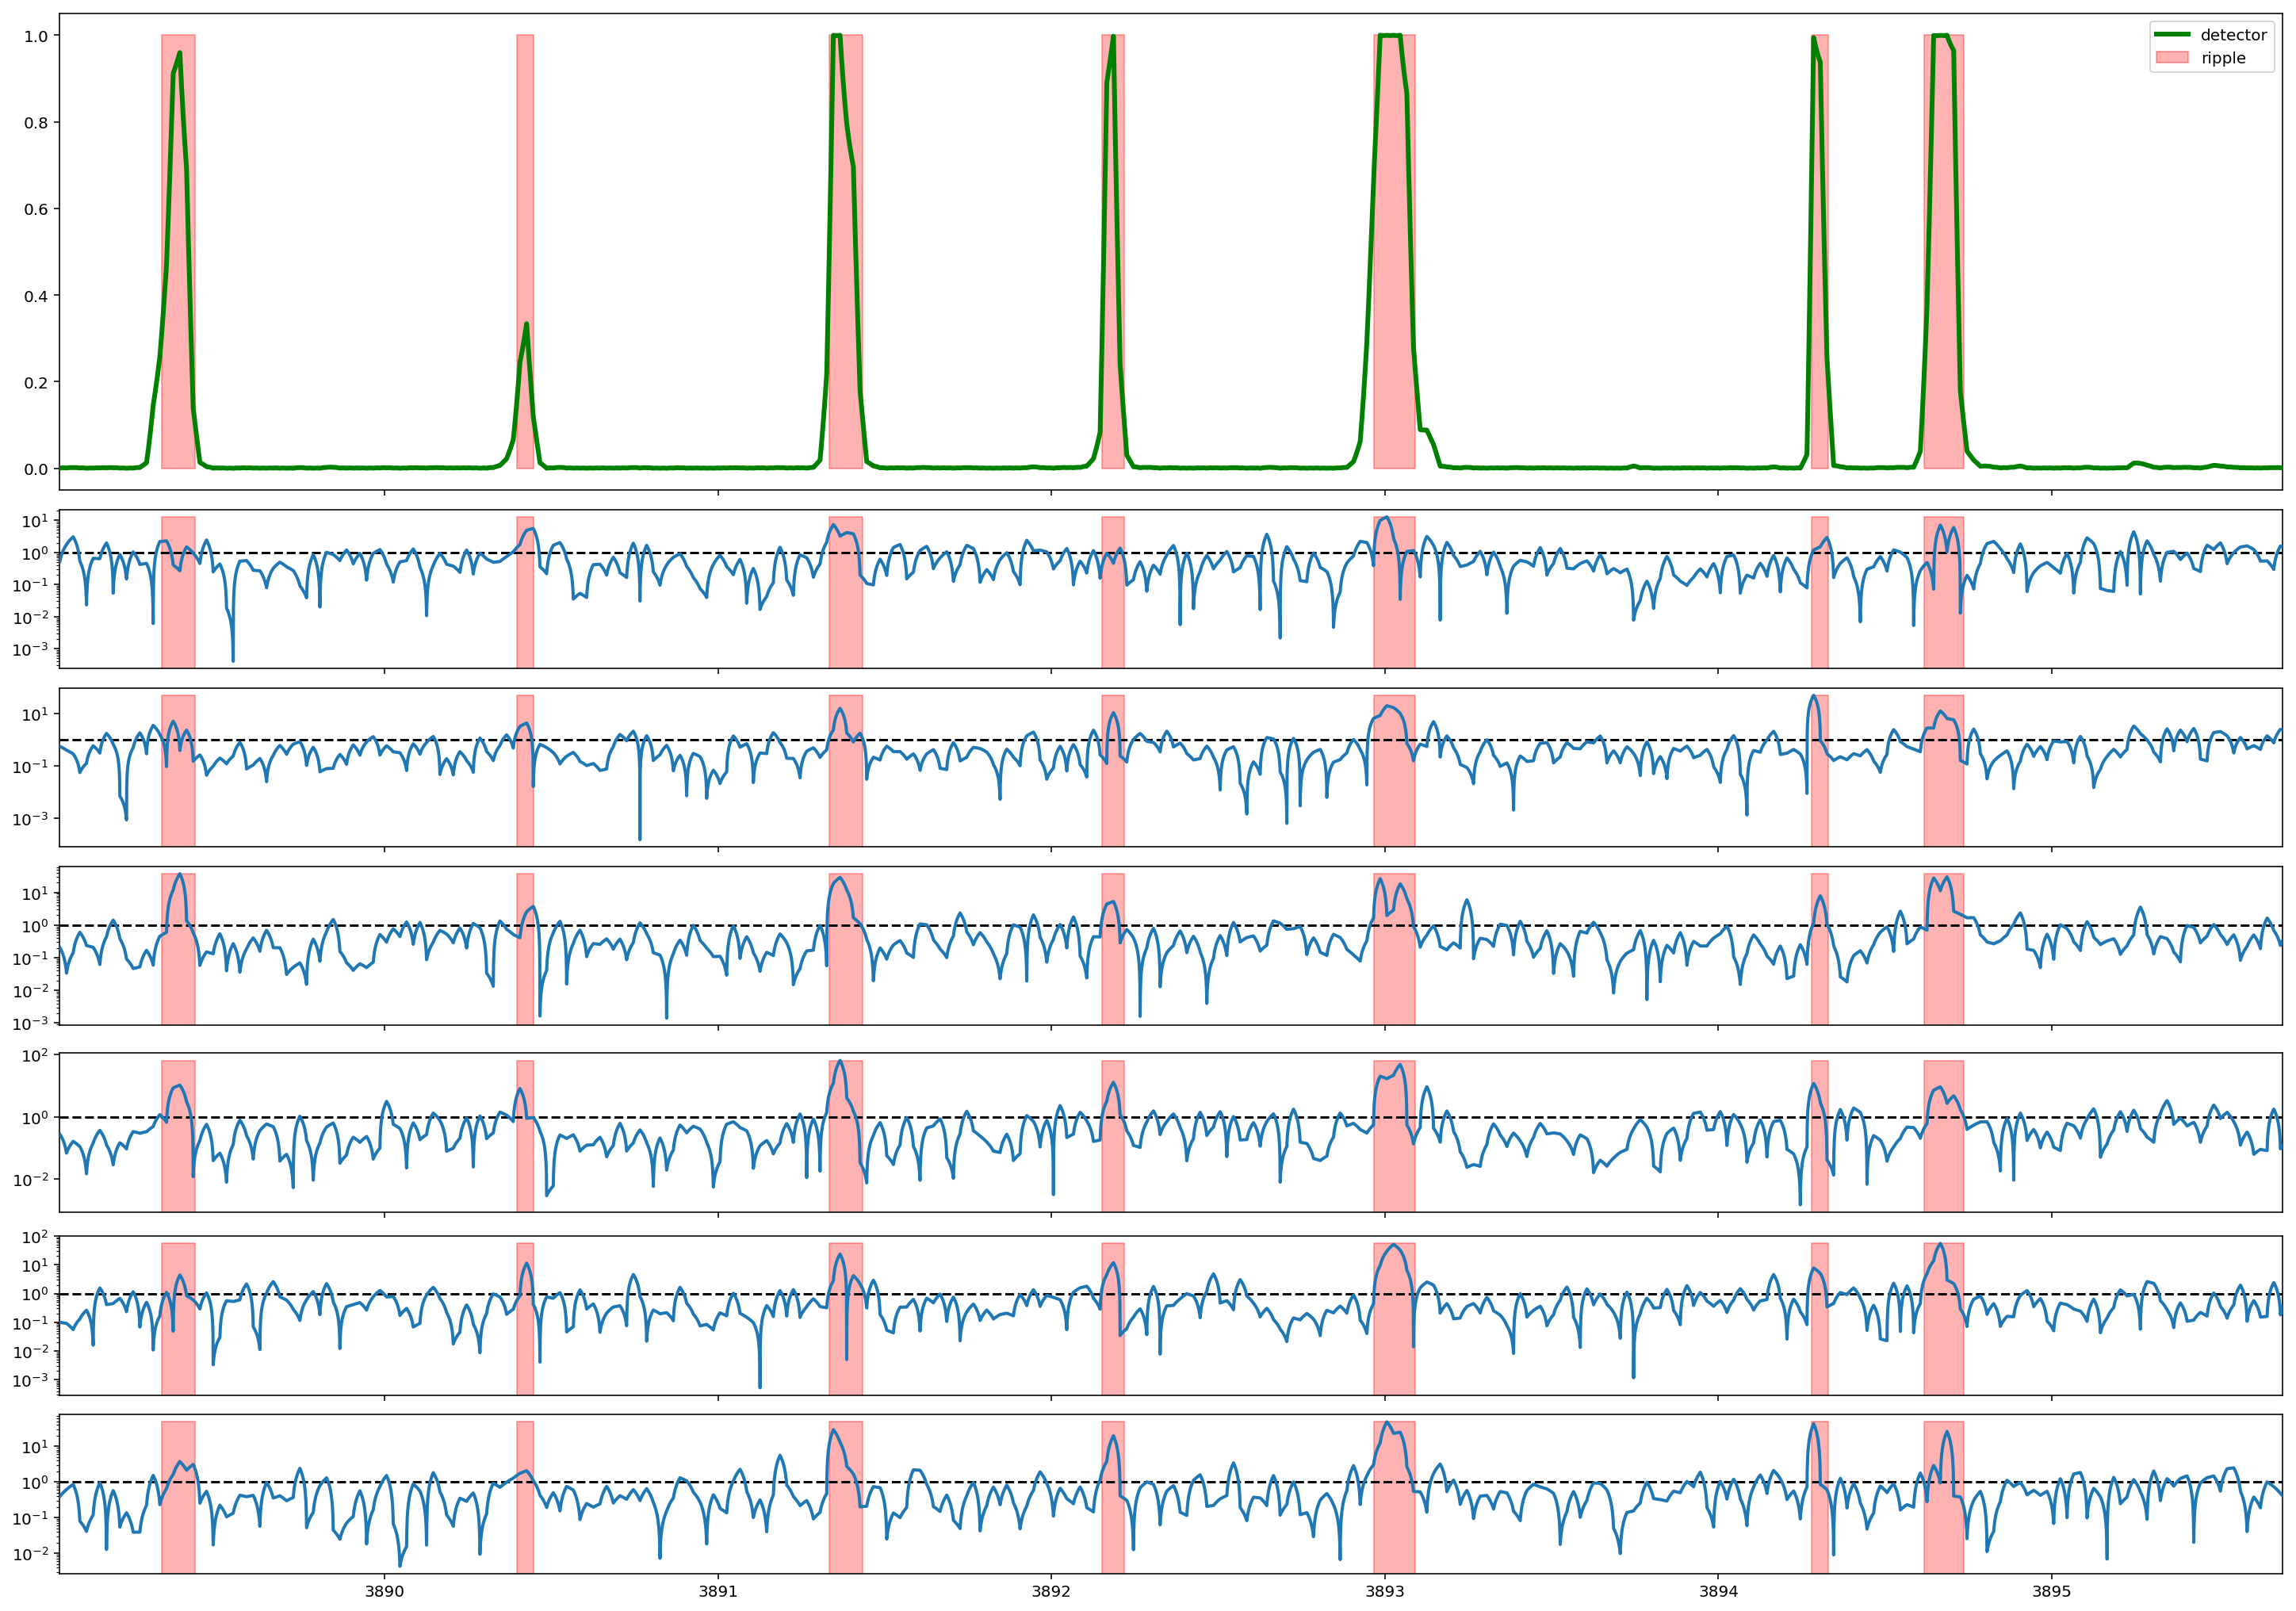

In [92]:
ind = slice(240000, 250000)
power = data['power'].interpolate() / data['power'].mean()
is_ripple = data['is_ripple'].values.squeeze()

n_lfps = power.shape[1]

time = detector_results.time / np.timedelta64(1, 's')

height_ratios = np.ones((n_lfps + 1,))
height_ratios[0] = 3
gridspec_kw = {'height_ratios': height_ratios}

fig, axes = plt.subplots(n_lfps + 1, 1, figsize=(20, (n_lfps + 1) * 2), sharex=True,
                         constrained_layout=True, gridspec_kw=gridspec_kw)

axes[0].fill_between(time[ind], 0, is_ripple[ind],
                     color='red', where=is_ripple[ind],
                     alpha=0.3, label='ripple', zorder=1)
axes[0].plot(time[ind], detector_results.replay_probability[ind],
             color='green', label='detector', linewidth=3, zorder=100)
axes[0].legend()

for lfp_ind in np.arange(n_lfps):
    axes[lfp_ind + 1].fill_between(time[ind], 0, is_ripple[ind] * power.values[ind, lfp_ind].max(),
                 color='red', where=is_ripple[ind], alpha=0.3)
    axes[lfp_ind + 1].semilogy(time[ind], power.values[ind, lfp_ind],
                               zorder=100, linewidth=2)
    axes[lfp_ind + 1].axhline(1, linestyle='--', color='black')

plt.xlim((time[ind].min(), time[ind].max()));

In [7]:
replay_info, is_replay = get_replay_times(detector_results)
replay_info = add_epoch_info_to_dataframe(replay_info, epoch_key, data_source)
decoder_results, replay_decoder = decode_replays(
    data, replay_detector, is_replay, replay_info,
    SAMPLING_FREQUENCY, position_metric)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


In [8]:
replay_info, replay_densities = summarize_replays(
    replay_info, detector_results, decoder_results, data, position_metric)

In [9]:
from ipywidgets import interact

number_range = (0, len(replay_info))

@interact(replay_number=number_range, continuous_update=False)
def plot_replay(replay_number):
    r = (replay_densities
         .isel(replay_id=replay_number)
         .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
         .dropna('time'))
    # Detector
    g = r.detector_posterior.plot(x='time', y='position', robust=True)
    
    COLUMNS = ['replay_type', 'replay_type_confidence',
               'replay_movement_distance', 'replay_motion_type', 'replay_motion_slope',
              'linear_distance']
    info = (replay_info.iloc[replay_number].loc[COLUMNS])
    g.axes.axhline(info.linear_distance,
                   color='white', linestyle='--',
                   linewidth=3, alpha=0.8)
    
    g = (r.decoder_posterior
          .plot(x='time', y='position', col='state', col_wrap=2,
                robust=True))
    for ax in g.axes.ravel().tolist():
        ax.axhline(info.linear_distance,
                   color='white', linestyle='--',
                   linewidth=3, alpha=0.8)
    
    display(info)

interactive(children=(IntSlider(value=164, description='replay_number', max=328), Output()), _dom_classes=('wi…

(32, 6, 187)


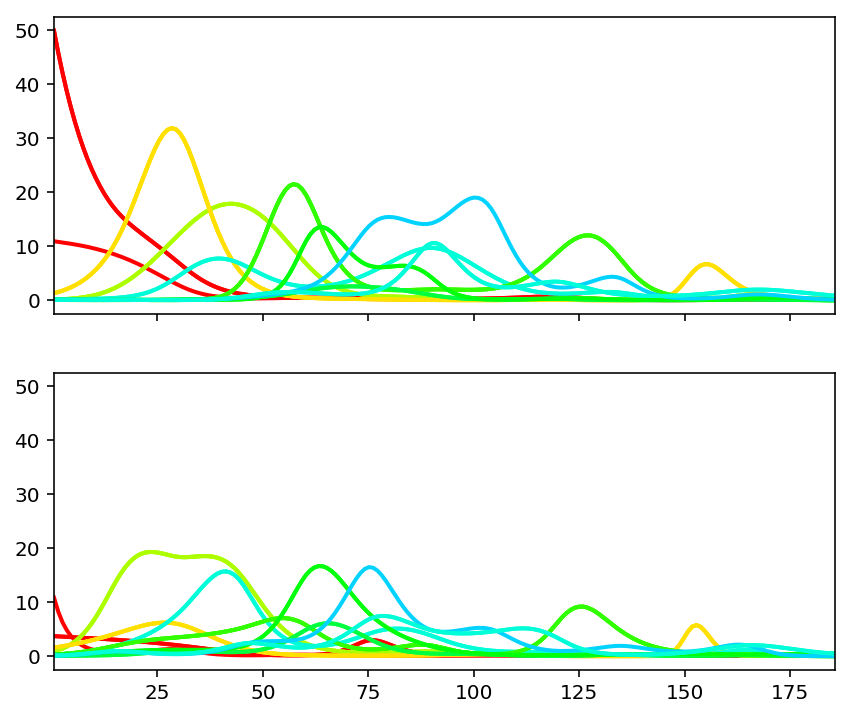

In [134]:
ci = replay_decoder.combined_likelihood_kwargs_['likelihood_kwargs']['conditional_intensity'].squeeze()
place_bin_centers = replay_decoder.place_bin_centers
s = decoder_results[201].spikes
cmap = plt.get_cmap('hsv')
place_colors = cmap(np.linspace(0.0, 1.0, place_bin_centers.size))

# Decoded Distance
time_ind, spike_ind = np.nonzero(s)

# n_states = ci.shape[1]
n_states = 2
fig, axes = plt.subplots(n_states, 1, figsize=(7, n_states * 3), sharex=True, sharey=True)

for state_ind, ax in enumerate(axes.flat):
    for ind, color in zip(spike_ind, place_colors[place_field_ind[spike_ind]]):
        ax.plot(place_bin_centers, ci[ind, state_ind, :].T * SAMPLING_FREQUENCY, color=color, linewidth=2)
        
plt.xlim((place_bin_centers.min(), place_bin_centers.max()))


print(ci.shape)

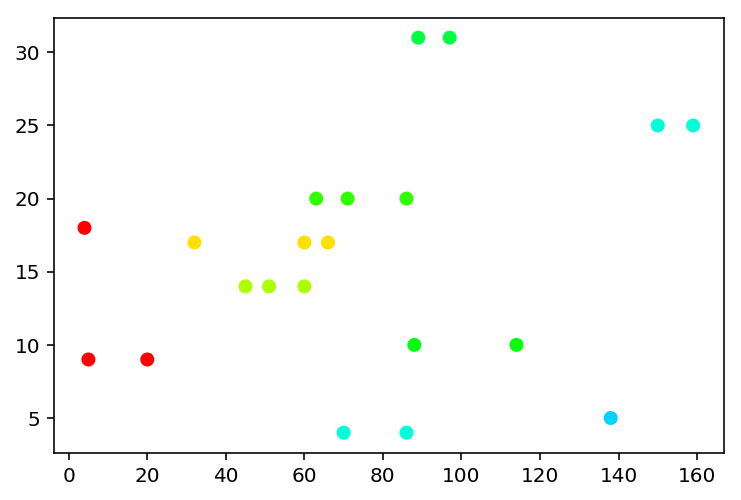

In [158]:
# Spiking ordered by place fields
place_field_ind = np.argmax(ci[:, 0, :], axis=1)
ordered_place_field_ind = np.argsort(place_field_ind)

time_ind, spike_ind = np.nonzero(s)
plt.scatter(time_ind, ordered_place_field_ind[spike_ind], c=place_colors[place_field_ind[spike_ind]])


(-0.06, 0.104666667)

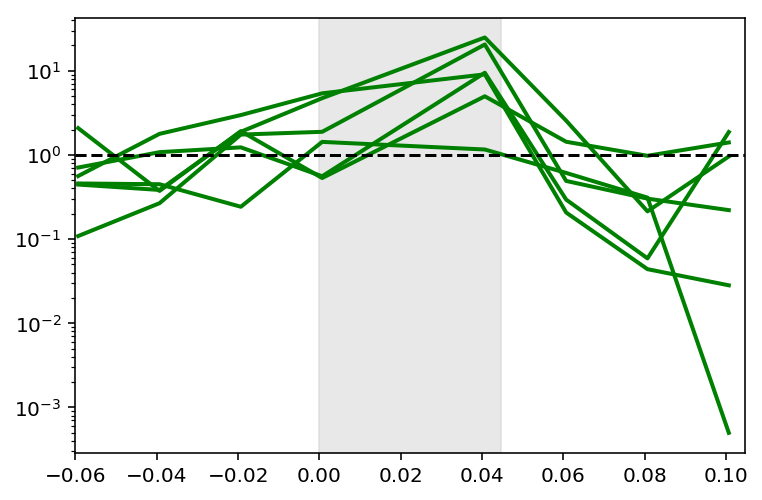

In [386]:
blah = replay_info.loc[:, ['start_time', 'end_time']]
blah.end_time += pd.Timedelta(0.06, 's')

power_change_by_replay = reshape_to_segments(
    data['power'], blah,
    window_offset=(-0.060, None)
) / data['power'].mean()

p = power_change_by_replay.loc['bon_03_02_021_lfp_power']

plt.semilogy(p.dropna().index.total_seconds(), p.dropna(),
             linewidth=2, color='green')
plt.axhline(1, color='black', linestyle='--')
plt.axvspan(0, p.index.total_seconds().max()-0.06, color='lightgrey', zorder=-100, alpha=0.5)
plt.xlim((-0.06, p.index.total_seconds().max()))

## Save Code

In [71]:
from loren_frank_data_processing import save_xarray
from src.parameters import PROCESSED_DATA_DIR

def save_replay_data(name, epoch_key, replay_info, replay_densities,
                     is_replay):
    save_xarray(PROCESSED_DATA_DIR, epoch_key, replay_densities,
                f'{name}/replay_densities')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                replay_info.reset_index().to_xarray(), f'{name}/replay_info')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                is_replay.reset_index().to_xarray(), f'{name}/is_replay')

save_replay_data(name, epoch_key, replay_info, replay_densities,
                     is_replay)

In [72]:
def save_ripple_data(epoch_key, data):
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                data['ripple_labels'].reset_index().to_xarray(),
                '/ripple_labels')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                data['ripple_times'].reset_index().to_xarray(),
                '/ripple_times')
    
save_ripple_data(epoch_key, data)

In [73]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='lfp_power/replay_densities')

<xarray.Dataset>
Dimensions:              (position: 187, replay_number: 162, state: 4, time: 640)
Coordinates:
  * time                 (time) timedelta64[ns] 00:00:00 ... 00:00:00.319333
  * position             (position) float64 0.4979 1.494 2.489 ... 184.7 185.7
  * replay_number        (replay_number) int64 1 2 3 4 5 ... 158 159 160 161 162
  * state                (state) object 'Outbound-Forward' ... 'Inbound-Reverse'
Data variables:
    detector_posterior   (replay_number, time, position) float64 ...
    detector_likelihood  (replay_number, time) float64 ...
    decoder_posterior    (replay_number, time, state, position) float64 ...

In [74]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='lfp_power/replay_info').to_dataframe().head()

replay_number      start_time        end_time        duration  \
index                                                                  
0                  1 01:02:22.825700 01:02:22.985033 00:00:00.159333   
1                  2 01:02:27.105700 01:02:27.285033 00:00:00.179333   
2                  3 01:02:35.965700 01:02:36.025033 00:00:00.059333   
3                  4 01:02:38.145700 01:02:38.245033 00:00:00.099333   
4                  5 01:03:29.205700 01:03:29.327033 00:00:00.121333   

       max_probability  track_segment_id    arm_name  labeled_segments  \
index                                                                    
0             0.999791               0.0  Center Arm               0.0   
1             1.000000               0.0  Center Arm               0.0   
2             0.821428               0.0  Center Arm               0.0   
3             0.999719               0.0  Center Arm               0.0   
4             0.999992               4.0   Right Arm               0.0   

      from_well to_well           ...           linear_velocity  linear_speed  \
index                             ...                                           
0                                 ...                 -0.117607      0.117607   
1                                 ...                  0.070066      0.070066   
2                                 ...                  0.152085      0.152085   
3                                 ...                 -0.000982      0.000982   
4                                 ...                  0.185453      0.185453   

      linear_position  linear_position2       replay_type  \
index                                                       
0                 NaN          0.007226  Outbound-Reverse   
1                 NaN          4.950396  Outbound-Reverse   
2                 NaN          0.000000  Outbound-Reverse   
3                 NaN          0.000000      Unclassified   
4                 NaN        176.714710   Inbound-Forward   

       replay_type_confidence  replay_motion_slope  replay_motion_type  \
index                                                                    
0                    0.999423            23.823095             Neither   
1                    0.996762            17.790905             Neither   
2                    0.964020            10.755449             Neither   
3                         NaN            63.751878                Away   
4                    0.986575         -1099.419315             Towards   

       replay_movement_distance  credible_interval_size  
index                                                    
0                      0.000000                0.018092  
1                      0.000000                0.018210  
2                      0.000000                0.016335  
3                      0.000000                0.016686  
4                     99.321617                0.011563  

[5 rows x 28 columns]

In [75]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='lfp_power/is_replay').to_dataframe().head()

time  replay_number  replay_probability
index                                                   
0     01:02:09.025700              0                 0.0
1     01:02:09.026366              0                 0.0
2     01:02:09.027033              0                 0.0
3     01:02:09.027700              0                 0.0
4     01:02:09.028366              0                 0.0

In [76]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='ripple_labels').to_dataframe().head()

ripple_number
index                         
01:02:09.025700              0
01:02:09.026366              0
01:02:09.027033              0
01:02:09.027700              0
01:02:09.028366              0

In [77]:
xr.open_dataset('../Processed-Data/bon_03_02.nc', group='/ripple_times').to_dataframe().head()

ripple_number      start_time        end_time
index                                               
0                  1 01:02:20.175033 01:02:20.281700
1                  2 01:02:22.785700 01:02:22.904366
2                  3 01:02:27.075700 01:02:27.181700
3                  4 01:02:29.244366 01:02:29.301033
4                  5 01:02:34.055033 01:02:34.112366

## Overlap

In [78]:
from ipywidgets import interact

time = data['ripple_labels'].index.total_seconds()
segment_length = 30

@interact(t=(0, time.max()-10, segment_length))
def plot_overlap(t):
    time = data['ripple_labels'].index.total_seconds()
    m = time.min() + t
    is_time = (time > m) & (time < (m + segment_length))

    plt.figure(figsize=(15, 5))
    plt.fill_betweenx(data['ripple_labels'][is_time] > 0, time[is_time], alpha=0.6, label='ripple')
    
    time = is_replay.index.total_seconds()
    m = time.min() + t
    is_time = (time > m) & (time < m + segment_length)
    plt.fill_betweenx((is_replay.replay_number > 0)[is_time], time[is_time], alpha=0.6, label='lfp')

    plt.xlim((m, m + segment_length));
    plt.ylim((0, 1))
    plt.legend();

interactive(children=(FloatSlider(value=2310.0, description='t', max=4650.018366667, step=30.0), Output()), _d…

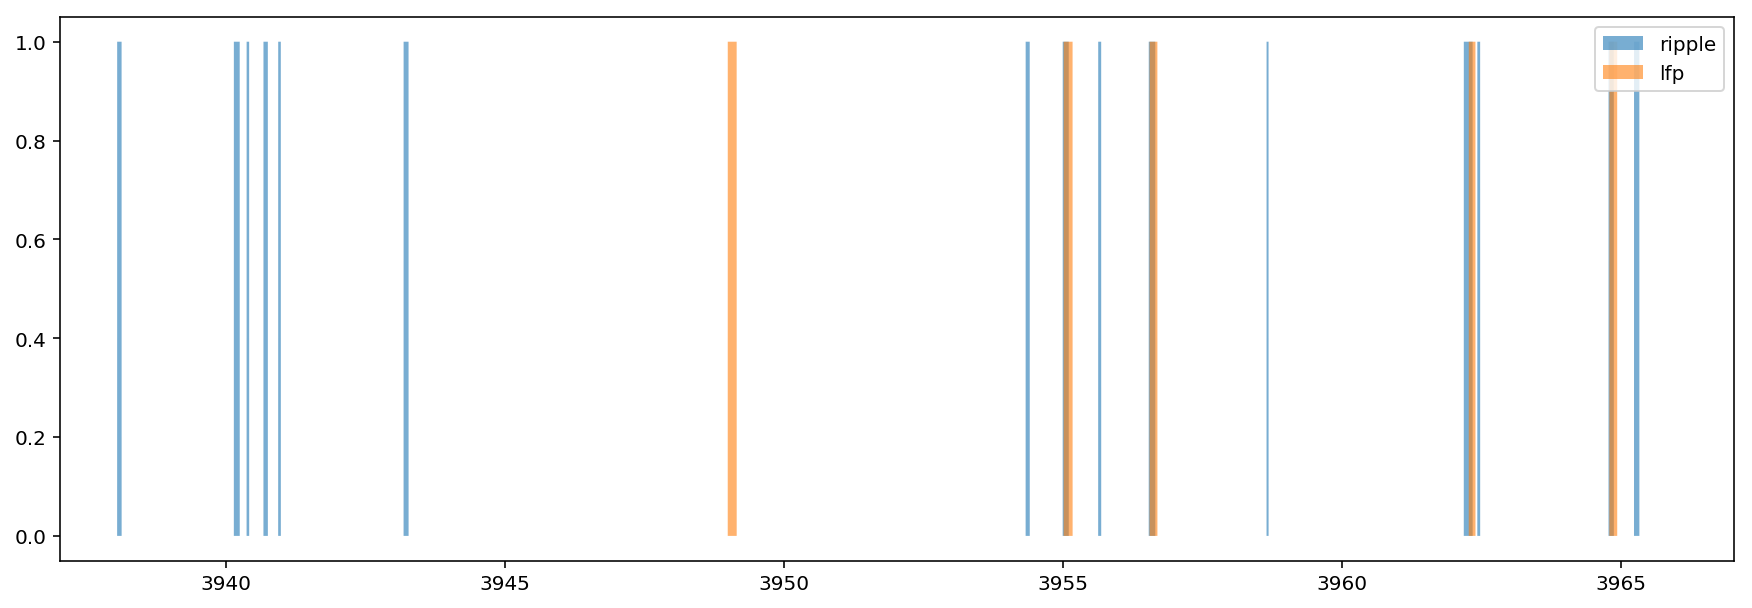

In [432]:
t = 208
segment_length = 30

time = data['ripple_labels'].index.total_seconds()
m = time.min() + t
is_time = (time > m) & (time < (m + segment_length))

plt.figure(figsize=(15, 5))
plt.fill_betweenx(data['ripple_labels'][is_time] > 0, time[is_time], alpha=0.6, label='ripple')

time = is_replay.index.total_seconds()
m = time.min() + t
is_time = (time > m) & (time < m + segment_length)
plt.fill_betweenx((is_replay.replay_number > 0)[is_time], time[is_time], alpha=0.6, label='lfp')

plt.xlim((m, m + segment_length));
plt.legend();

In [350]:
overlap = compare_overlap(data['ripple_labels'], is_replay.replay_number, data['ripple_times'], replay_info)

overlap.head()

n_overlap  total_labels1  total_labels2  overlap_percentage1  \
labels1 labels2                                                                 
2       1              119            179            240            66.480447   
3       2              115            160            270            71.875000   
7       3               70             89             90            78.651685   
9       4               83             94            150            88.297872   
12      5              128            148            186            86.486486   

                 overlap_percentage2    start_time_difference  \
labels1 labels2                                                 
2       1                  49.583333 -1 days +23:59:59.960000   
3       2                  42.592593 -1 days +23:59:59.970000   
7       3                  77.777778 -1 days +23:59:59.987333   
9       4                  55.333333 -1 days +23:59:59.992666   
12      5                  68.817204 -1 days +23:59:59.986666   

                     end_time_difference  
labels1 labels2                           
2       1       -1 days +23:59:59.919333  
3       2       -1 days +23:59:59.896666  
7       3       -1 days +23:59:59.986666  
9       4       -1 days +23:59:59.955333  
12      5       -1 days +23:59:59.961333

In [351]:
overlap = compare_overlap(is_replay.replay_number, is_replay.replay_number, replay_info, replay_info)

overlap.head()

n_overlap  total_labels1  total_labels2  overlap_percentage1  \
labels1 labels2                                                                 
1       1              240            240            240                100.0   
2       2              270            270            270                100.0   
3       3               90             90             90                100.0   
4       4              150            150            150                100.0   
5       5              186            186            186                100.0   

                 overlap_percentage2 start_time_difference end_time_difference  
labels1 labels2                                                                 
1       1                      100.0                0 days              0 days  
2       2                      100.0                0 days              0 days  
3       3                      100.0                0 days              0 days  
4       4                      100.0                0 days              0 days  
5       5                      100.0                0 days              0 days

In [609]:
import itertools
from src.summarize_replay import compare_overlap

labels = [is_replay.replay_number, is_replay.replay_number, is_replay.replay_number, is_replay.replay_number]
infos = [replay_info, replay_info, replay_info, replay_info]
names = list(use_likelihoods.keys())
names.append('ripple')

combinations = itertools.combinations(zip(labels, infos, names), 2)
for (labels1, info1, name1), (labels2, info2, name2) in combinations:
    print(name1, name2)
    overlap = compare_overlap(labels1, labels2, info1, info2)


lfp_power spikes
lfp_power spikes_and_lfp_power
lfp_power ripple
spikes spikes_and_lfp_power
spikes ripple
spikes_and_lfp_power ripple


## Position Tuning

In [45]:
from loren_frank_data_processing import get_interpolated_position_dataframe, get_position_dataframe

position_info = get_position_dataframe(
    epoch_key, ANIMALS, route_euclidean_distance_scaling=1, sensor_std_dev=40)

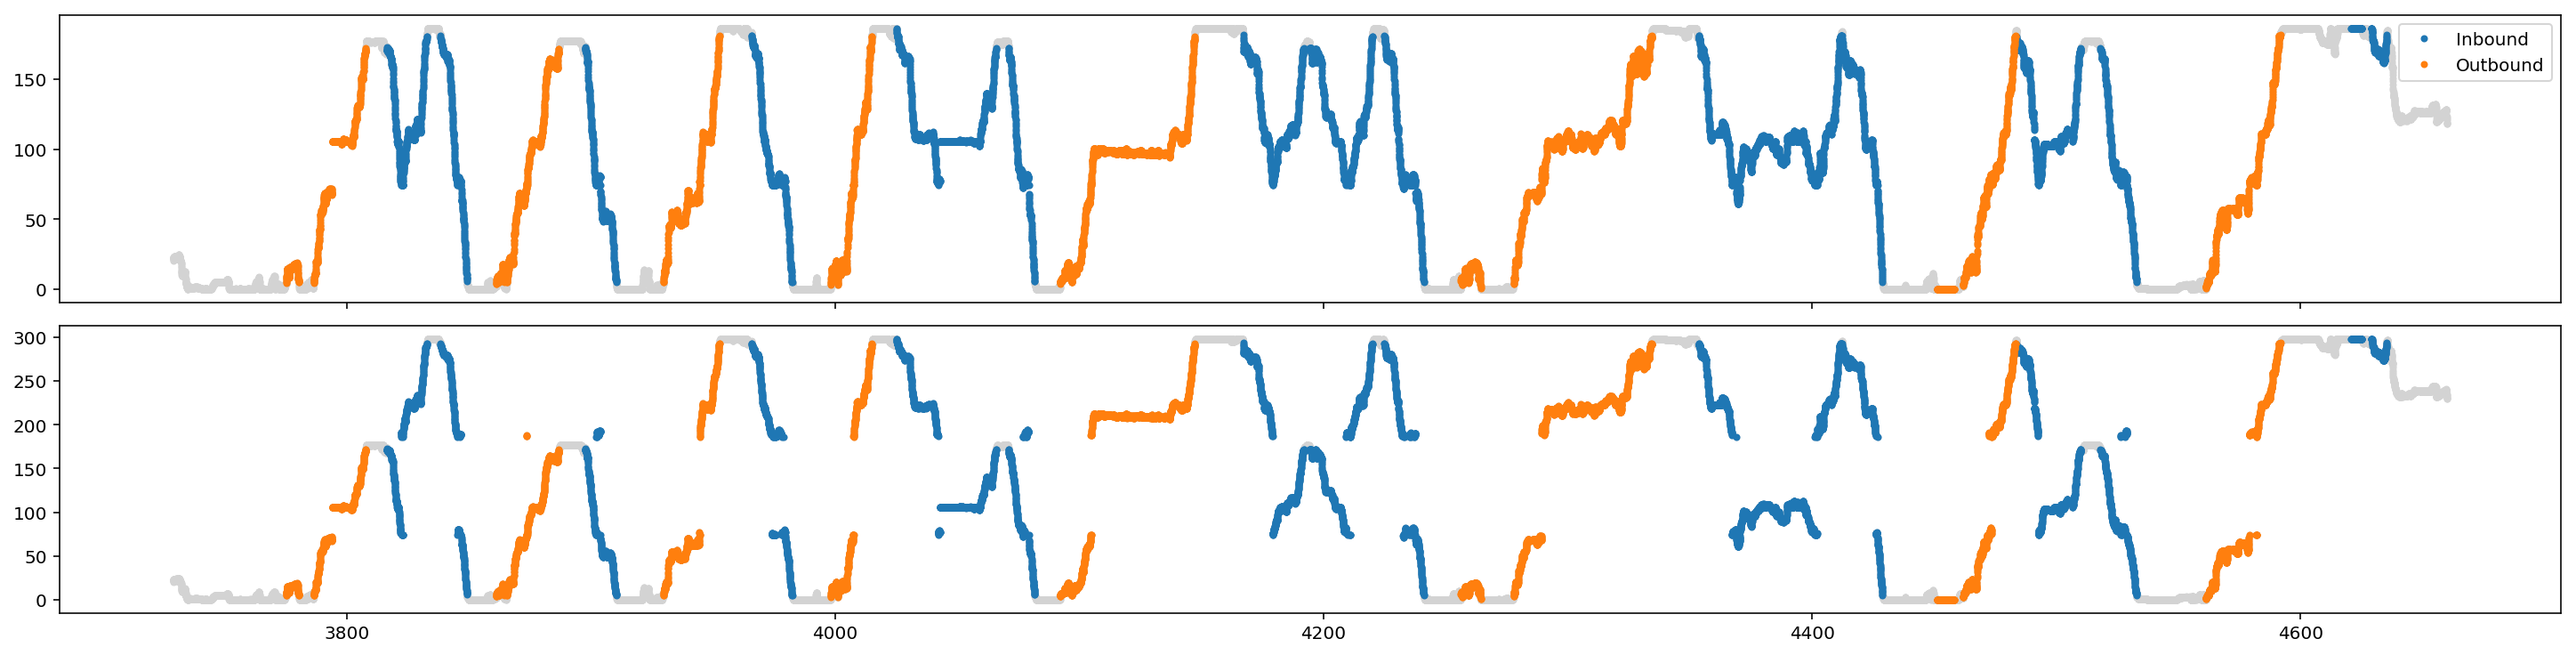

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)

time = position_info.index.total_seconds()
is_inbound = position_info.task == 'Inbound'
is_outbound = position_info.task == 'Outbound'

axes[0].plot(time, position_info.linear_distance.values, '.', color='lightgrey')
axes[0].plot(time[is_inbound], position_info.linear_distance.values[is_inbound], '.', label='Inbound')
axes[0].plot(time[is_outbound], position_info.linear_distance.values[is_outbound], '.', label='Outbound')

axes[0].legend()

axes[1].plot(time, position_info.linear_position2.values, '.', color='lightgrey')
axes[1].plot(time[is_inbound], position_info.linear_position2.values[is_inbound], '.', label='Inbound')
axes[1].plot(time[is_outbound], position_info.linear_position2.values[is_outbound], '.', label='Outbound')

In [47]:
from scipy.ndimage.measurements import label
from ipywidgets import interact

position_labels = label(position_info.linear_position.fillna(0.0))[0]

@interact(label=(1, position_labels.max()), continuous_update=False)
def plot_position(label):
    position_metric='linear_position2'
    is_label = (position_labels == label)
    colormap = {'Inbound': 'blue',
                'Outbound': 'orange'}
    p = position_info[is_label]
    task = p.task.unique()[0]
    turn = p.turn.unique()[0]
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(position_info.x_position, position_info.y_position, color='lightgrey')
    axes[0].plot(p.x_position, p.y_position, color=colormap[task])
    axes[0].scatter(p.x_position[0], p.y_position[0], color='green', s=100, zorder=1000)
    axes[0].scatter(p.x_position[-1], p.y_position[-1], color='red', s=100, zorder=1000)
    axes[0].set_title(f'{label}: {task} - {turn} turn')
    
    axes[1].plot(p.index.total_seconds(), p[position_metric], color=colormap[task])
    axes[1].scatter(p.index.total_seconds()[0], p[position_metric][0], color='green', s=100, zorder=1000)
    axes[1].scatter(p.index.total_seconds()[-1], p[position_metric][-1], color='red', s=100, zorder=1000)

    axes[1].set_ylim((position_info[position_metric].min(), position_info[position_metric].max()))
    axes[1].set_title('Linear Position')

interactive(children=(IntSlider(value=13, description='label', max=26, min=1), Output()), _dom_classes=('widge…

Text(0.5, 1.0, 'linear_position')

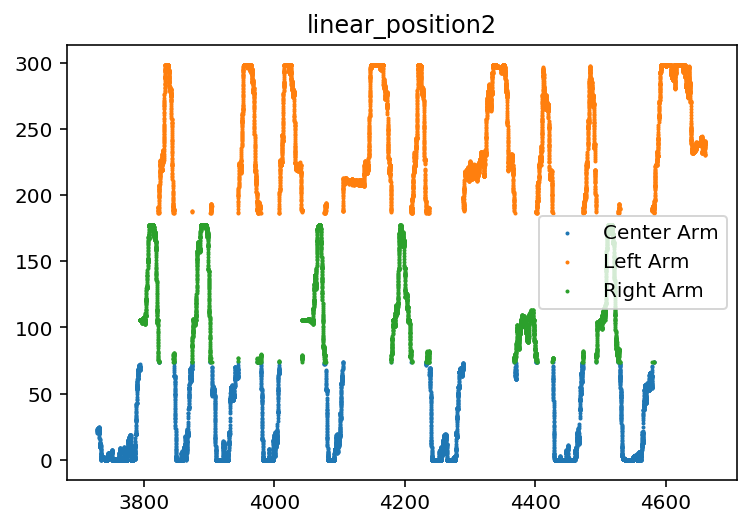

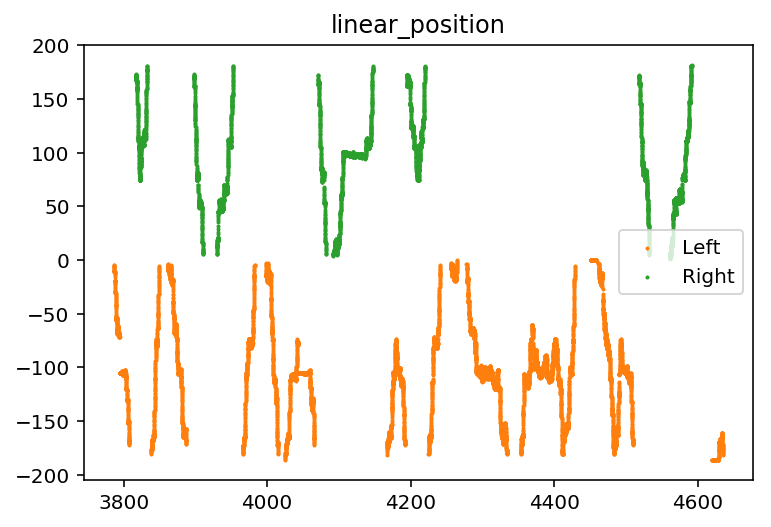

In [325]:
plt.figure()
for name, g in position_info.groupby('arm_name'):
    plt.scatter(g.index.total_seconds(), g.linear_position2, label=name, s=1)
plt.legend()
plt.title('linear_position2')


plt.figure()
for name, g in position_info.groupby('turn'):
    plt.scatter(g.index.total_seconds(), g.linear_position, label=name, s=1)
plt.legend()
plt.title('linear_position')

## Analyze single and double epoch

In [10]:
import itertools
import logging
import sys
from argparse import ArgumentParser
from os.path import join
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt

from replay_identification import ReplayDetector
from src.load_data import load_data
from src.parameters import (ANIMALS, FIGURE_DIR, SAMPLING_FREQUENCY,
                            USE_LIKELIHOODS, BRAIN_AREAS)
from src.save_data import save_overlap, save_replay_data
from src.summarize_replay import (add_epoch_info_to_dataframe, compare_overlap,
                                  decode_replays, get_replay_times,
                                  summarize_replays)
from src.visualization import plot_behavior


def run_analysis(epoch_key, animals, sampling_frequency, use_likelihoods,
                 position_metric='linear_distance',
                 speed_metric='linear_speed'):
    animal, day, epoch = epoch_key
    data_types = set(itertools.chain(*use_likelihoods.values()))
    data = load_data(epoch_key, animals, sampling_frequency, data_types,
                     BRAIN_AREAS, speed_metric)

    replay_detector = ReplayDetector()
    replay_detector.fit(
        is_replay=data['is_ripple'], speed=data['position_info'][speed_metric],
        position=data['position_info'][position_metric],
        lfp_power=data['power'], spikes=data['spikes'],
        multiunit=data['multiunit'])

    names = []
    labels = []
    infos = []

    for name, likelihoods in use_likelihoods.items():
        logging.info(f'Finding replays with {name}...')
        if name != 'ripple':
            detector_results = replay_detector.predict(
                speed=data['position_info'][speed_metric],
                position=data['position_info'][position_metric],
                lfp_power=data['power'],
                spikes=data['spikes'], multiunit=data['multiunit'],
                time=data['position_info'].index,
                use_likelihoods=likelihoods)
            replay_info, is_replay = get_replay_times(detector_results)
        else:
            replay_info = data['ripple_times'].copy()
            is_replay = data['ripple_labels'].copy()

        logging.info(f'Classifying replays with {name}...')
        replay_info = add_epoch_info_to_dataframe(replay_info, epoch_key, name)
        decoder_results, _ = decode_replays(
            data, replay_detector, is_replay, replay_info, sampling_frequency,
            position_metric)
        logging.info(f'Summarizing replays with {name}...')
        replay_info, replay_densities = summarize_replays(
            replay_info, detector_results, decoder_results, data,
            position_metric)

        names.append(name)
        labels.append(is_replay.replay_number)
        infos.append(replay_info)
        
    return labels, infos, names

In [12]:
from collections import OrderedDict

epoch_key = ('bon', 3, 2)


l = OrderedDict(
    [('lfp_power', ['lfp_power']),
     ('spikes', ['spikes'])]
)
labels, infos, names = run_analysis(epoch_key, ANIMALS, SAMPLING_FREQUENCY, l)

INFO:src.load_data:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)
INFO:src.load_data:Finding ripple times...
INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


INFO:root:Finding replays with lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...
INFO:root:Classifying replays with lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with lfp_power...
INFO:root:Finding replays with spikes...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...
INFO:root:Classifying replays with spikes...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes...


In [89]:
animal, day, epoch = epoch_key

combination = itertools.combinations(zip(labels, infos, names), 2)
for (labels1, info1, name1), (labels2, info2, name2) in combination:
    labels1[~labels1.isin(info1.replay_number.values)] = 0
    labels2[~labels2.isin(info2.replay_number.values)] = 0
    logging.info(
        f'Analyzing replay overlap between {name1} and {name2}...')
    overlap_info = compare_overlap(
        labels1, labels2, info1, info2, SAMPLING_FREQUENCY)
    overlap_info['animal'] = animal
    overlap_info['day'] = day
    overlap_info['epoch'] = epoch
    overlap_info['data_source1'] = name1
    overlap_info['data_source2'] = name2

INFO:root:Analyzing replay overlap between lfp_power and spikes...


In [19]:
labels1 = labels1.copy().rename('labels1')
labels2 = labels2.copy().rename('labels2')
is_overlap = (labels1 > 0) & (labels2 > 0)


INFO:src.load_data:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=2461.011466666, n_tapers=1)
INFO:src.load_data:Finding ripple times...
INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...
INFO:root:Finding replays with lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...
INFO:root:Classifying replays with lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with lfp_power...
INFO:root:Finding replays with spikes...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...
INFO:root:Classifying replays with spikes...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes...
INFO:root:Finding replays with spikes_and_lfp_power...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...
INFO:root:Classifying replays with spikes_and_lfp_power...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with spikes_and_lfp_power...
INFO:root:Finding replays with ripple...
INFO:root:Classifying replays with ripple...
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


INFO:root:Summarizing replays with ripple...
INFO:root:Analyzing replay overlap between lfp_power and spikes...
INFO:root:Analyzing replay overlap between lfp_power and spikes_and_lfp_power...
INFO:root:Analyzing replay overlap between lfp_power and ripple...
INFO:root:Analyzing replay overlap between spikes and spikes_and_lfp_power...
INFO:root:Analyzing replay overlap between spikes and ripple...
INFO:root:Analyzing replay overlap between spikes_and_lfp_power and ripple...
INFO:root:Done...


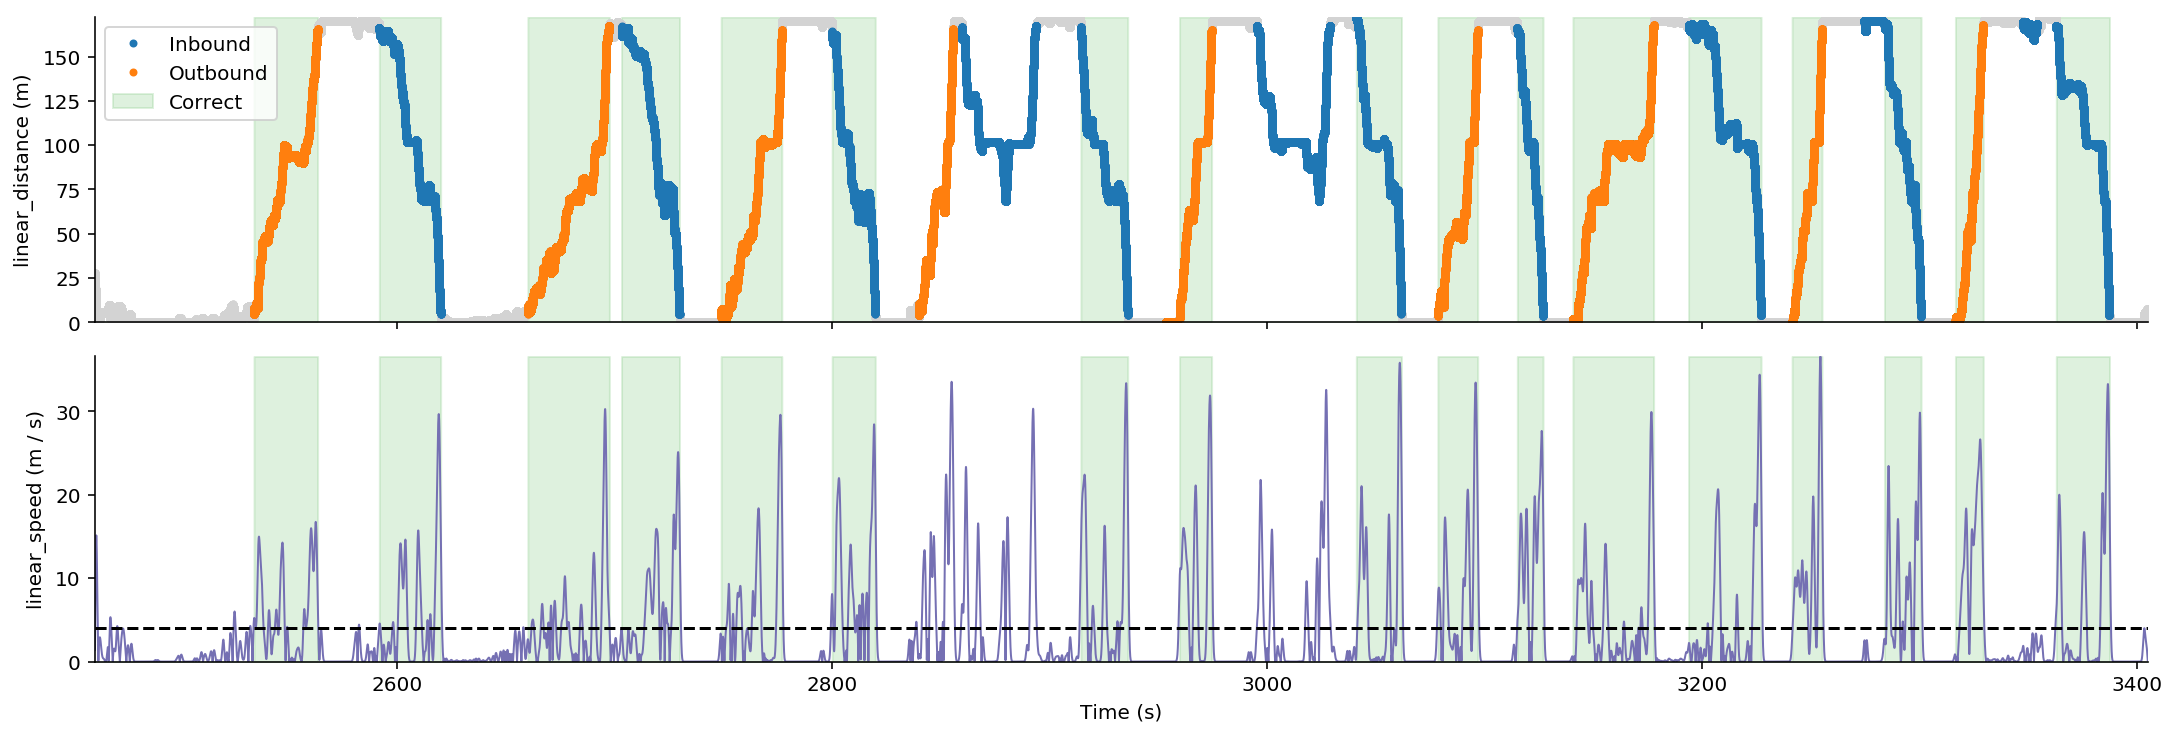

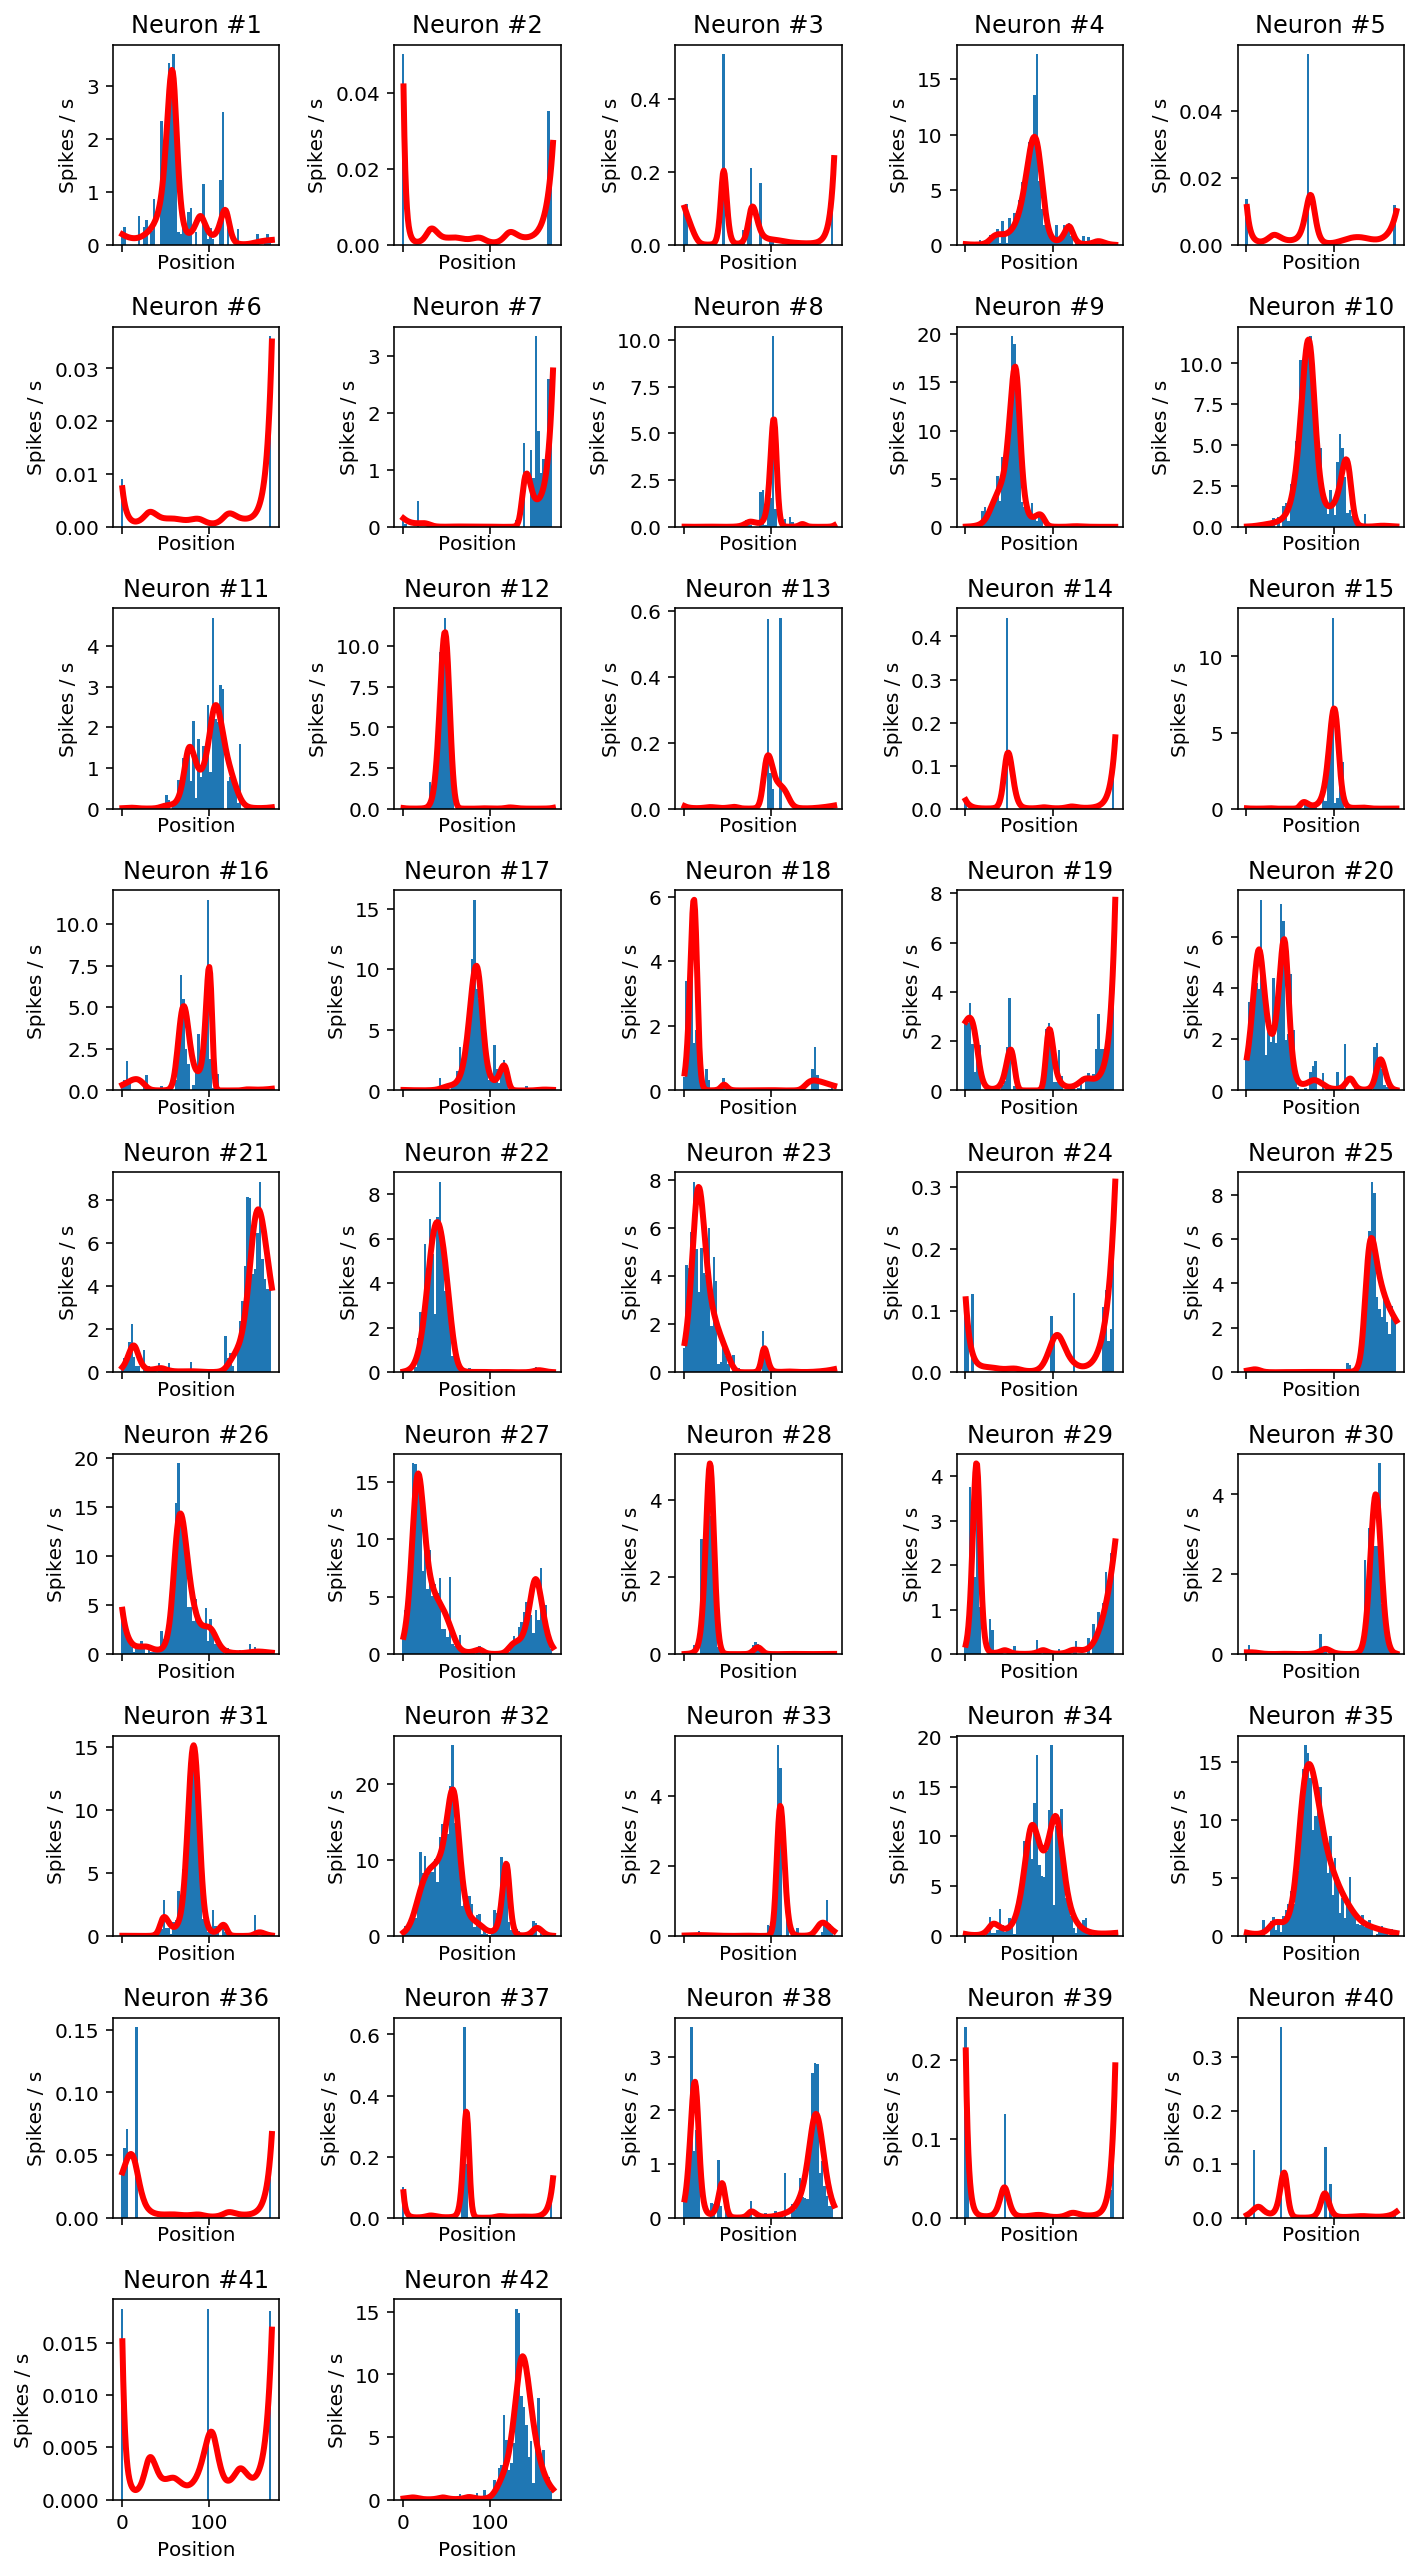

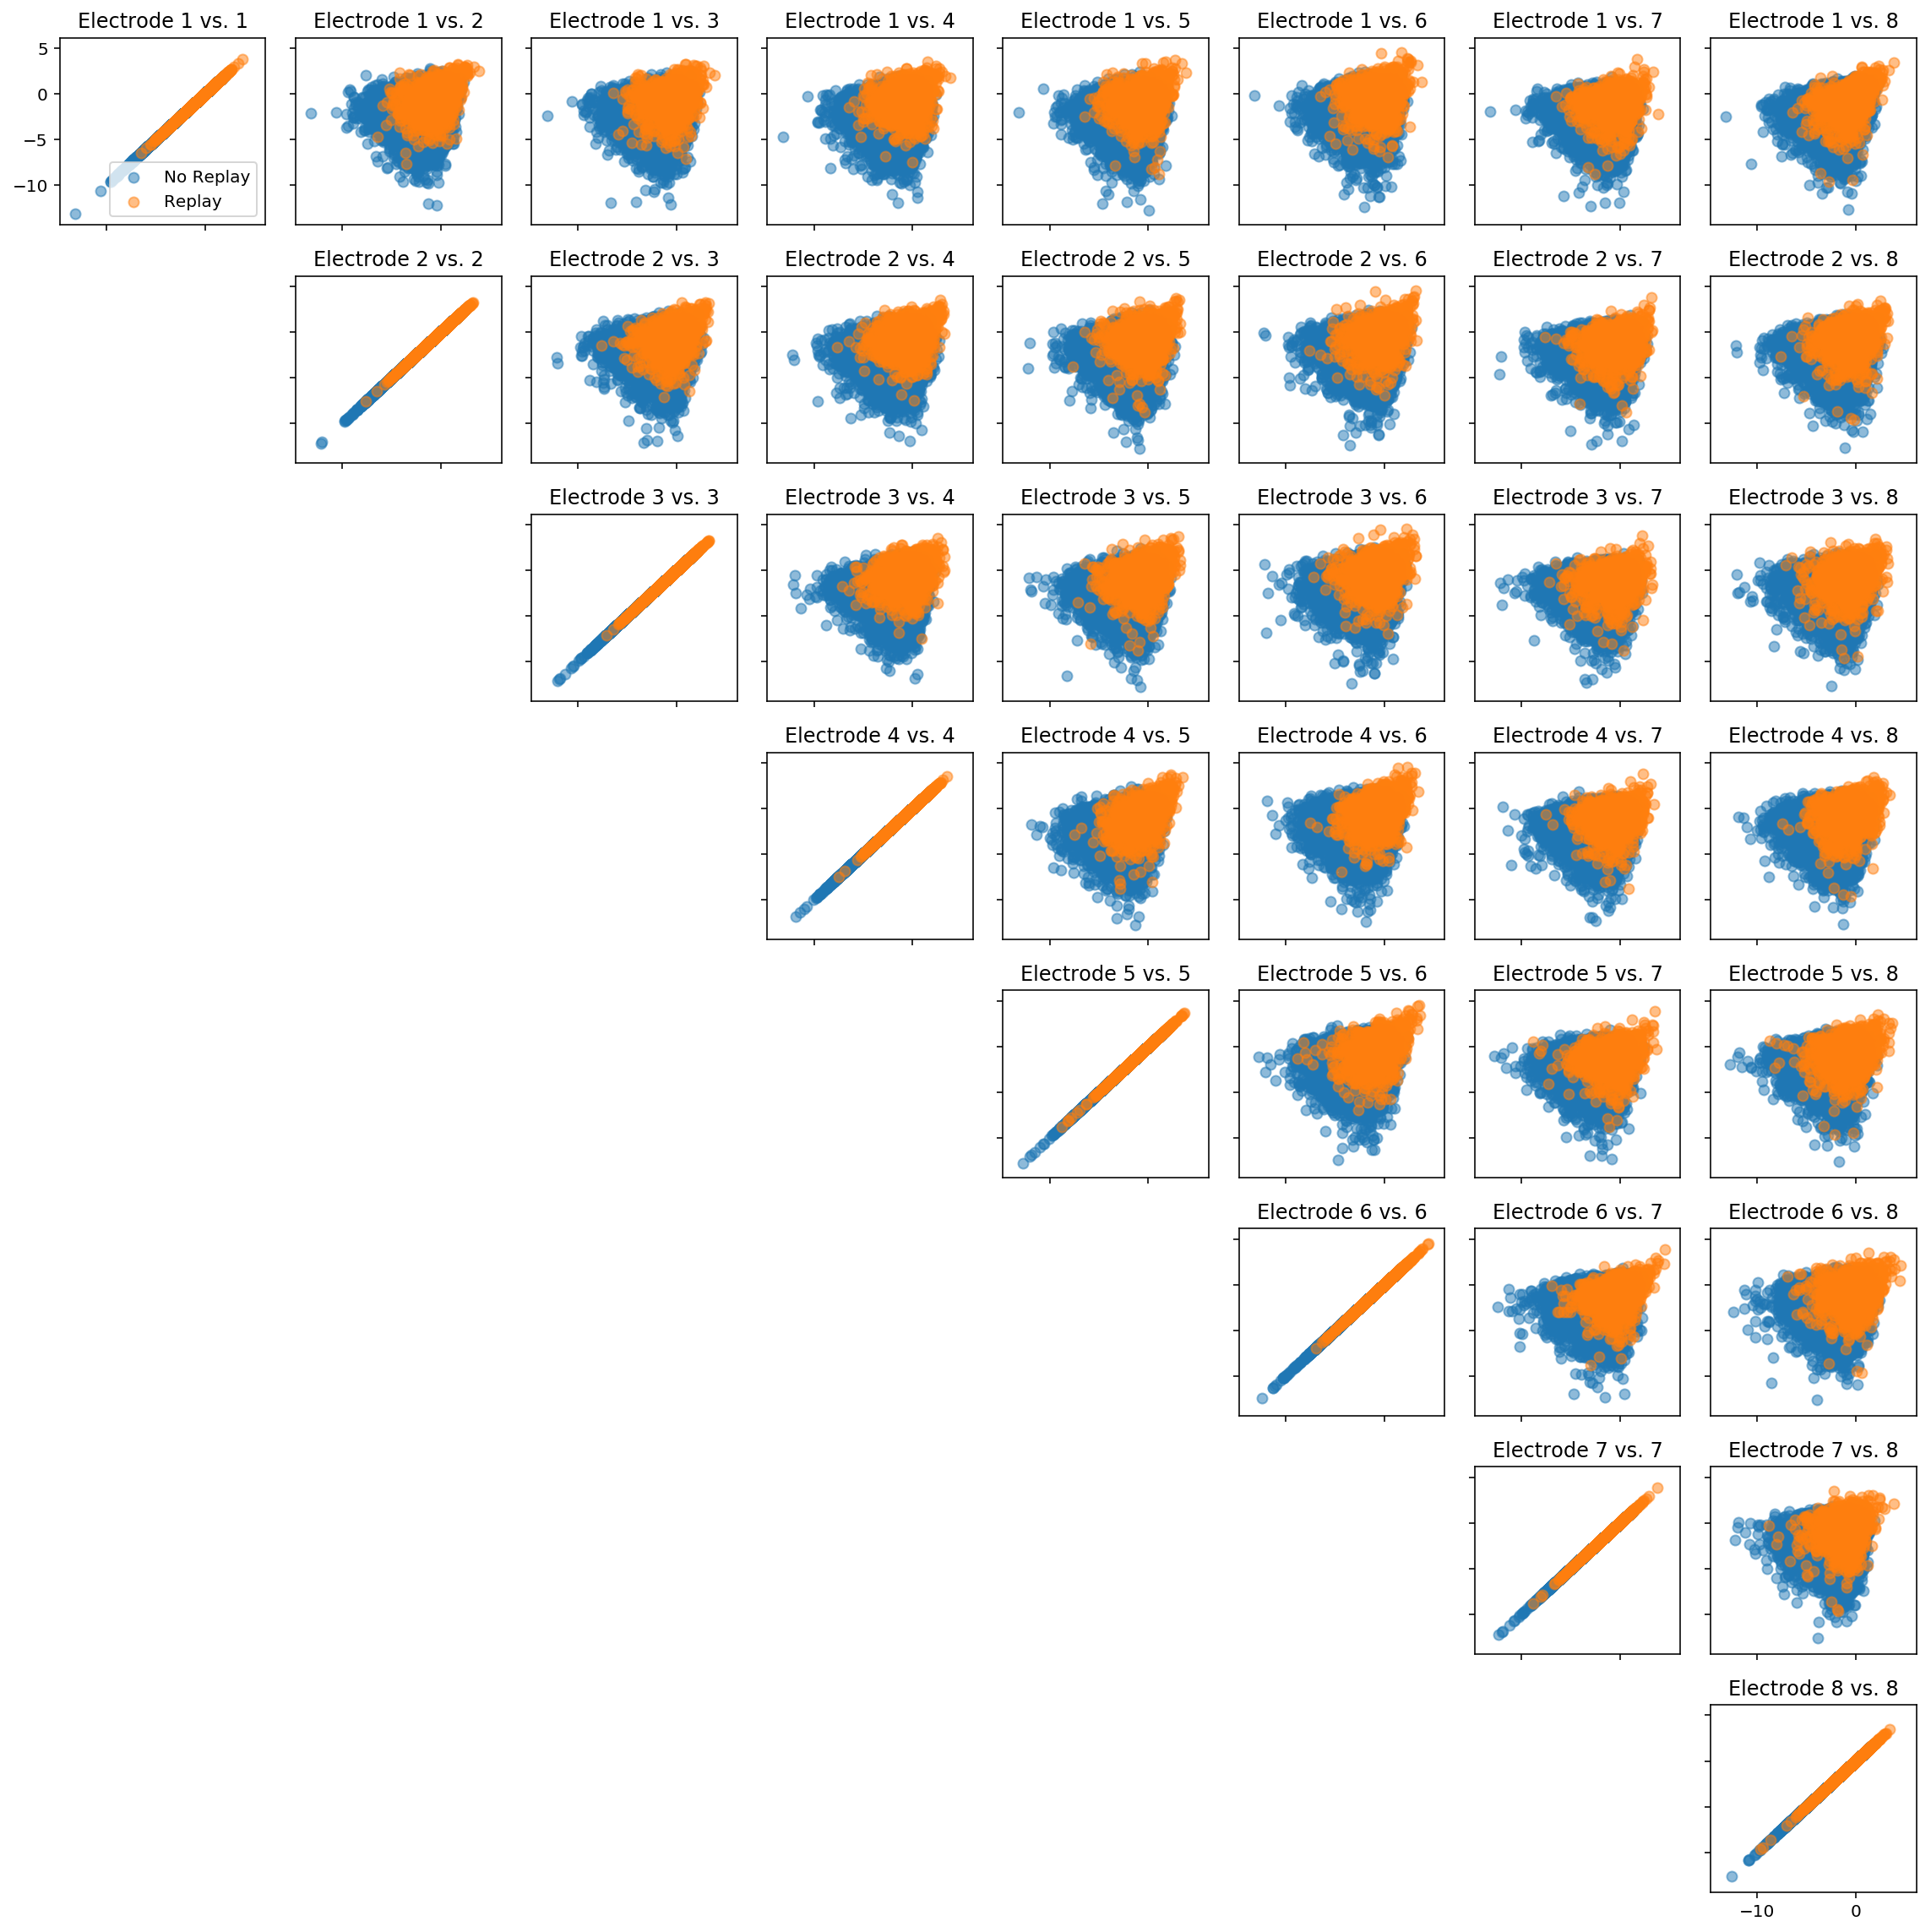

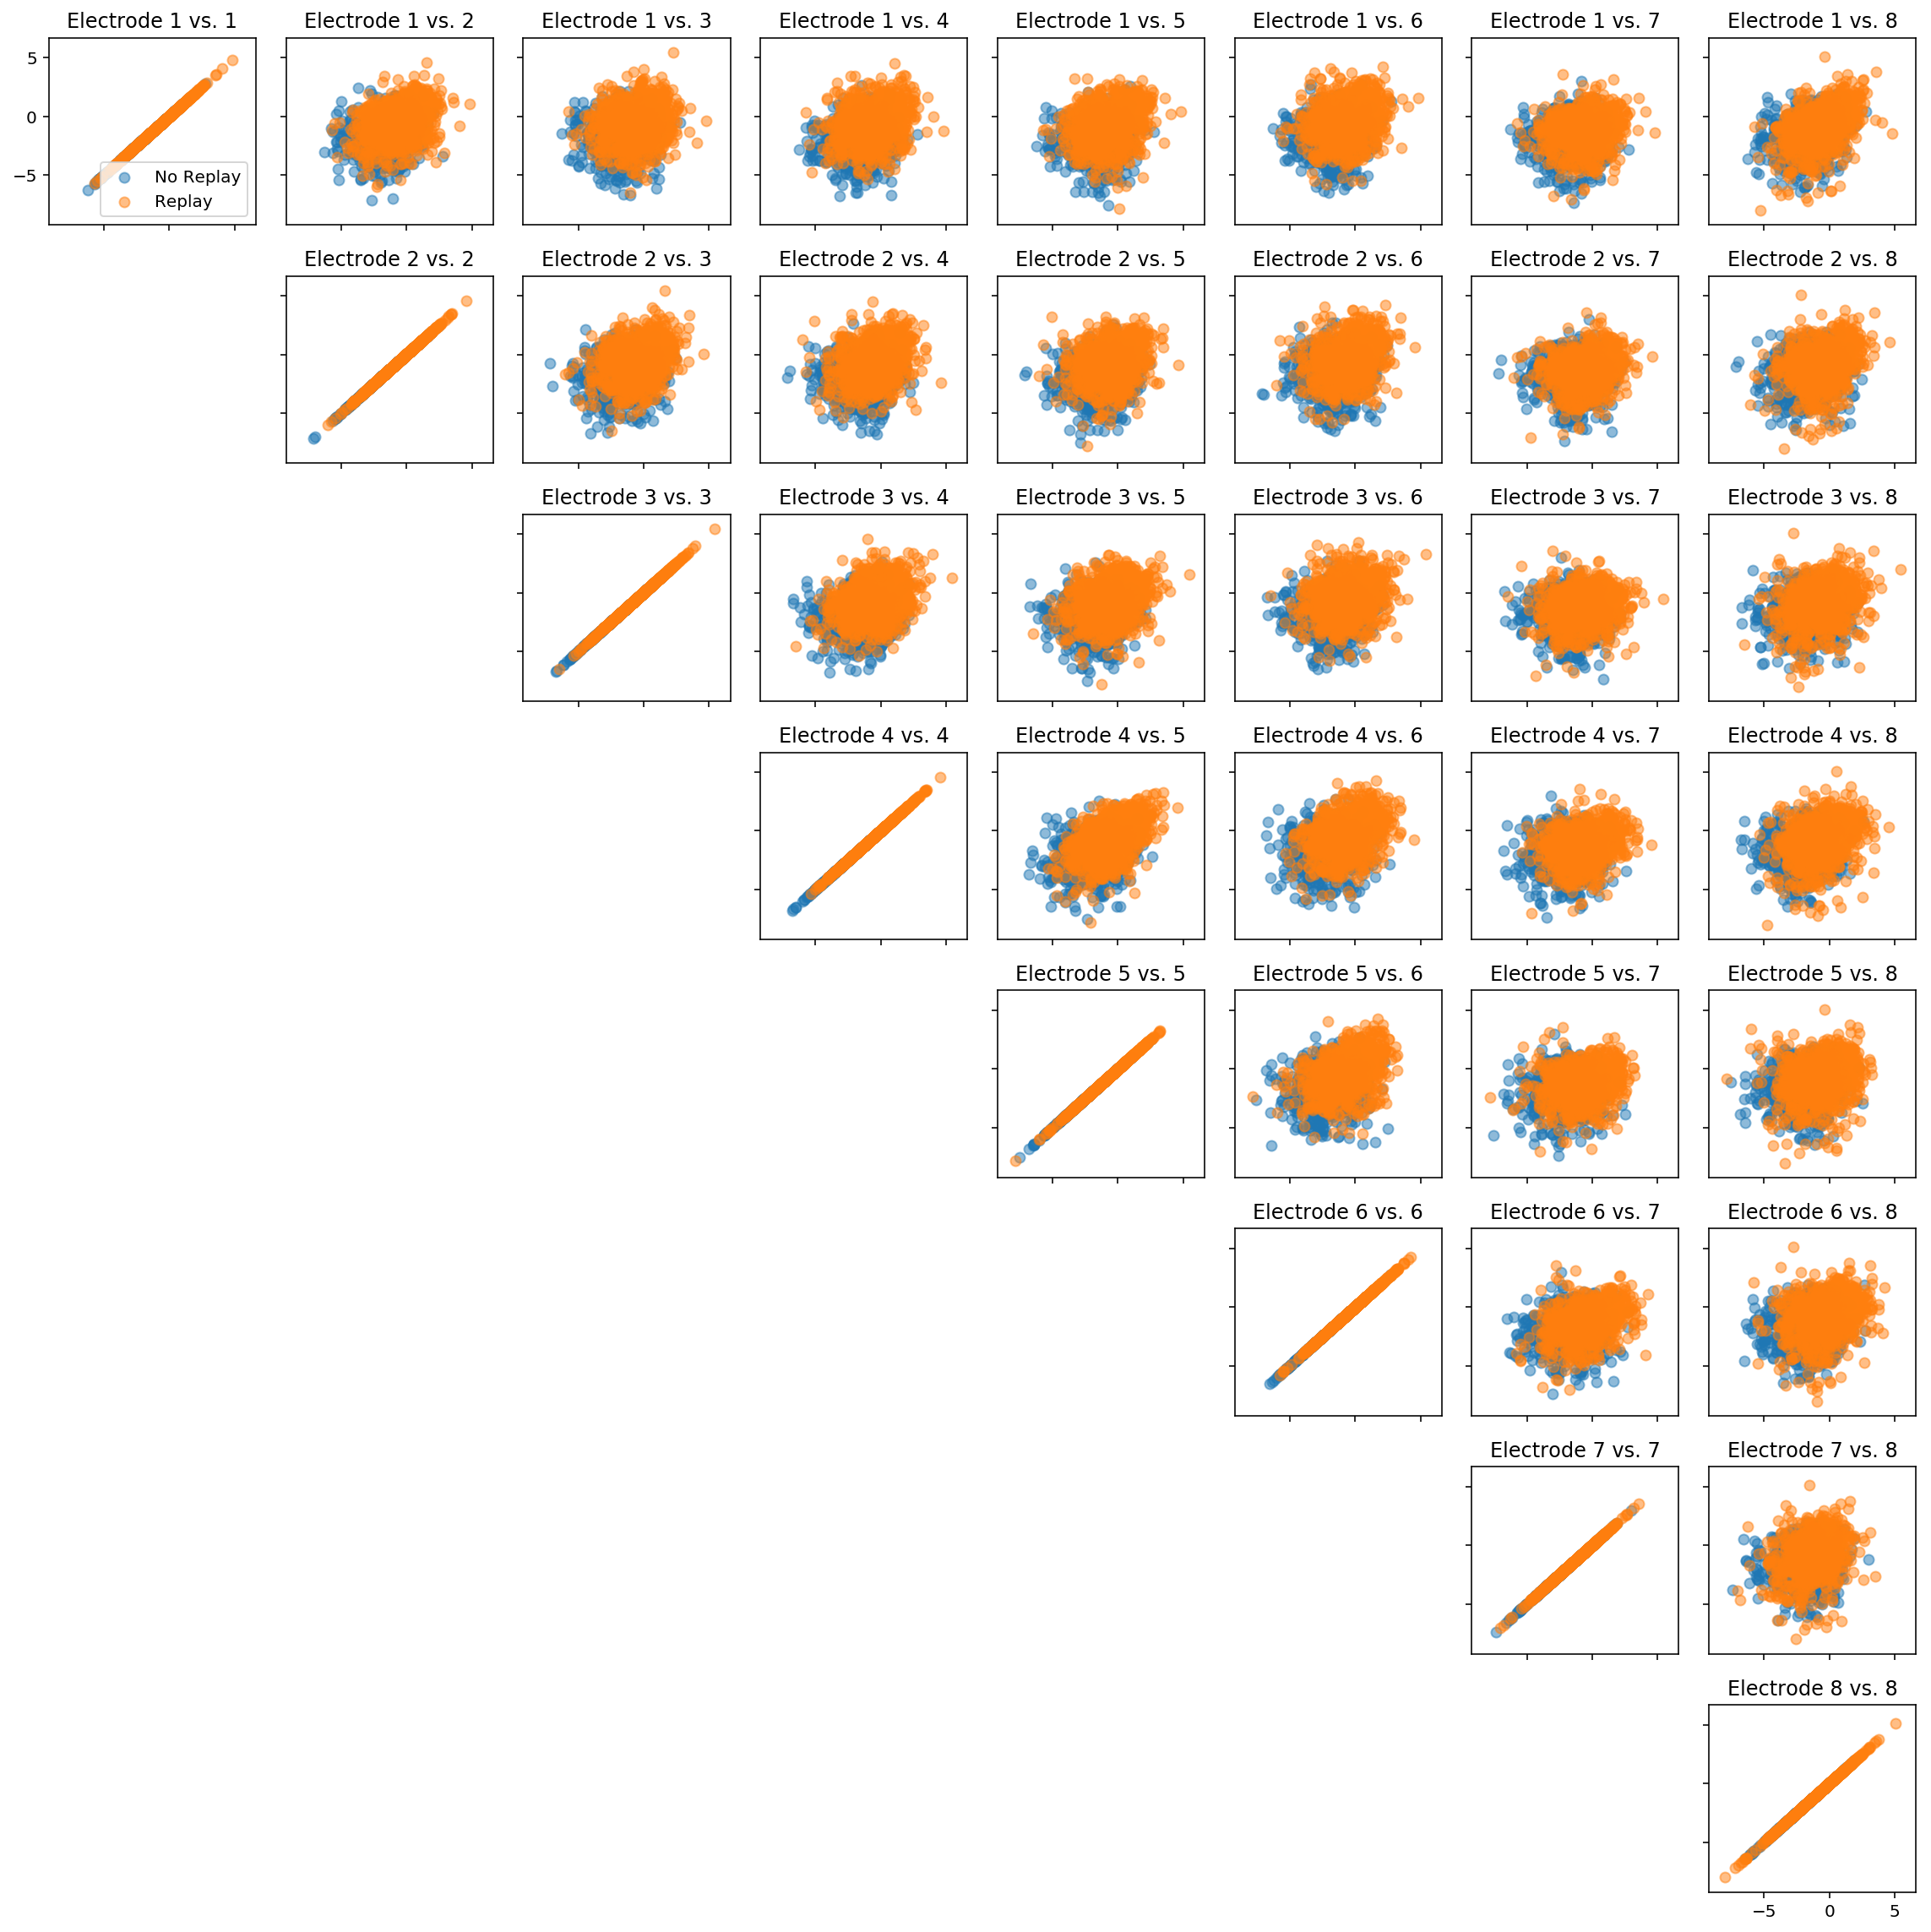

In [66]:
epoch_key = ('bon', 4, 2)
run_analysis(epoch_key, ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS)

In [68]:
xr.open_mfdataset('../Processed-Data/*.nc', group='spikes/replay_info',
                  autoclose=True).to_dataframe().head()

replay_number      start_time        end_time  \
replay_id                                                             
bon_03_02_001_spikes              1 01:02:09.867033 01:02:12.363700   
bon_03_02_002_spikes              2 01:02:21.865033 01:02:22.121033   
bon_03_02_003_spikes              3 01:02:48.183033 01:02:48.480366   
bon_03_02_004_spikes              4 01:03:02.912366 01:03:03.162366   
bon_03_02_005_spikes              5 01:03:19.758366 01:03:19.859033   

                            duration  max_probability animal  day  epoch  \
replay_id                                                                  
bon_03_02_001_spikes 00:00:02.496666         0.982502    bon    3      2   
bon_03_02_002_spikes 00:00:00.256000         0.906101    bon    3      2   
bon_03_02_003_spikes 00:00:00.297333         0.830940    bon    3      2   
bon_03_02_004_spikes 00:00:00.250000         0.977562    bon    3      2   
bon_03_02_005_spikes 00:00:00.100666         0.853671    bon    3      2   

                     data_source  track_segment_id           ...            \
replay_id                                                    ...             
bon_03_02_001_spikes      spikes               0.0           ...             
bon_03_02_002_spikes      spikes               0.0           ...             
bon_03_02_003_spikes      spikes               0.0           ...             
bon_03_02_004_spikes      spikes               0.0           ...             
bon_03_02_005_spikes      spikes               4.0           ...             

                     linear_velocity  linear_speed linear_position  \
replay_id                                                            
bon_03_02_001_spikes        0.337239      0.337239             NaN   
bon_03_02_002_spikes        0.092977      0.092977             NaN   
bon_03_02_003_spikes        0.529262      0.529262             NaN   
bon_03_02_004_spikes        1.291870      1.291870             NaN   
bon_03_02_005_spikes       -0.435518      0.435518      -105.77038   

                     linear_position2       replay_type  \
replay_id                                                 
bon_03_02_001_spikes        22.390052  Outbound-Forward   
bon_03_02_002_spikes         0.000000  Outbound-Reverse   
bon_03_02_003_spikes         0.000000  Outbound-Reverse   
bon_03_02_004_spikes         0.000000  Outbound-Reverse   
bon_03_02_005_spikes       105.770380   Inbound-Forward   

                      replay_type_confidence replay_motion_slope  \
replay_id                                                          
bon_03_02_001_spikes                0.999865            9.916003   
bon_03_02_002_spikes                0.999858            9.341860   
bon_03_02_003_spikes                1.000000            2.146091   
bon_03_02_004_spikes                0.983779         -367.635879   
bon_03_02_005_spikes                0.982398        -1174.392735   

                      replay_motion_type  replay_movement_distance  \
replay_id                                                            
bon_03_02_001_spikes             Neither                 22.901225   
bon_03_02_002_spikes             Neither                  0.000000   
bon_03_02_003_spikes             Neither                  0.000000   
bon_03_02_004_spikes             Towards                103.553365   
bon_03_02_005_spikes             Towards                 97.579132   

                      credible_interval_size  
replay_id                                     
bon_03_02_001_spikes                0.014939  
bon_03_02_002_spikes                0.018874  
bon_03_02_003_spikes                0.018632  
bon_03_02_004_spikes                0.006614  
bon_03_02_005_spikes                0.013180  

[5 rows x 32 columns]

In [69]:
xr.open_mfdataset('../Processed-Data/*.nc', group='lfp_power/replay_info',
                  autoclose=True).to_dataframe().head()

replay_number      start_time        end_time  \
replay_id                                                                
bon_03_02_001_lfp_power              1 01:02:22.825700 01:02:22.985033   
bon_03_02_002_lfp_power              2 01:02:27.105700 01:02:27.285033   
bon_03_02_003_lfp_power              3 01:02:35.965700 01:02:36.025033   
bon_03_02_004_lfp_power              4 01:02:38.145700 01:02:38.245033   
bon_03_02_005_lfp_power              5 01:03:29.205700 01:03:29.331033   

                               duration  max_probability animal  day  epoch  \
replay_id                                                                     
bon_03_02_001_lfp_power 00:00:00.159333         0.999848    bon    3      2   
bon_03_02_002_lfp_power 00:00:00.179333         0.999999    bon    3      2   
bon_03_02_003_lfp_power 00:00:00.059333         0.806958    bon    3      2   
bon_03_02_004_lfp_power 00:00:00.099333         0.999656    bon    3      2   
bon_03_02_005_lfp_power 00:00:00.125333         0.999992    bon    3      2   

                        data_source  track_segment_id           ...            \
replay_id                                                       ...             
bon_03_02_001_lfp_power   lfp_power               0.0           ...             
bon_03_02_002_lfp_power   lfp_power               0.0           ...             
bon_03_02_003_lfp_power   lfp_power               0.0           ...             
bon_03_02_004_lfp_power   lfp_power               0.0           ...             
bon_03_02_005_lfp_power   lfp_power               4.0           ...             

                        linear_velocity  linear_speed linear_position  \
replay_id                                                               
bon_03_02_001_lfp_power       -0.117607      0.117607             NaN   
bon_03_02_002_lfp_power        0.070066      0.070066             NaN   
bon_03_02_003_lfp_power        0.152085      0.152085             NaN   
bon_03_02_004_lfp_power       -0.000982      0.000982             NaN   
bon_03_02_005_lfp_power        0.185453      0.185453             NaN   

                        linear_position2       replay_type  \
replay_id                                                    
bon_03_02_001_lfp_power         0.007226  Outbound-Reverse   
bon_03_02_002_lfp_power         4.950396  Outbound-Reverse   
bon_03_02_003_lfp_power         0.000000  Outbound-Reverse   
bon_03_02_004_lfp_power         0.000000      Unclassified   
bon_03_02_005_lfp_power       176.714710   Inbound-Forward   

                         replay_type_confidence replay_motion_slope  \
replay_id                                                             
bon_03_02_001_lfp_power                0.999426           23.823095   
bon_03_02_002_lfp_power                0.996774           17.790905   
bon_03_02_003_lfp_power                0.964005           10.755449   
bon_03_02_004_lfp_power                     NaN           64.315383   
bon_03_02_005_lfp_power                0.985830        -1059.634683   

                         replay_motion_type  replay_movement_distance  \
replay_id                                                               
bon_03_02_001_lfp_power             Neither                  0.000000   
bon_03_02_002_lfp_power             Neither                  0.000000   
bon_03_02_003_lfp_power             Neither                  0.000000   
bon_03_02_004_lfp_power                Away                  0.000000   
bon_03_02_005_lfp_power             Towards                 96.583427   

                         credible_interval_size  
replay_id                                        
bon_03_02_001_lfp_power                0.018092  
bon_03_02_002_lfp_power                0.018210  
bon_03_02_003_lfp_power                0.016334  
bon_03_02_004_lfp_power                0.016685  
bon_03_02_005_lfp_power                0.011474  

[5 rows x 32 columns]

In [70]:
xr.open_mfdataset('../Processed-Data/*.nc', group='spikes_and_lfp_power/replay_info',
                 autoclose=True).to_dataframe().head()

replay_number      start_time  \
replay_id                                                           
bon_03_02_001_spikes_and_lfp_power              1 01:02:22.825700   
bon_03_02_002_spikes_and_lfp_power              2 01:02:27.105700   
bon_03_02_003_spikes_and_lfp_power              3 01:02:35.965700   
bon_03_02_004_spikes_and_lfp_power              4 01:02:38.145700   
bon_03_02_005_spikes_and_lfp_power              5 01:03:19.745700   

                                          end_time        duration  \
replay_id                                                            
bon_03_02_001_spikes_and_lfp_power 01:02:22.985033 00:00:00.159333   
bon_03_02_002_spikes_and_lfp_power 01:02:27.265033 00:00:00.159333   
bon_03_02_003_spikes_and_lfp_power 01:02:36.045033 00:00:00.079333   
bon_03_02_004_spikes_and_lfp_power 01:02:38.245033 00:00:00.099333   
bon_03_02_005_spikes_and_lfp_power 01:03:19.837033 00:00:00.091333   

                                    max_probability animal  day  epoch  \
replay_id                                                                
bon_03_02_001_spikes_and_lfp_power         0.999922    bon    3      2   
bon_03_02_002_spikes_and_lfp_power         0.999999    bon    3      2   
bon_03_02_003_spikes_and_lfp_power         0.994183    bon    3      2   
bon_03_02_004_spikes_and_lfp_power         0.996901    bon    3      2   
bon_03_02_005_spikes_and_lfp_power         0.996893    bon    3      2   

                                             data_source  track_segment_id  \
replay_id                                                                    
bon_03_02_001_spikes_and_lfp_power  spikes_and_lfp_power               0.0   
bon_03_02_002_spikes_and_lfp_power  spikes_and_lfp_power               0.0   
bon_03_02_003_spikes_and_lfp_power  spikes_and_lfp_power               0.0   
bon_03_02_004_spikes_and_lfp_power  spikes_and_lfp_power               0.0   
bon_03_02_005_spikes_and_lfp_power  spikes_and_lfp_power               4.0   

                                             ...           linear_velocity  \
replay_id                                    ...                             
bon_03_02_001_spikes_and_lfp_power           ...                 -0.117607   
bon_03_02_002_spikes_and_lfp_power           ...                  0.070066   
bon_03_02_003_spikes_and_lfp_power           ...                  0.152085   
bon_03_02_004_spikes_and_lfp_power           ...                 -0.000982   
bon_03_02_005_spikes_and_lfp_power           ...                 -0.437398   

                                    linear_speed linear_position  \
replay_id                                                          
bon_03_02_001_spikes_and_lfp_power      0.117607             NaN   
bon_03_02_002_spikes_and_lfp_power      0.070066             NaN   
bon_03_02_003_spikes_and_lfp_power      0.152085             NaN   
bon_03_02_004_spikes_and_lfp_power      0.000982             NaN   
bon_03_02_005_spikes_and_lfp_power      0.437398     -106.090617   

                                   linear_position2       replay_type  \
replay_id                                                               
bon_03_02_001_spikes_and_lfp_power         0.007226  Outbound-Reverse   
bon_03_02_002_spikes_and_lfp_power         4.950396  Outbound-Reverse   
bon_03_02_003_spikes_and_lfp_power         0.000000  Outbound-Reverse   
bon_03_02_004_spikes_and_lfp_power         0.000000      Unclassified   
bon_03_02_005_spikes_and_lfp_power       106.090617      Unclassified   

                                    replay_type_confidence  \
replay_id                                                    
bon_03_02_001_spikes_and_lfp_power                0.999530   
bon_03_02_002_spikes_and_lfp_power                0.986248   
bon_03_02_003_spikes_and_lfp_power                0.990773   
bon_03_02_004_spikes_and_lfp_power                     NaN   
bon_03_02_005_spikes_and_lfp_power                     NaN   

                        

In [74]:
xr.open_mfdataset('../Processed-Data/*.nc', group='overlap/spikes/ripple',
                  autoclose=True).to_dataframe()

replay_number1       replay_numbers2  n_overlap  total_labels1  \
index                                                                         
0      bon_03_02_006_spikes  bon_03_02_012_ripple         87            348   
1      bon_03_02_007_spikes  bon_03_02_014_ripple         91            344   
2      bon_03_02_008_spikes  bon_03_02_015_ripple         75            265   
3      bon_03_02_009_spikes  bon_03_02_016_ripple        168            276   
4      bon_03_02_010_spikes  bon_03_02_017_ripple         81            265   
5      bon_03_02_012_spikes  bon_03_02_022_ripple         79            239   
6      bon_03_02_013_spikes  bon_03_02_023_ripple         56            341   
7      bon_03_02_014_spikes  bon_03_02_024_ripple        143            457   
8      bon_03_02_015_spikes  bon_03_02_025_ripple         66            438   
9      bon_03_02_016_spikes  bon_03_02_028_ripple         92            307   
10     bon_03_02_017_spikes  bon_03_02_029_ripple         55            281   
11     bon_03_02_018_spikes  bon_03_02_031_ripple         57            338   
12     bon_03_02_019_spikes  bon_03_02_032_ripple         87            316   
13     bon_03_02_020_spikes  bon_03_02_033_ripple         46            351   
14     bon_03_02_021_spikes  bon_03_02_034_ripple         87            382   
15     bon_03_02_022_spikes  bon_03_02_035_ripple        119            330   
16     bon_03_02_022_spikes  bon_03_02_036_ripple         63            330   
17     bon_03_02_023_spikes  bon_03_02_037_ripple         54            271   
18     bon_03_02_025_spikes  bon_03_02_038_ripple        108            336   
19     bon_03_02_025_spikes  bon_03_02_039_ripple        151            336   
20     bon_03_02_029_spikes  bon_03_02_043_ripple         52            147   
21     bon_03_02_032_spikes  bon_03_02_046_ripple        116            158   
22     bon_03_02_034_spikes  bon_03_02_048_ripple         47            313   
23     bon_03_02_035_spikes  bon_03_02_049_ripple         91            429   
24     bon_03_02_036_spikes  bon_03_02_051_ripple        124            375   
25     bon_03_02_037_spikes  bon_03_02_053_ripple        151            622   
26     bon_03_02_038_spikes  bon_03_02_055_ripple        127            329   
27     bon_03_02_039_spikes  bon_03_02_056_ripple        113            237   
28     bon_03_02_042_spikes  bon_03_02_062_ripple         53            378   
29     bon_03_02_043_spikes  bon_03_02_063_ripple        140            354   
...                     ...                   ...        ...            ...   
102    bon_04_02_158_spikes  bon_04_02_260_ripple         87            204   
103    bon_04_02_159_spikes  bon_04_02_264_ripple        121            305   
104    bon_04_02_159_spikes  bon_04_02_265_ripple         97            305   
105    bon_04_02_160_spikes  bon_04_02_265_ripple        145            410   
106    bon_04_02_161_spikes  bon_04_02_267_ripple        169            391   
107    bon_04_02_162_spikes  bon_04_02_275_ripple        129            326   
108    bon_04_02_163_spikes  bon_04_02_277_ripple        112            499   
109    bon_04_02_163_spikes  bon_04_02_278_ripple         81            499   
110    bon_04_02_164_spikes  bon_04_02_280_ripple        126            367   
111    bon_04_02_165_spikes  bon_04_02_283_ripple         73            435   
112    bon_04_02_165_spikes  bon_04_02_284_ripple         71            435   
113    bon_04_02_166_spikes  bon_04_02_285_ripple        122            269   
114    bon_04_02_167_spikes  bon_04_02_286_ripple        295            497   
115    bon_04_02_169_spikes  bon_04_02_290_ripple         62            487   
116    bon_04_02_169_spikes  bon_04_02_291_ripple        147            487   
117    bon_04_02_174_spikes  bon_04_02_294_ripple         81            549   
118    bon_04_02_175_spikes  bon_04_02_295_ripple         37            526   
119    bon_04_02_175_spikes  bon_04_02_296_ripple         57   

In [75]:
xr.open_mfdataset('../Processed-Data/*.nc', group='lfp_power/replay_densities',
                  autoclose=True, concat_dim='replay_id')

<xarray.Dataset>
Dimensions:              (position: 360, replay_id: 249, state: 4, time: 1003)
Coordinates:
  * position             (position) float64 0.4979 0.498 1.494 ... 184.7 185.7
  * time                 (time) timedelta64[ns] 00:00:00 ... 00:00:00.458666
  * state                (state) object 'Outbound-Forward' ... 'Inbound-Reverse'
  * replay_id            (replay_id) object 'bon_03_02_001_lfp_power' ... 'bon_04_02_085_lfp_power'
Data variables:
    detector_posterior   (replay_id, time, position) float64 dask.array<shape=(249, 1003, 360), chunksize=(164, 1003, 360)>
    detector_likelihood  (replay_id, time) float64 dask.array<shape=(249, 1003), chunksize=(164, 1003)>
    decoder_posterior    (replay_id, time, state, position) float64 dask.array<shape=(249, 1003, 4, 360), chunksize=(164, 1003, 4, 360)>

In [3]:
import itertools
import sys
from os.path import join

import xarray as xr

from src.parameters import PROCESSED_DATA_DIR, USE_LIKELIHOODS

filenames = join(PROCESSED_DATA_DIR, '*.nc')

COLUMNS = ['animal', 'day', 'epoch',
           'replay_type', 'replay_motion_type', 'replay_movement_distance',
           'credible_interval_size', 'data_source', 'duration']

replay_info = pd.concat(
    [xr.open_mfdataset(
        filenames, group=f'{name}/replay_info', autoclose=True
        ).to_dataframe().loc[:, COLUMNS]
     for name in USE_LIKELIHOODS])

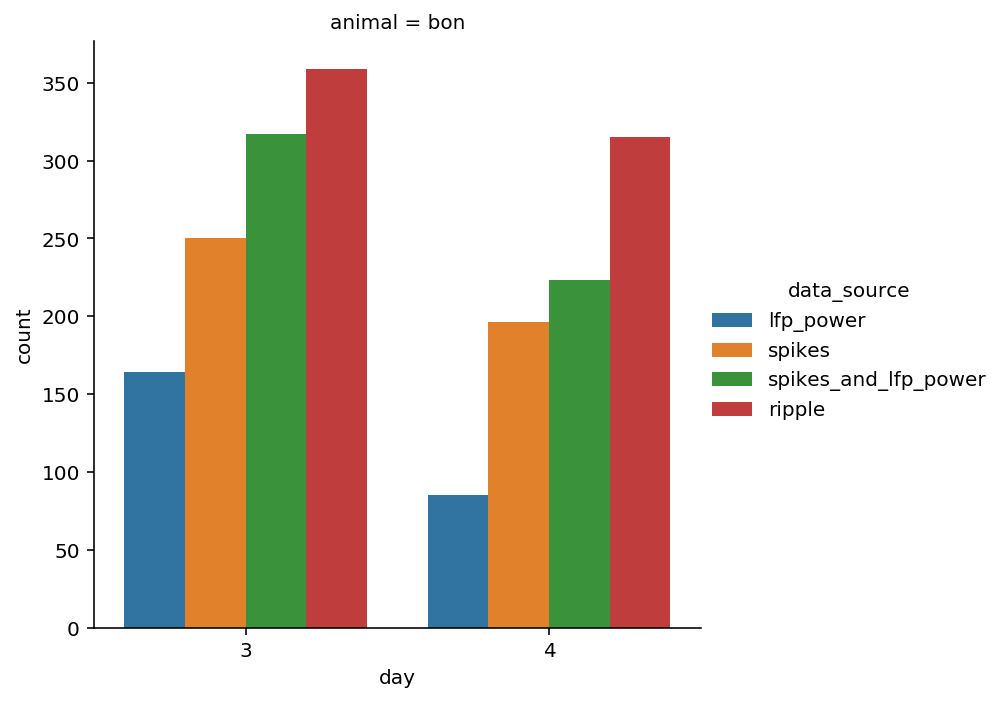

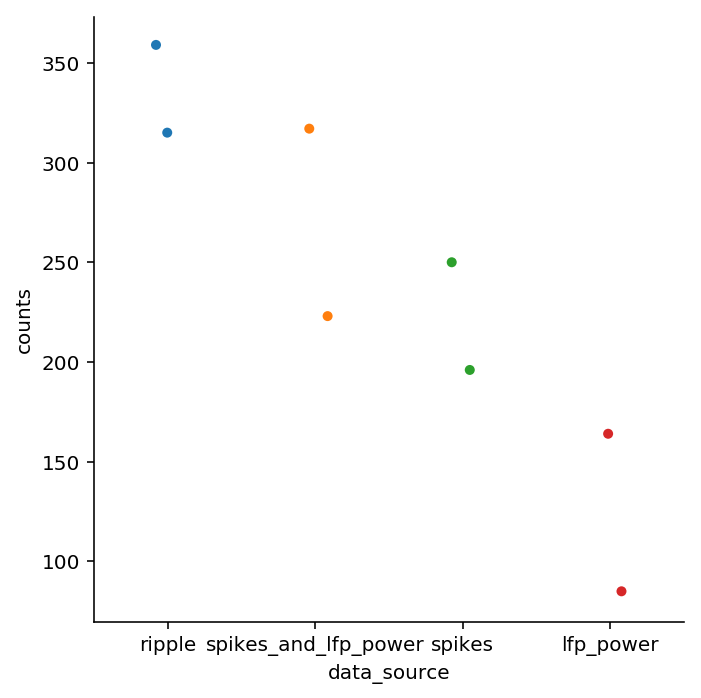

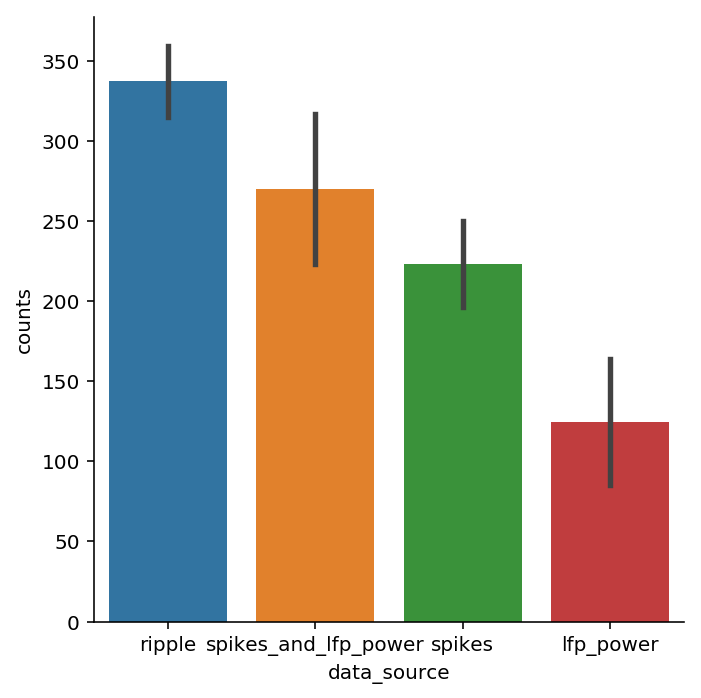

In [236]:
import seaborn as sns
# Compare number of events
sns.catplot(x='day', data=replay_info, kind='count', hue='data_source', col='animal')


# Compare number of events per day
df = (replay_info['data_source']
      .groupby(replay_info['day'])
      .value_counts()
      .rename('counts')
      .reset_index()
     )
sns.catplot(x='data_source', y='counts', data=df)
sns.catplot(x='data_source', y='counts', data=df, kind='bar')

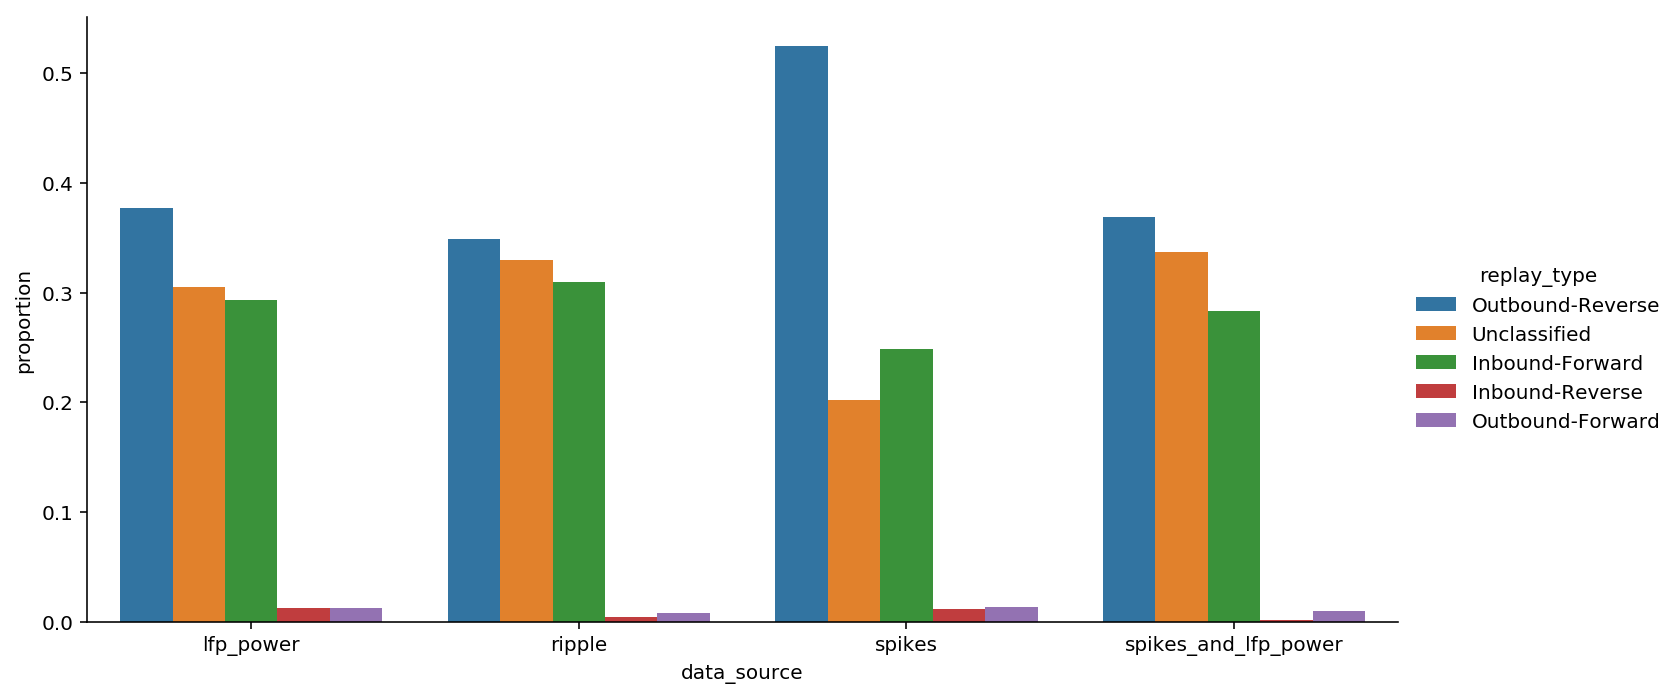

In [224]:
# Compare replay types count (inbound vs. outbound, forward vs. reverse)

# sns.catplot(x='data_source', data=replay_info, kind='count', hue='replay_type', col='animal', aspect=2)

prop_df = (replay_info['replay_type']
           .groupby(replay_info['data_source'])
           .value_counts(normalize=True)
           .rename('proportion')
           .reset_index())

sns.catplot(x='data_source', y='proportion', hue='replay_type', data=prop_df, kind='bar', aspect=2)

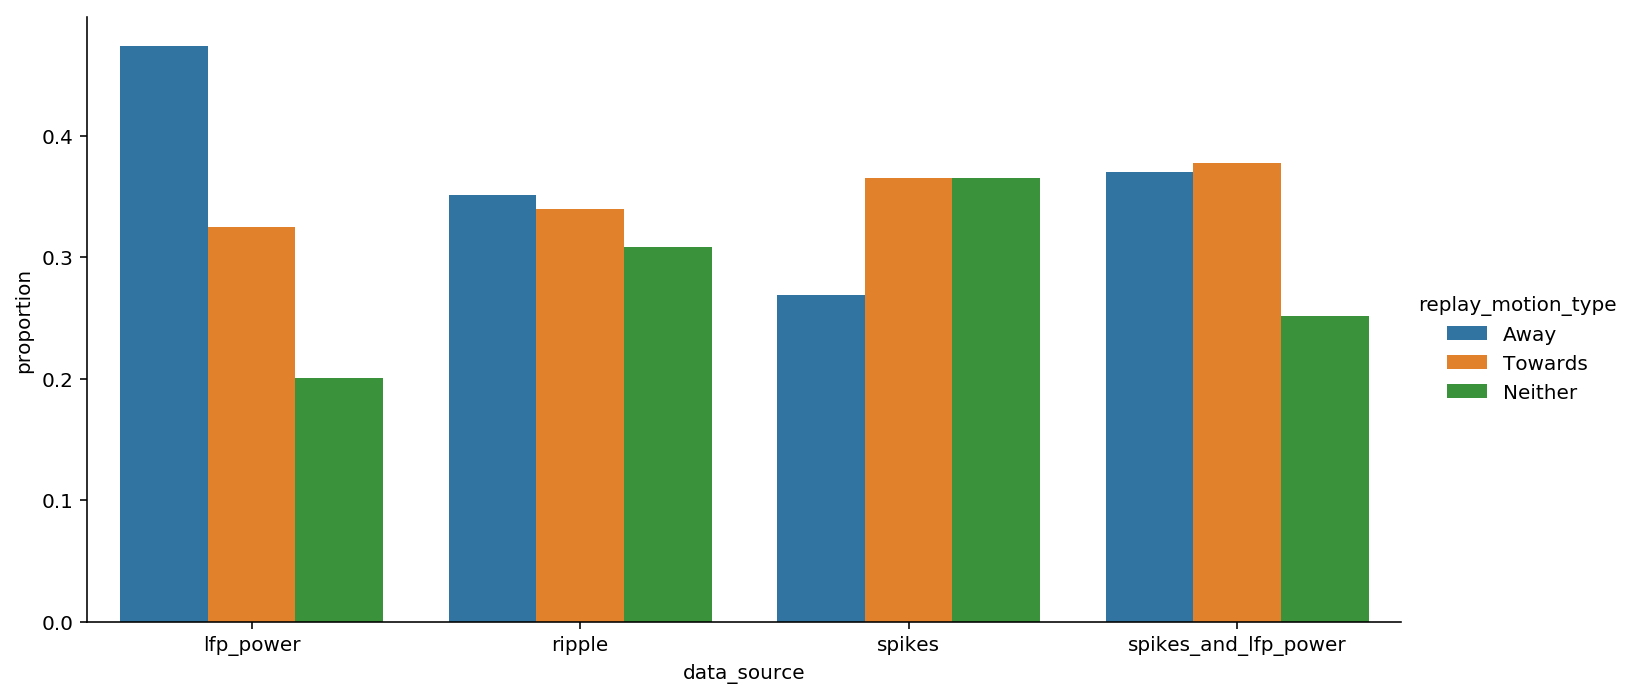

In [223]:
# Compare replay motion count (towards vs. away animal position)
# sns.catplot(x='data_source', data=replay_info, kind='count', hue='replay_motion_type', col='animal', aspect=2)

prop_df = (replay_info['replay_motion_type']
           .groupby(replay_info['data_source'])
           .value_counts(normalize=True)
           .rename('proportion')
           .reset_index())

sns.catplot(x='data_source', y='proportion', hue='replay_motion_type', data=prop_df, kind='bar', aspect=2)

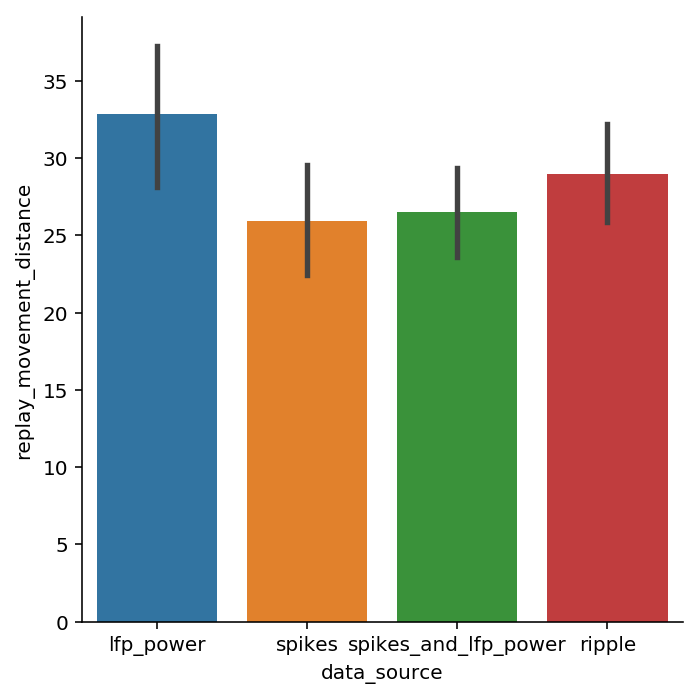

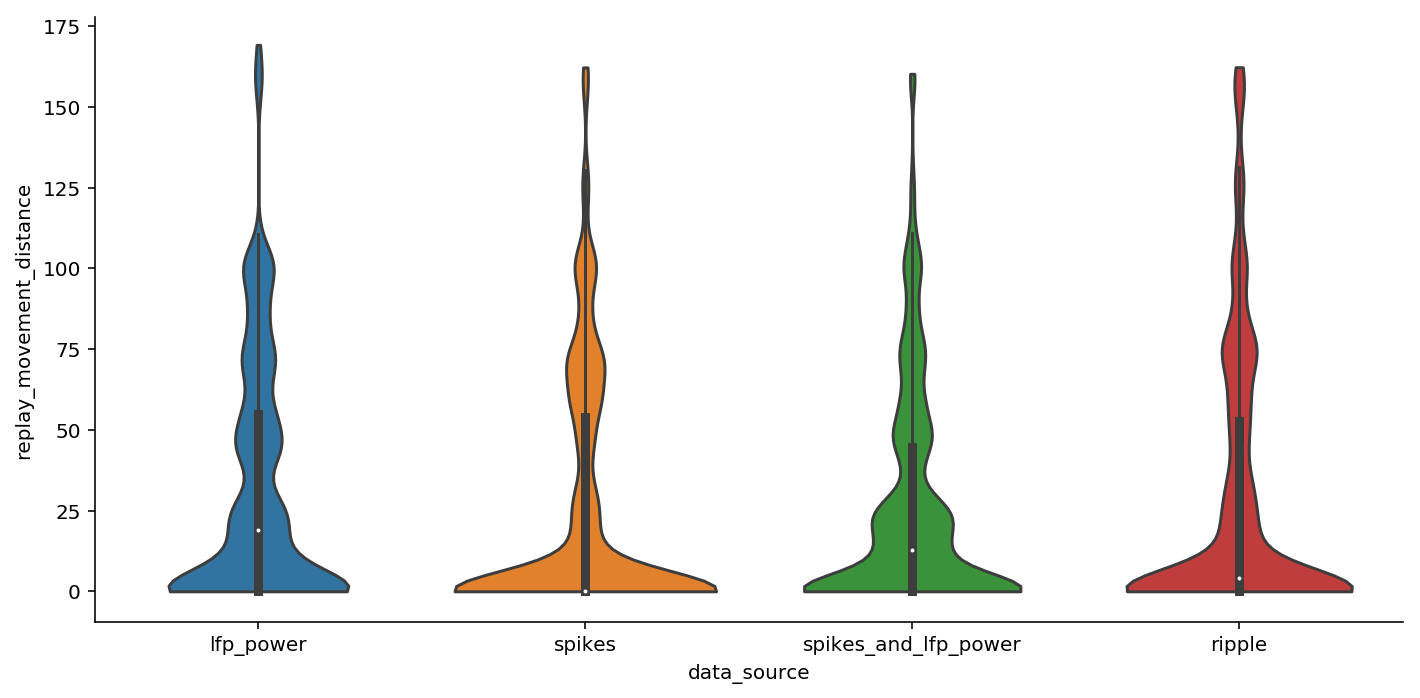

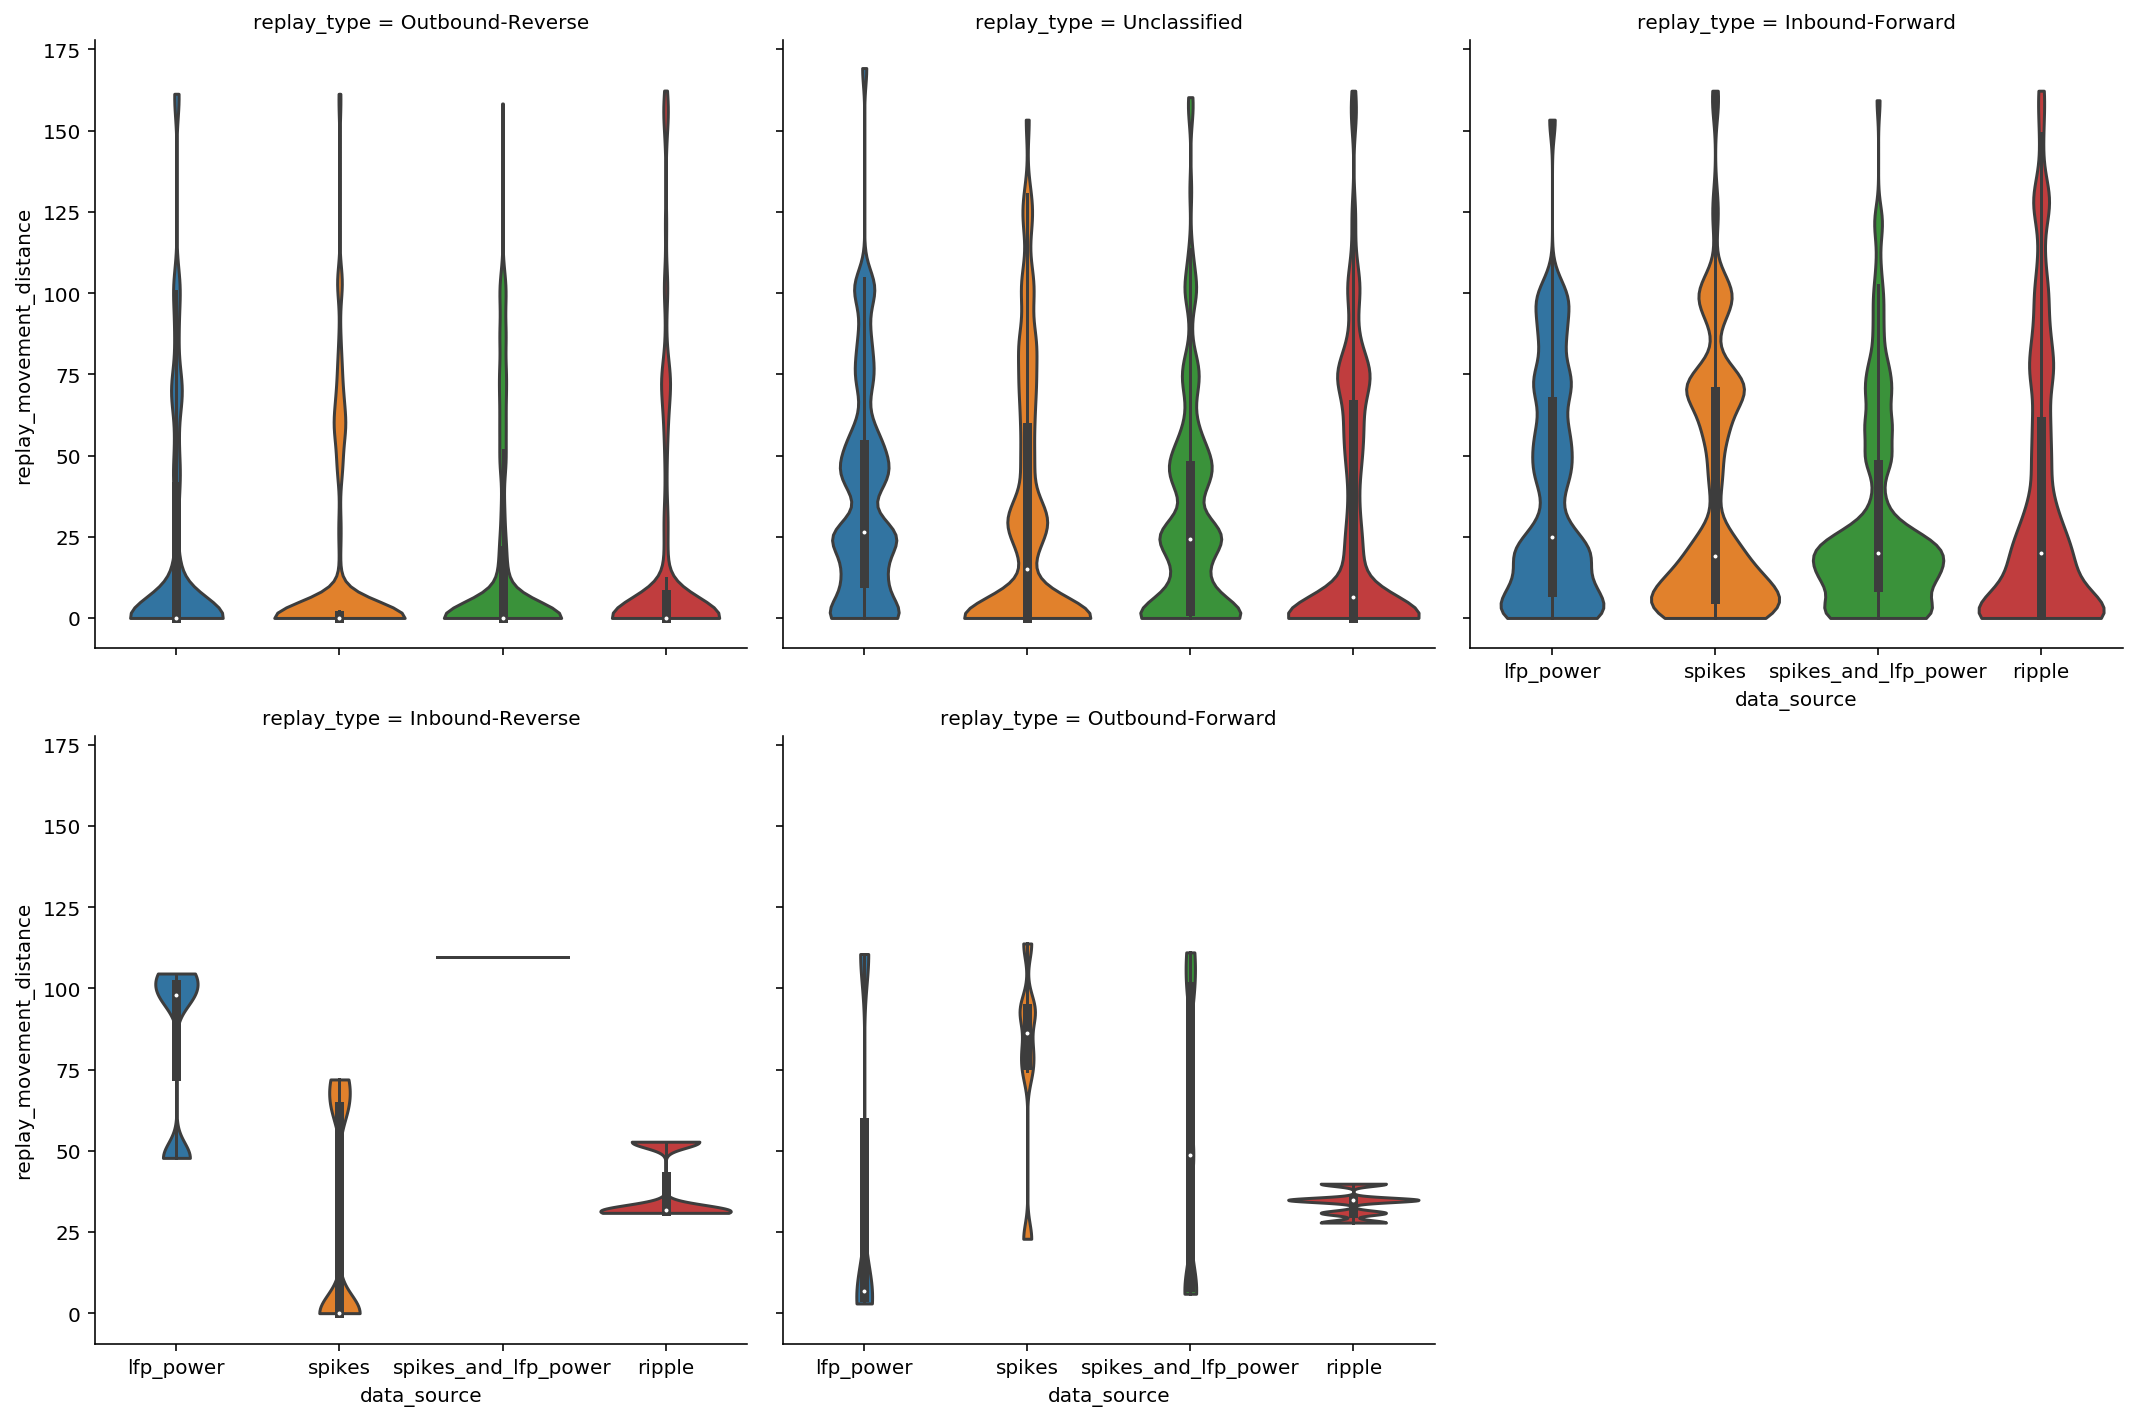

In [201]:
# Compare how far the replay position moves.
sns.catplot(x='data_source', y='replay_movement_distance', data=replay_info, aspect=1,
            kind='bar')
sns.catplot(x='data_source', y='replay_movement_distance', data=replay_info, aspect=2,
            kind='violin', bw=.15, cut=0)
sns.catplot(x='data_source', y='replay_movement_distance', data=replay_info, aspect=1,
            kind='violin', bw=.15, cut=0, col='replay_type', col_wrap=3)

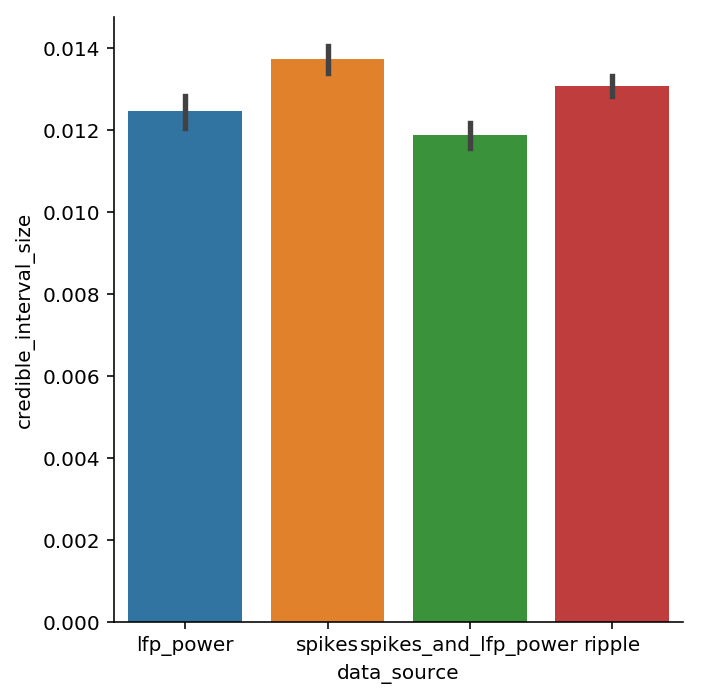

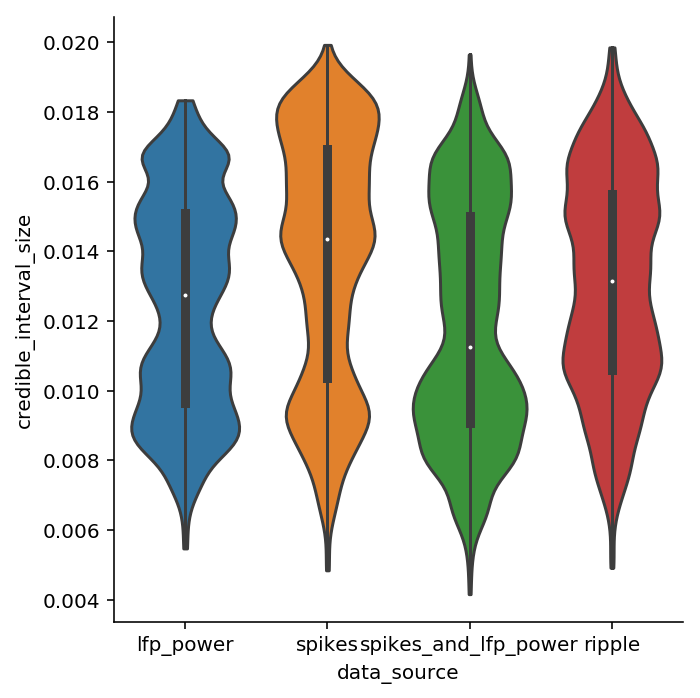

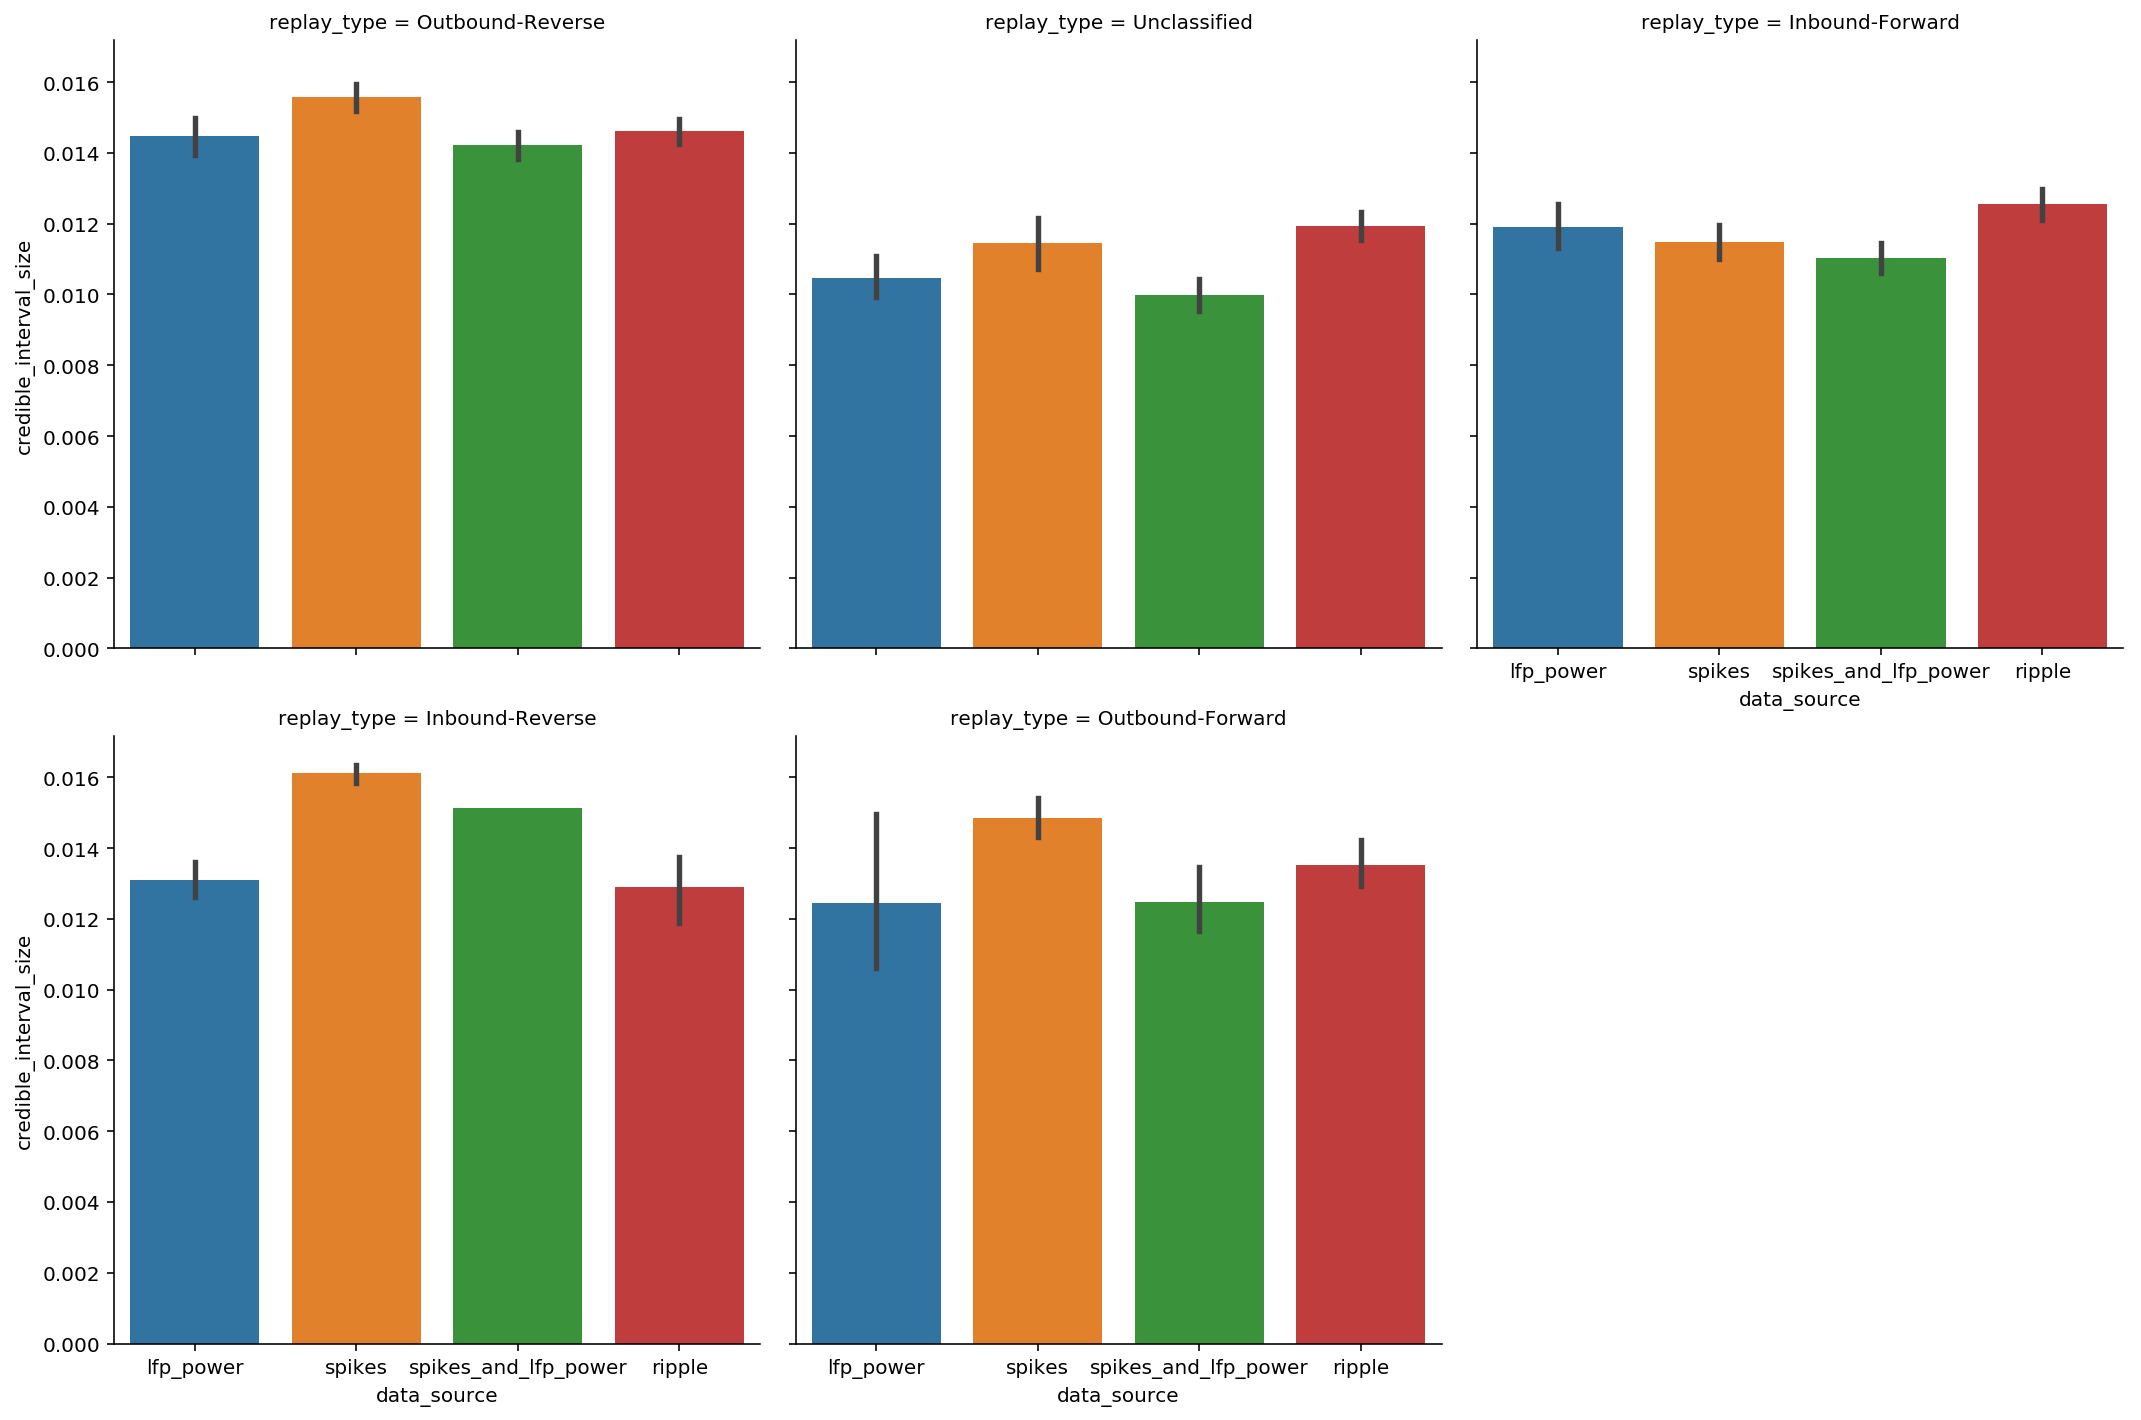

In [204]:
# Compare width of the posterior confidence bounds
# Compare how far the replay position moves.
sns.catplot(x='data_source', y='credible_interval_size', data=replay_info, aspect=1,
            kind='bar')
sns.catplot(x='data_source', y='credible_interval_size', data=replay_info, aspect=1,
            kind='violin', bw=.15, cut=0)
sns.catplot(x='data_source', y='credible_interval_size', data=replay_info, aspect=1,
            kind='bar', col='replay_type', col_wrap=3)

In [226]:
sns.catplot(x='data_source', y='duration', data=replay_info, aspect=1,
            kind='bar')

TypeError: float() argument must be a string or a number, not 'Timedelta'

In [4]:
import itertools
import sys
from os.path import join

import xarray as xr

from src.parameters import PROCESSED_DATA_DIR, USE_LIKELIHOODS

filenames = join(PROCESSED_DATA_DIR, '*.nc')

names = list(USE_LIKELIHOODS.keys())
n_data_sources = len(USE_LIKELIHOODS)
names_ind = np.arange(n_data_sources)
confusion_matrix = np.eye(n_data_sources) * 0.5
start_time_difference = np.zeros((n_data_sources, n_data_sources))
end_time_difference = np.zeros((n_data_sources, n_data_sources))

combination = itertools.combinations(names, 2)
combination_ind = itertools.combinations(names_ind, 2)
overlap_info = []

for (name1, name2), (ind1, ind2) in zip(combination, combination_ind):
    df = xr.open_mfdataset(
        filenames, group=f'/overlap/{name1}/{name2}', autoclose=True
    ).to_dataframe()
    df['data_source1'] = name1
    overlap_info['data_source2'] = name2
    overlap_info.append(df)

overlap_info = pd.concat(overlap_info)

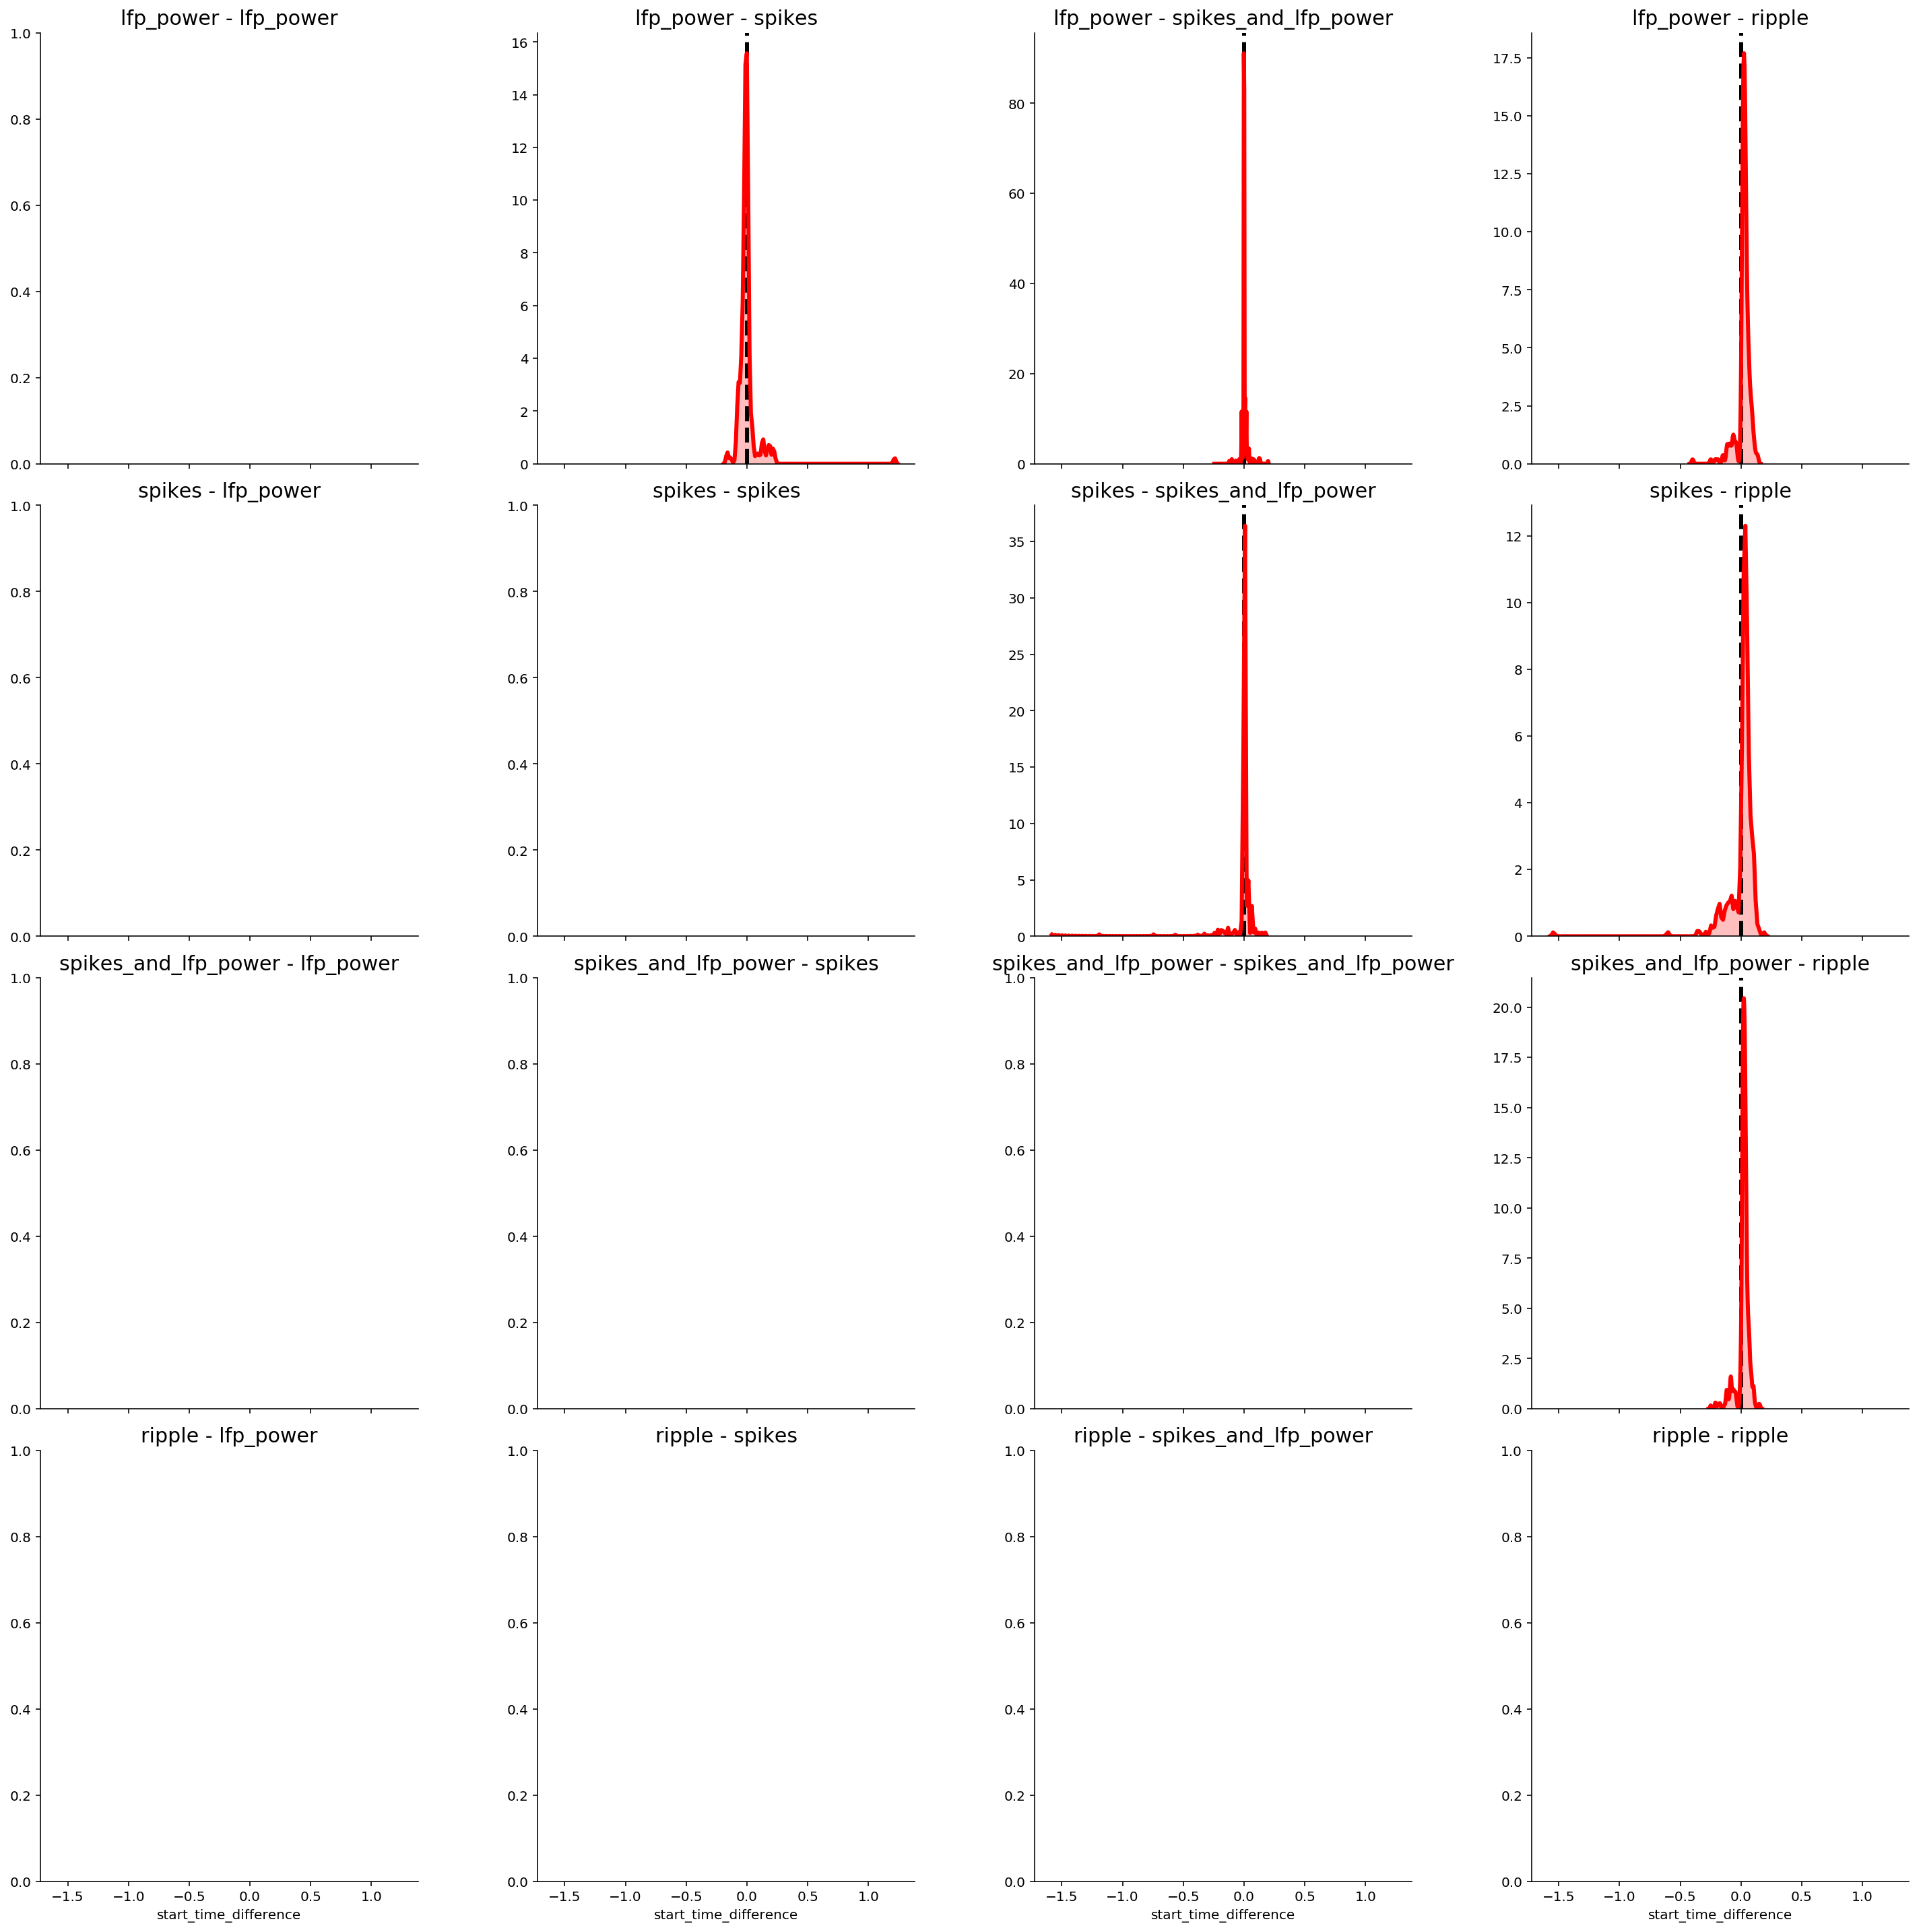

In [231]:
import seaborn as sns
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names, sharey=False)
g.map(plt.axvline, x=0, color="k", linestyle="--", linewidth=3);
g.map(sns.distplot, "start_time_difference", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'shade': True}).set_titles("{row_name} - {col_name}", size=15);

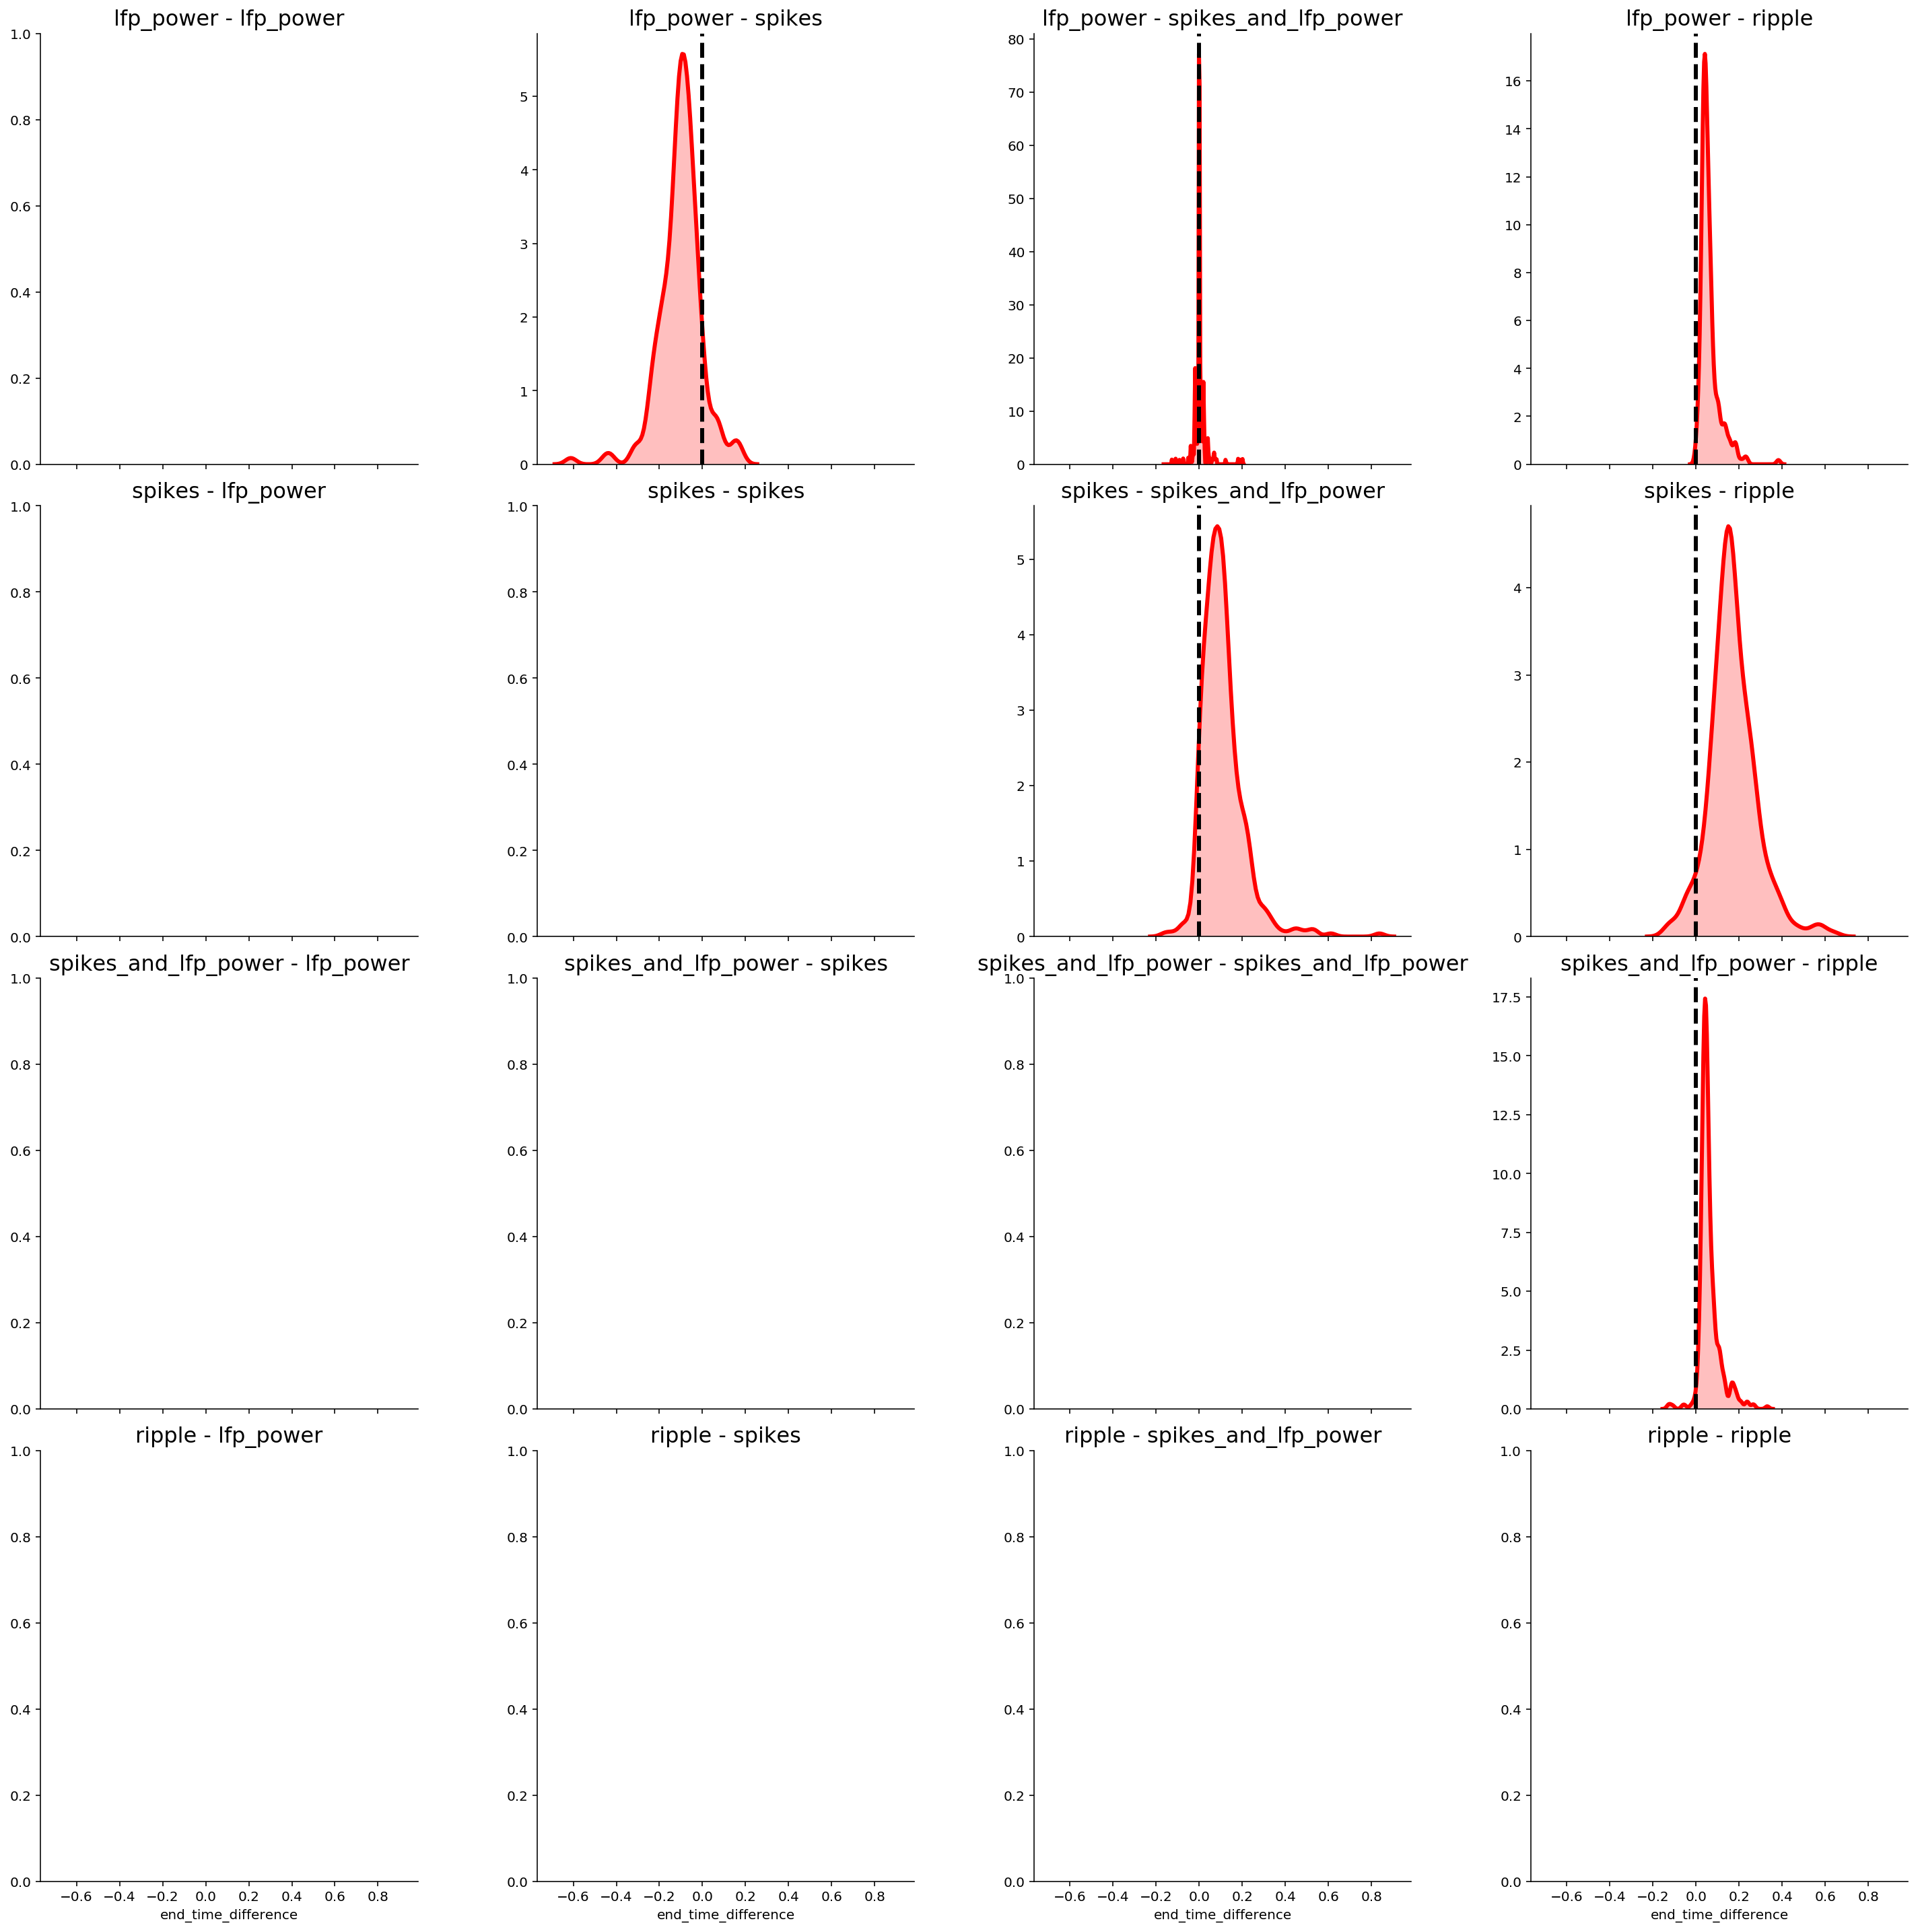

In [232]:
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names, sharey=False)
g.map(plt.axvline, x=0, color="k", linestyle="--", linewidth=3, zorder=100)
g.map(sns.distplot, "end_time_difference", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'shade': True}).set_titles("{row_name} - {col_name}", size=16);


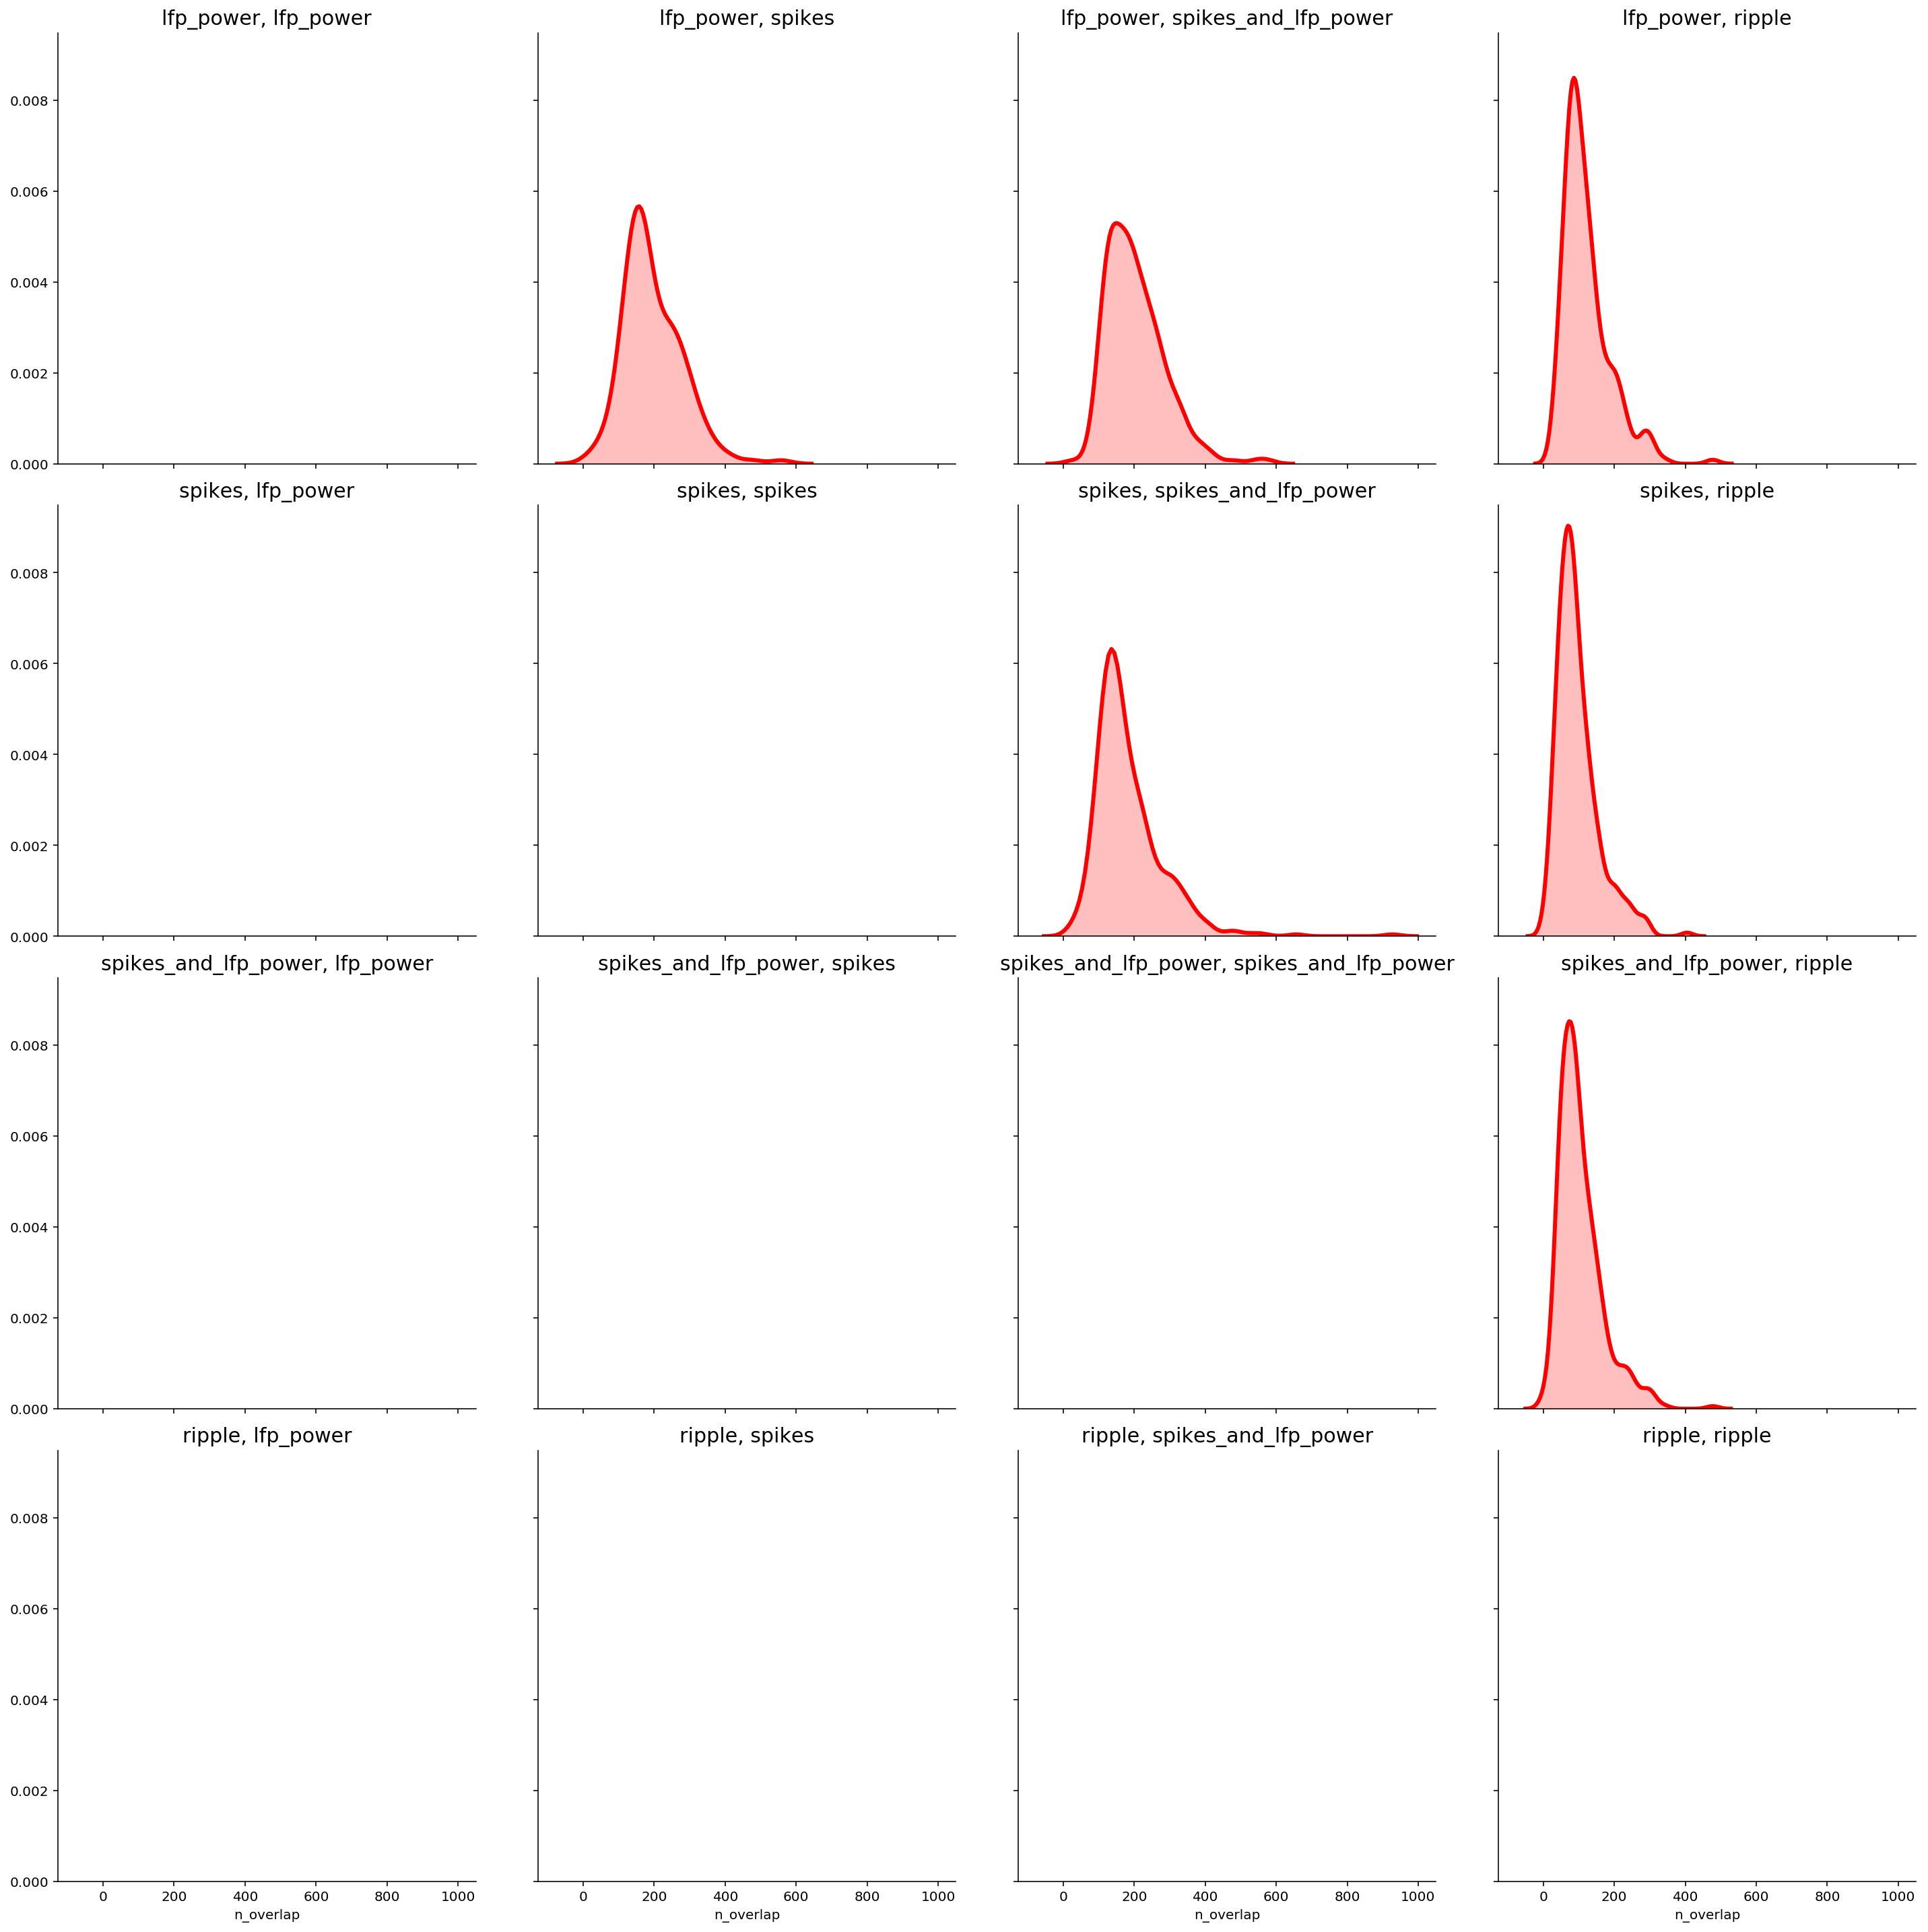

In [224]:
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names)
g.map(sns.distplot, "n_overlap", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'shade': True}).set_titles("{row_name}, {col_name}", size=15);


In [99]:
overlap_info = overlap_info.assign(jaccard=overlap_info.n_overlap /
           (overlap_info.total_labels1 + overlap_info.total_labels2 - overlap_info.n_overlap))

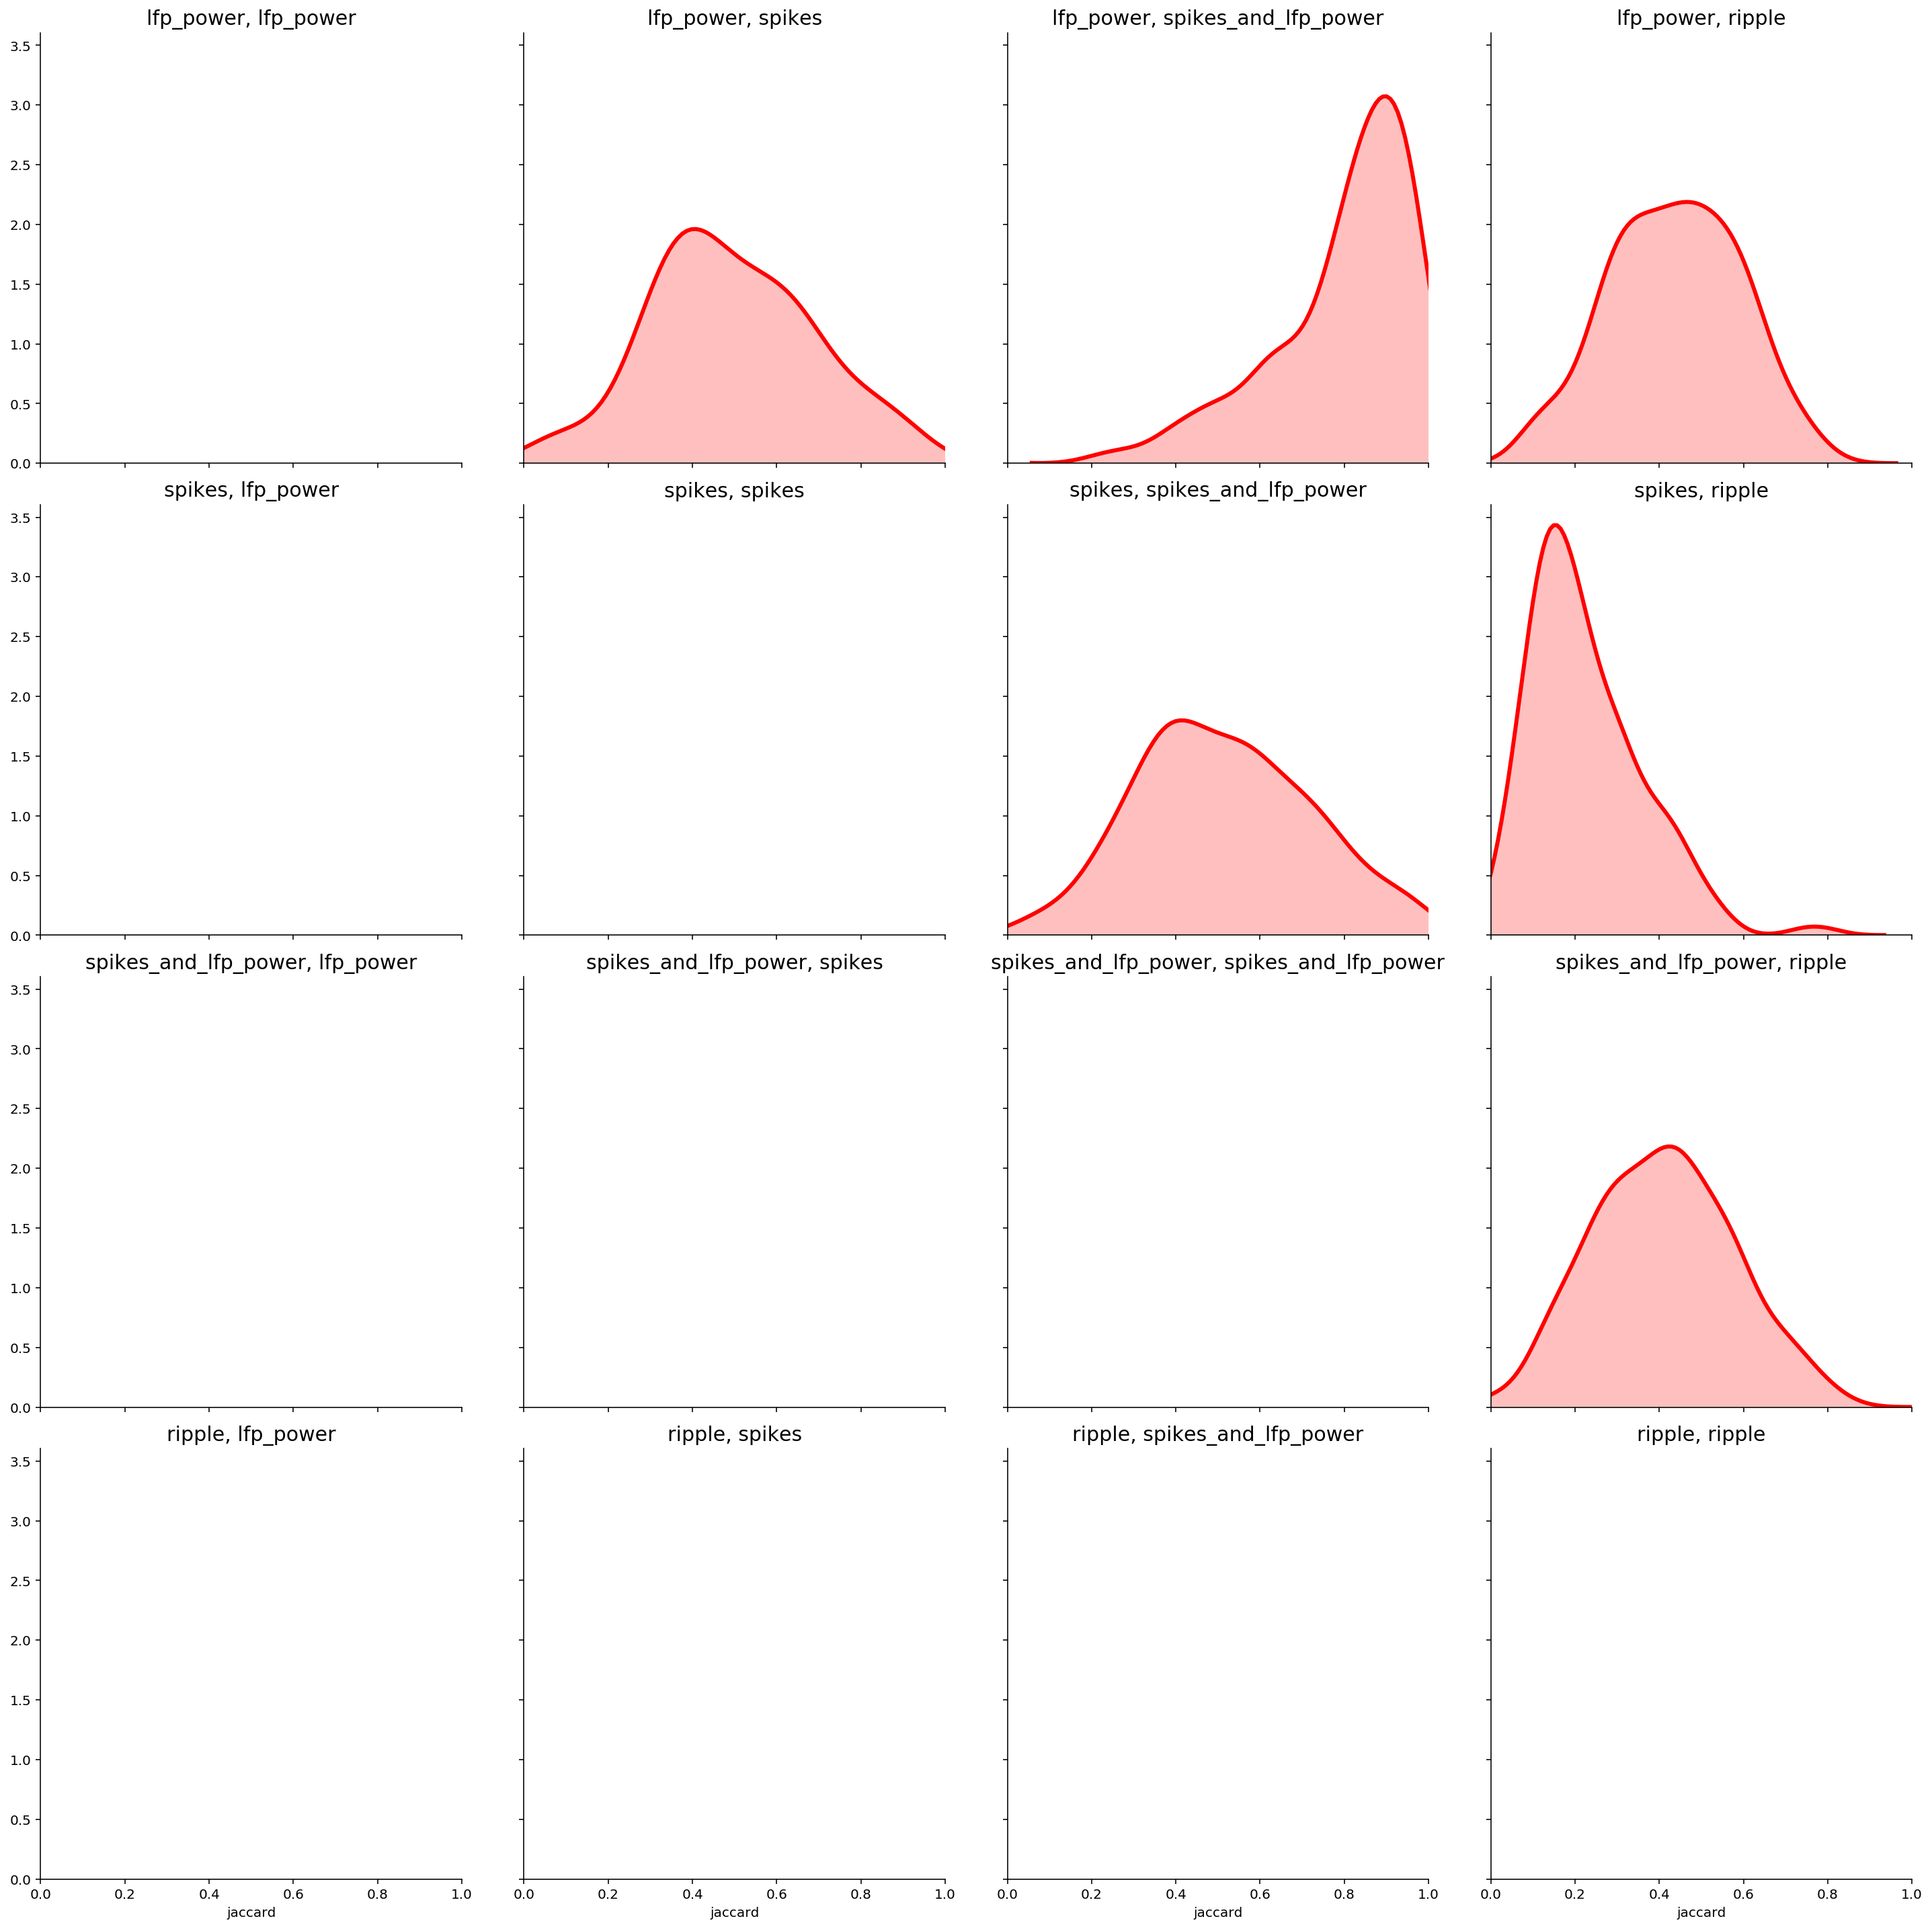

In [233]:
g = sns.FacetGrid(data=overlap_info,  row='data_source1', col='data_source2', height=5, aspect=1,
                  row_order=names, col_order=names)
g.map(sns.distplot, "jaccard", hist=False, rug=False,
      kde_kws={"color": "red", "lw": 3, 'clip': (0, 1), 'shade': True}
     ).set_titles("{row_name}, {col_name}", size=15);
g.set(xlim=(0, 1))

In [209]:

new_index = pd.MultiIndex.from_product((names, names), names=['data_source1', 'data_source2'])
n_overlap = (overlap_info
              .loc[:, ['data_source1', 'data_source2']]
              .groupby(['data_source1', 'data_source2'])
              .agg(len)
              .rename('n_overlap')
              .to_frame()
              .reindex(new_index, fill_value=0.0)
             .sort_index()
            )

n_overlap

n_overlap
data_source1         data_source2                   
lfp_power            lfp_power                   0.0
                     ripple                    252.0
                     spikes                    186.0
                     spikes_and_lfp_power      243.0
ripple               lfp_power                   0.0
                     ripple                      0.0
                     spikes                      0.0
                     spikes_and_lfp_power        0.0
spikes               lfp_power                   0.0
                     ripple                    315.0
                     spikes                      0.0
                     spikes_and_lfp_power      418.0
spikes_and_lfp_power lfp_power                   0.0
                     ripple                    406.0
                     spikes                      0.0
                     spikes_and_lfp_power        0.0

In [340]:
n_overlap = (overlap_info
              .loc[:, ['data_source1', 'data_source2']]
              .groupby(['data_source1', 'data_source2'])
              .agg(len)
              .to_xarray()
              .reindex({'data_source1': names, 'data_source2': names})
            )

n_overlap

<xarray.DataArray (data_source1: 4, data_source2: 4)>
array([[ nan, 186., 243., 252.],
       [ nan,  nan, 418., 315.],
       [ nan,  nan,  nan, 406.],
       [ nan,  nan,  nan,  nan]])
Coordinates:
  * data_source1  (data_source1) <U20 'lfp_power' 'spikes' ... 'ripple'
  * data_source2  (data_source2) <U20 'lfp_power' 'spikes' ... 'ripple'

In [335]:


n_total = replay_info.loc[:, 'data_source'].value_counts().reindex(names)

n_total1 = n_total.copy().rename('n_total1')
n_total1.index = n_total1.index.rename('data_source1')


n_total2 = n_total.copy().rename('n_total2')
n_total2.index = n_total2.index.rename('data_source2')
n_total2

data_source2
lfp_power               249
spikes                  446
spikes_and_lfp_power    540
ripple                  674
Name: n_total2, dtype: int64

In [323]:
n_overlap += n_overlap.T.values + np.eye(len(names)) * n_total.values

In [326]:
jaccard_similarity = n_overlap / (n_total1.to_xarray() + n_total2.to_xarray() - n_overlap)
jaccard_similarity.rename('jaccard_similarity')

<xarray.DataArray 'jaccard_similarity' (data_source1: 4, data_source2: 4)>
array([[1.      , 0.365422, 0.445055, 0.375559],
       [0.365422, 1.      , 0.735915, 0.391304],
       [0.445055, 0.735915, 1.      , 0.502475],
       [0.375559, 0.391304, 0.502475, 1.      ]])
Coordinates:
  * data_source1  (data_source1) <U20 'lfp_power' 'spikes' ... 'ripple'
  * data_source2  (data_source2) <U20 'lfp_power' 'spikes' ... 'ripple'

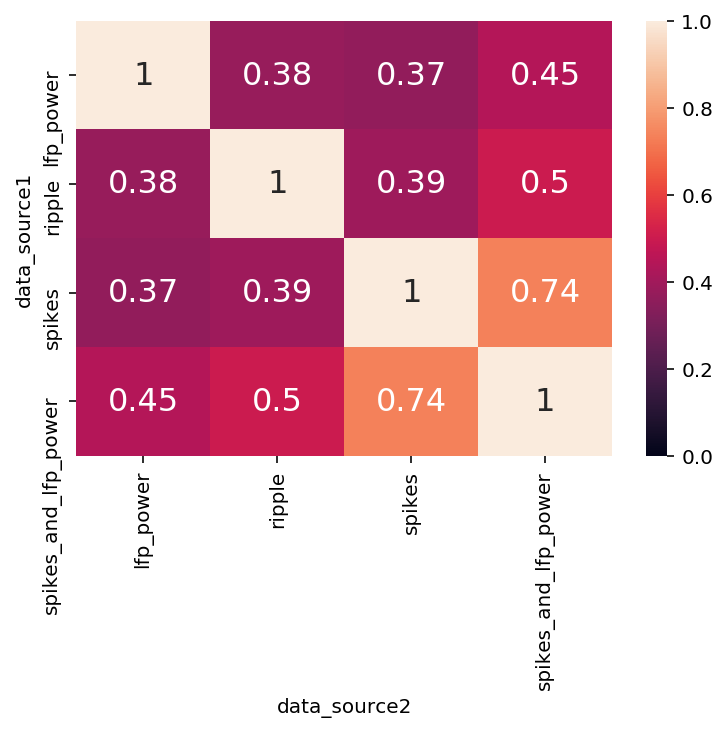

In [357]:
blah = jaccard_similarity.to_dataframe(name='jaccard').unstack()
blah.columns = blah.columns.droplevel(0)
sns.heatmap(blah,
            annot=True, annot_kws={'size': 16}, vmin=0.0, vmax=1.0)

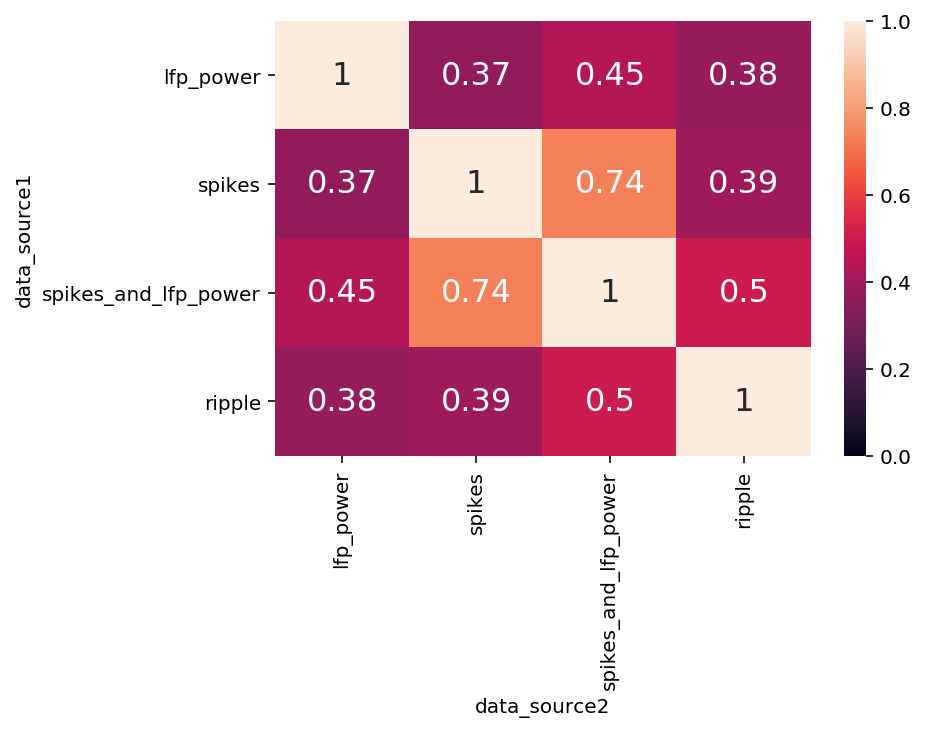

In [361]:
compare_jaccard_similarity_of_replays(overlap_info, replay_info)

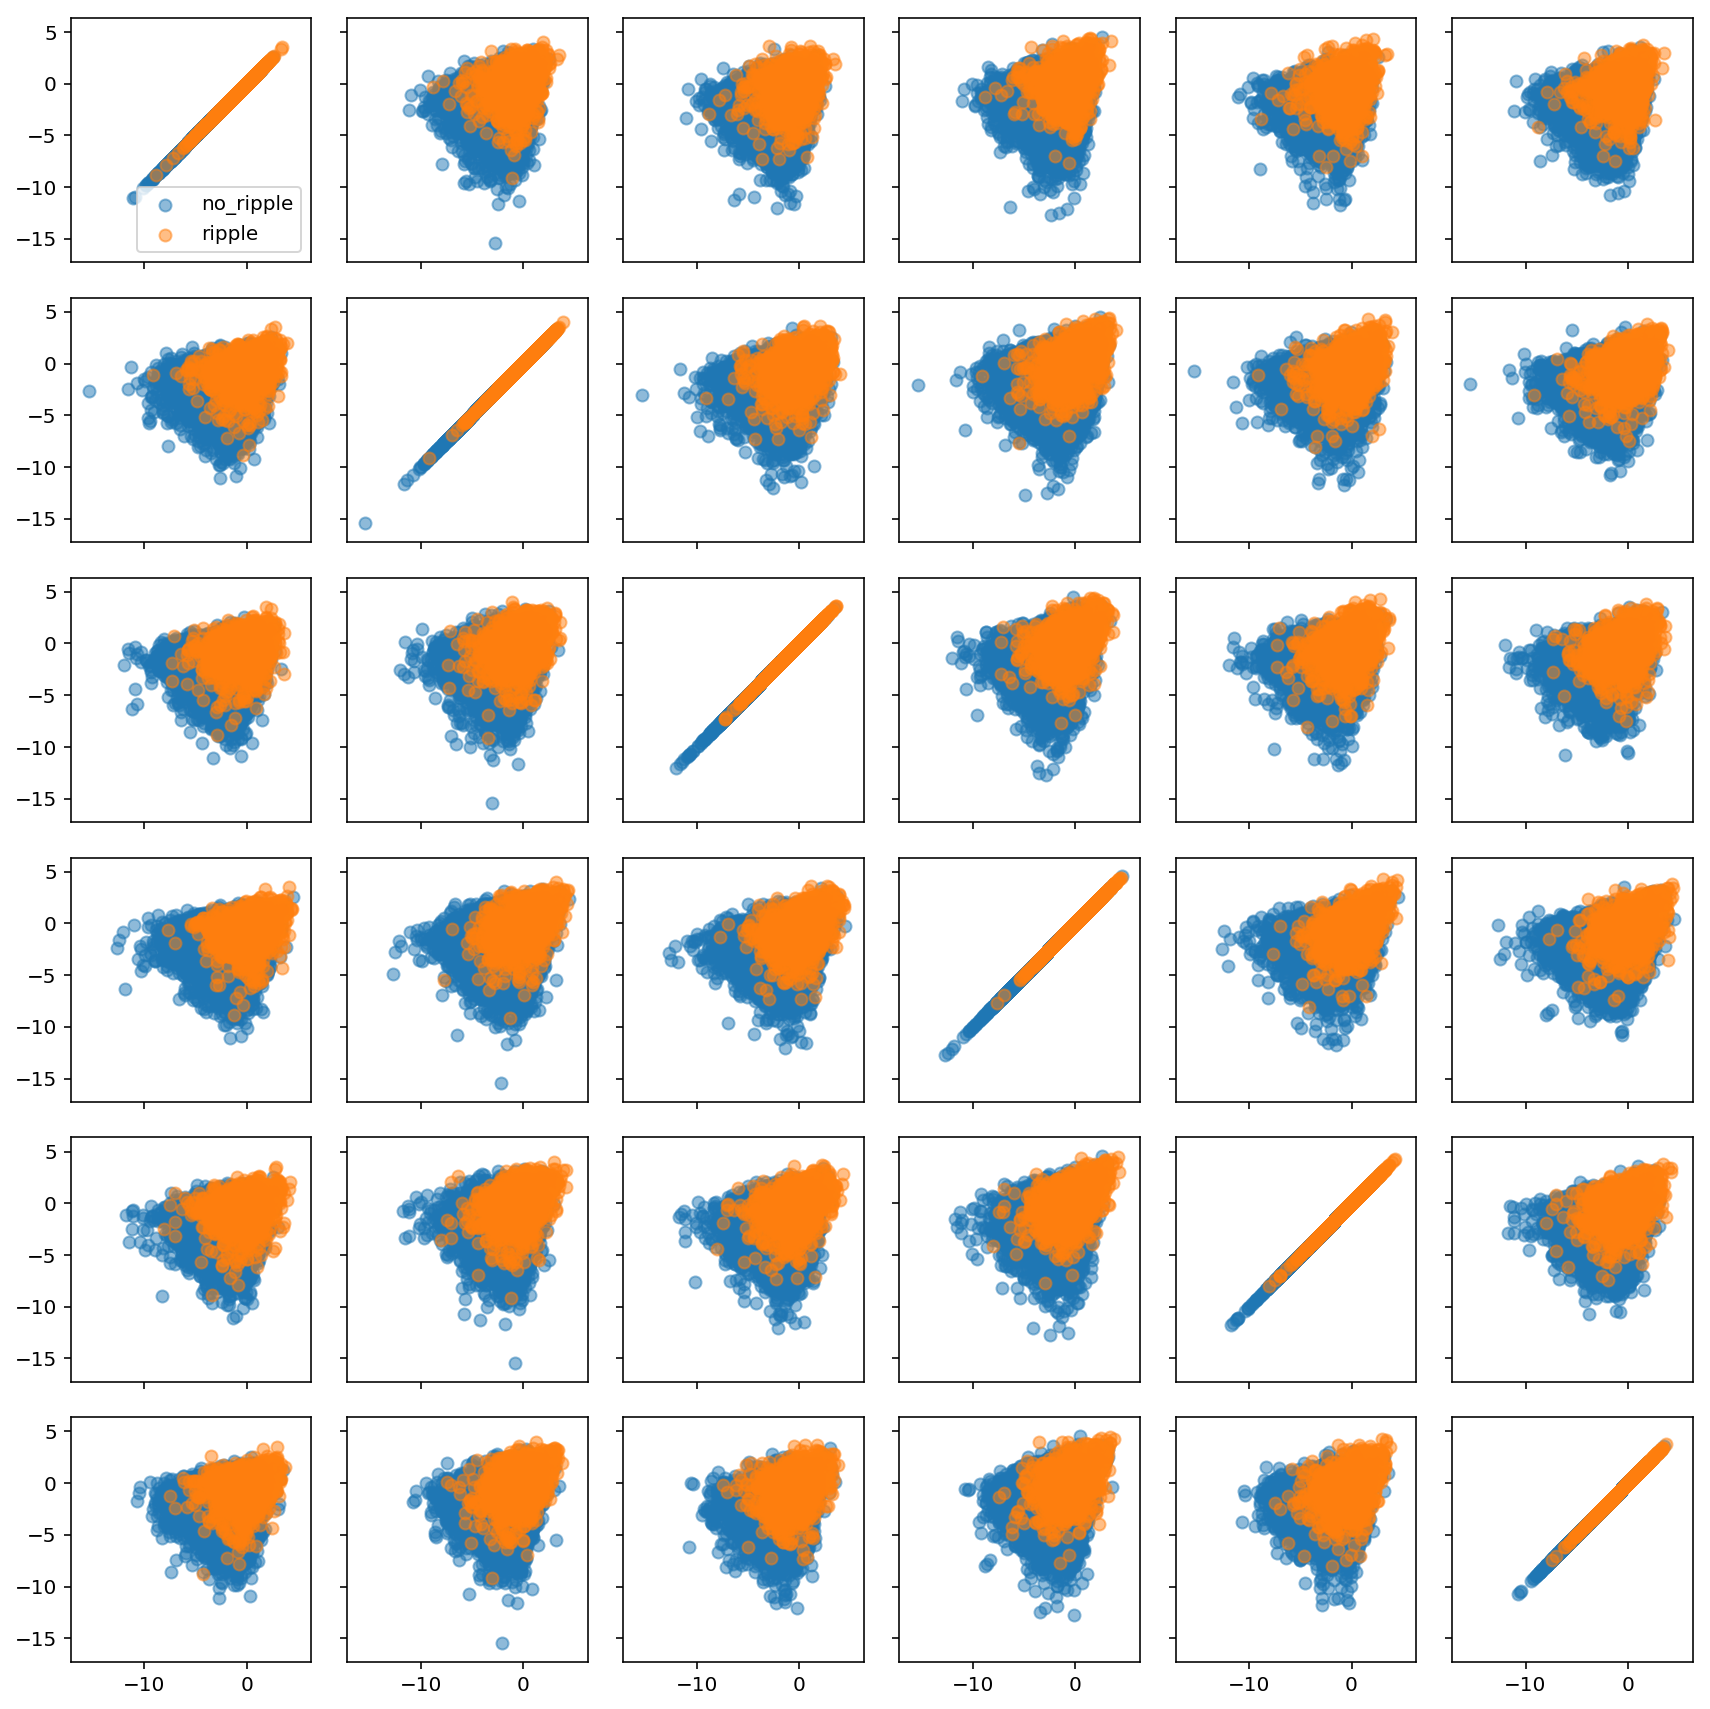

In [409]:
from itertools import product

power = np.log(data['power'].values)
is_ripple = data['is_ripple'].values.squeeze()
n_lfps = power.shape[1]
lfp_ind = np.arange(n_lfps)

fig, axes = plt.subplots(n_lfps, n_lfps, figsize=(2 * n_lfps, 2 * n_lfps),
                         sharex=True, sharey=True)

for ax, (ind1, ind2) in zip(axes.flat, product(lfp_ind, lfp_ind)):
    ax.scatter(power[~is_ripple, ind1], power[~is_ripple, ind2], label='no_ripple', alpha=0.5)
    ax.scatter(power[is_ripple, ind1], power[is_ripple, ind2], label='ripple', alpha=0.5)

axes[0, 0].legend()
plt.tight_layout()

In [438]:
replay_model = replay_detector._lfp_likelihood_ratio.keywords['replay_model']
no_replay_model = replay_detector._lfp_likelihood_ratio.keywords['no_replay_model']

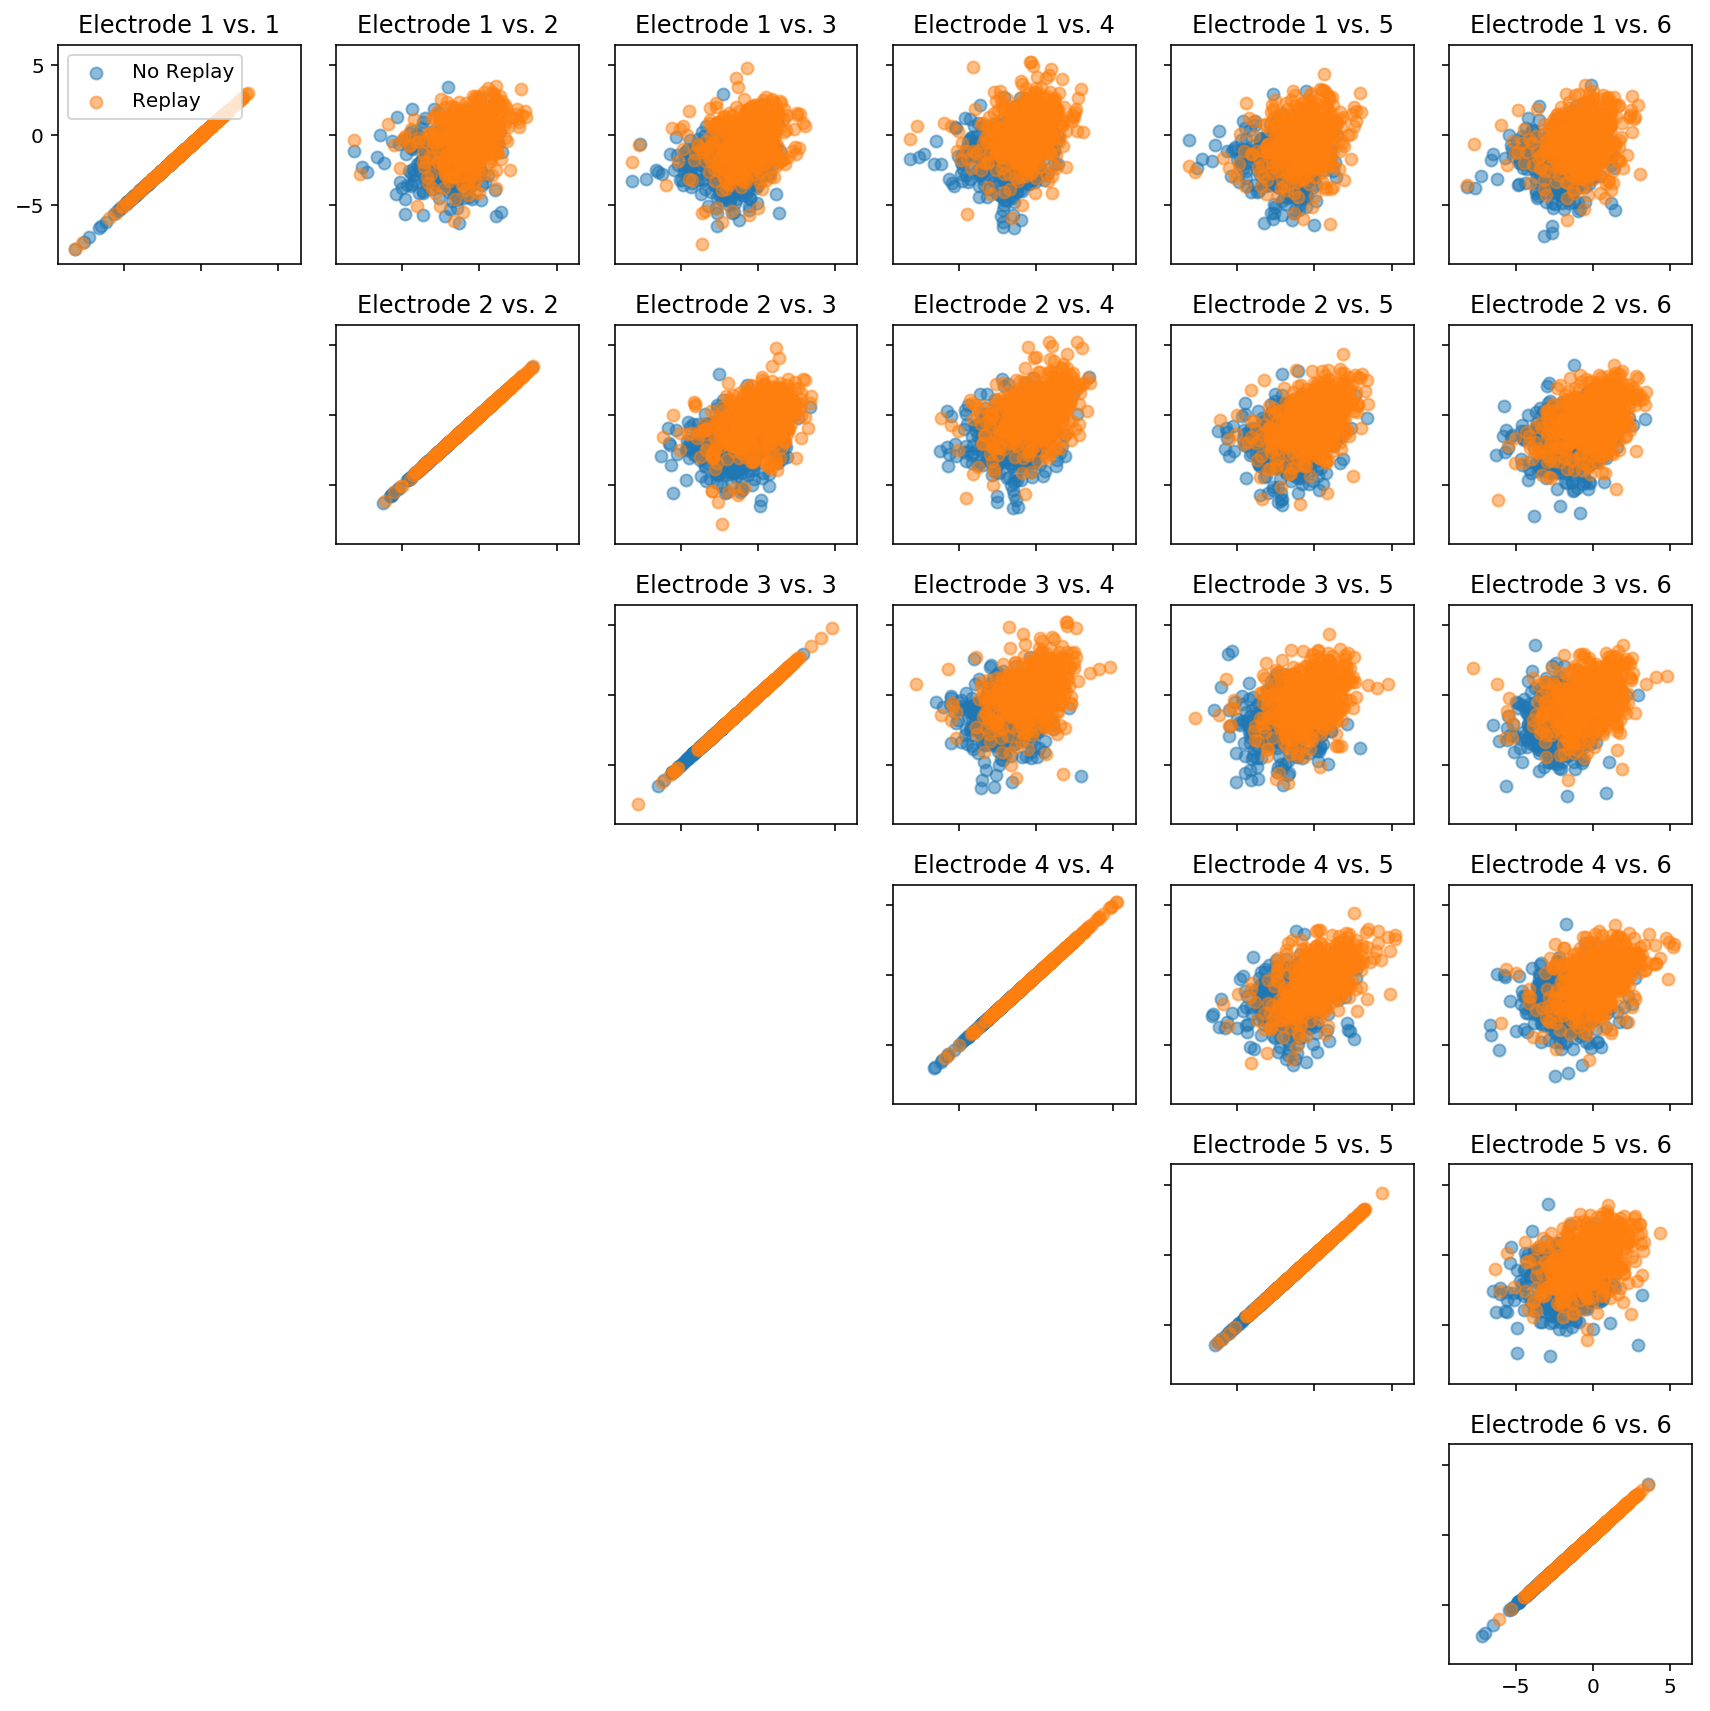

In [462]:
n_samples = 500
samples = np.concatenate(
    (replay_model.sample(n_samples=n_samples)[0],
     no_replay_model.sample(n_samples=n_samples)[0]), axis=0)
r = np.zeros((n_samples * 2,), dtype=bool)
r[:n_samples] = True

plot_lfp_power(np.exp(samples), r)

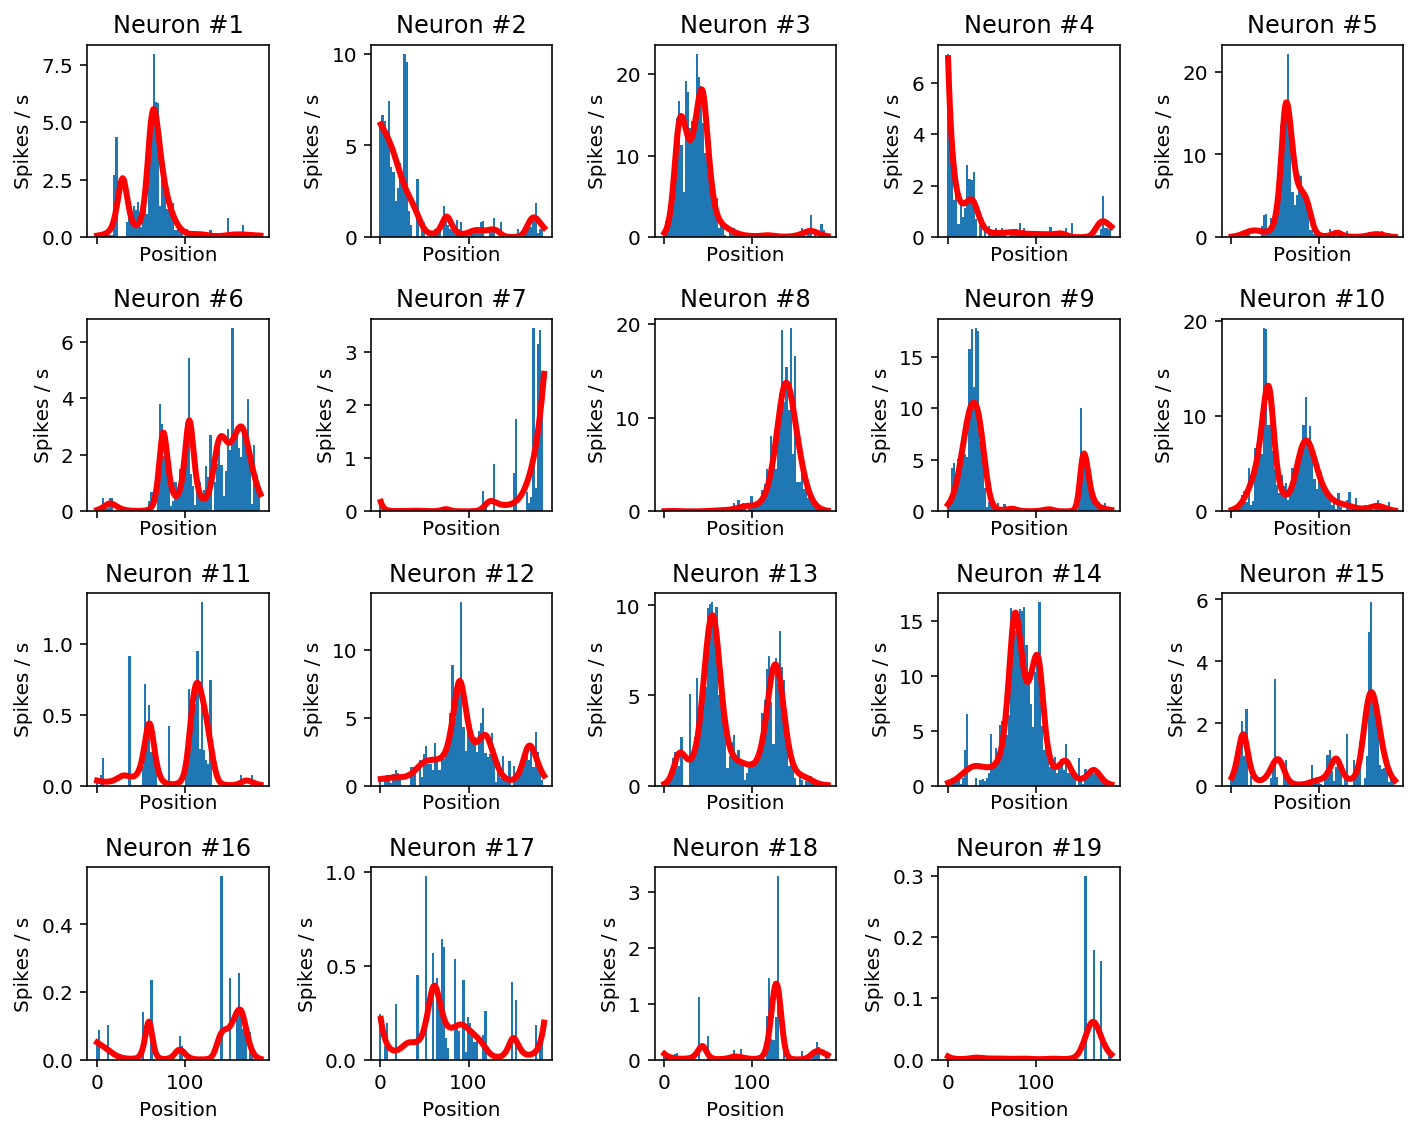

In [554]:
def plot_spikes(spikes, position, is_replay, sampling_frequency=1,
                col_wrap=5, bins='auto'):
    is_replay = np.asarray(is_replay.copy()).squeeze()
    position = np.asarray(position.copy()).squeeze()[~is_replay]
    spikes = np.asarray(spikes.copy())[~is_replay]

    position_occupancy, bin_edges = np.histogram(position, bins=bins)
    bin_size = np.diff(bin_edges)[0]

    time_ind, neuron_ind = np.nonzero(spikes)
    n_neurons = spikes.shape[1]

    n_rows = np.ceil(n_neurons / col_wrap).astype(np.int)

    fig, axes = plt.subplots(n_rows, col_wrap, sharex=True,
                             figsize=(col_wrap * 2, n_rows * 2))

    for ind, ax in enumerate(axes.flat):
        if ind < n_neurons:
            hist, _ = np.histogram(position[time_ind[neuron_ind == ind]],
                                   bins=bin_edges)
            rate = sampling_frequency * hist / position_occupancy
            ax.bar(bin_edges[:-1], rate, width=bin_size)
            ax.set_title(f'Neuron #{ind + 1}')
            ax.set_ylabel('Spikes / s')
            ax.set_xlabel('Position')
        else:
            ax.axis('off')


    plt.tight_layout()

    return axes


axes = plot_spikes(data['spikes'], data['position_info'].linear_distance, data['is_ripple'], SAMPLING_FREQUENCY)

place_conditional_intensity = (
    replay_detector._spiking_likelihood_ratio
    .keywords['place_conditional_intensity']).squeeze()
n_neurons = place_conditional_intensity.shape[1]
n_rows = np.ceil(n_neurons / col_wrap).astype(np.int)

if axes is None:
    fig, axes = plt.subplots(n_rows, col_wrap, sharex=True,
                             figsize=(col_wrap * 2, n_rows * 2))

for ind, ax in enumerate(axes.flat):
    if ind < n_neurons:
        ax.plot(replay_detector.place_bin_centers,
                place_conditional_intensity[:, ind] *
                sampling_frequency, color='red', linewidth=3,
                        )
        ax.set_title(f'Neuron #{ind + 1}')
        ax.set_ylabel('Spikes / s')
        ax.set_xlabel('Position')
    else:
        ax.axis('off')
plt.tight_layout()

In [8]:
import itertools
import logging
import sys
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from src.parameters import FIGURE_DIR, PROCESSED_DATA_DIR, USE_LIKELIHOODS
from src.visualization import (compare_jaccard_similarity_of_replays,
                               compare_similarity_of_overlapping_replays,
                               compare_time_difference_of_overlapping_replays,
                               plot_continuous_by_data_source,
                               plot_data_source_counts,
                               plot_proportion_events_by_data_source)

COLUMNS = ['animal', 'day', 'epoch',
           'replay_type', 'replay_motion_type', 'replay_movement_distance',
           'credible_interval_size', 'data_source', 'duration']

logging.basicConfig(level='INFO')

filenames = join(PROCESSED_DATA_DIR, '*.nc')
replay_info = pd.concat(
    [xr.open_mfdataset(
        filenames, group=f'{name}/replay_info', autoclose=True
    ).to_dataframe().loc[:, COLUMNS]
        for name in USE_LIKELIHOODS])

names = list(USE_LIKELIHOODS.keys())
combination = itertools.combinations(names, 2)
overlap_info = []

for name1, name2 in combination:
    overlap_info.append(xr.open_mfdataset(
        filenames, group=f'/overlap/{name1}/{name2}', autoclose=True
    ).to_dataframe())

overlap_info = pd.concat(overlap_info)

In [120]:
overlap_info = overlap_info.reset_index()

for name1, name2 in itertools.combinations(l.keys(), 2):
    o = overlap_info.loc[(overlap_info.data_source1 == name1) & (overlap_info.data_source2 == name2)]
    not_overlap_info1 = replay_info.loc[~replay_info.index.isin(o.replay_number2) &
                                        (replay_info.data_source == name1)]
    not_overlap_info2 = replay_info.loc[~replay_info.index.isin(o.replay_number1) &
                                        (replay_info.data_source == name2)]

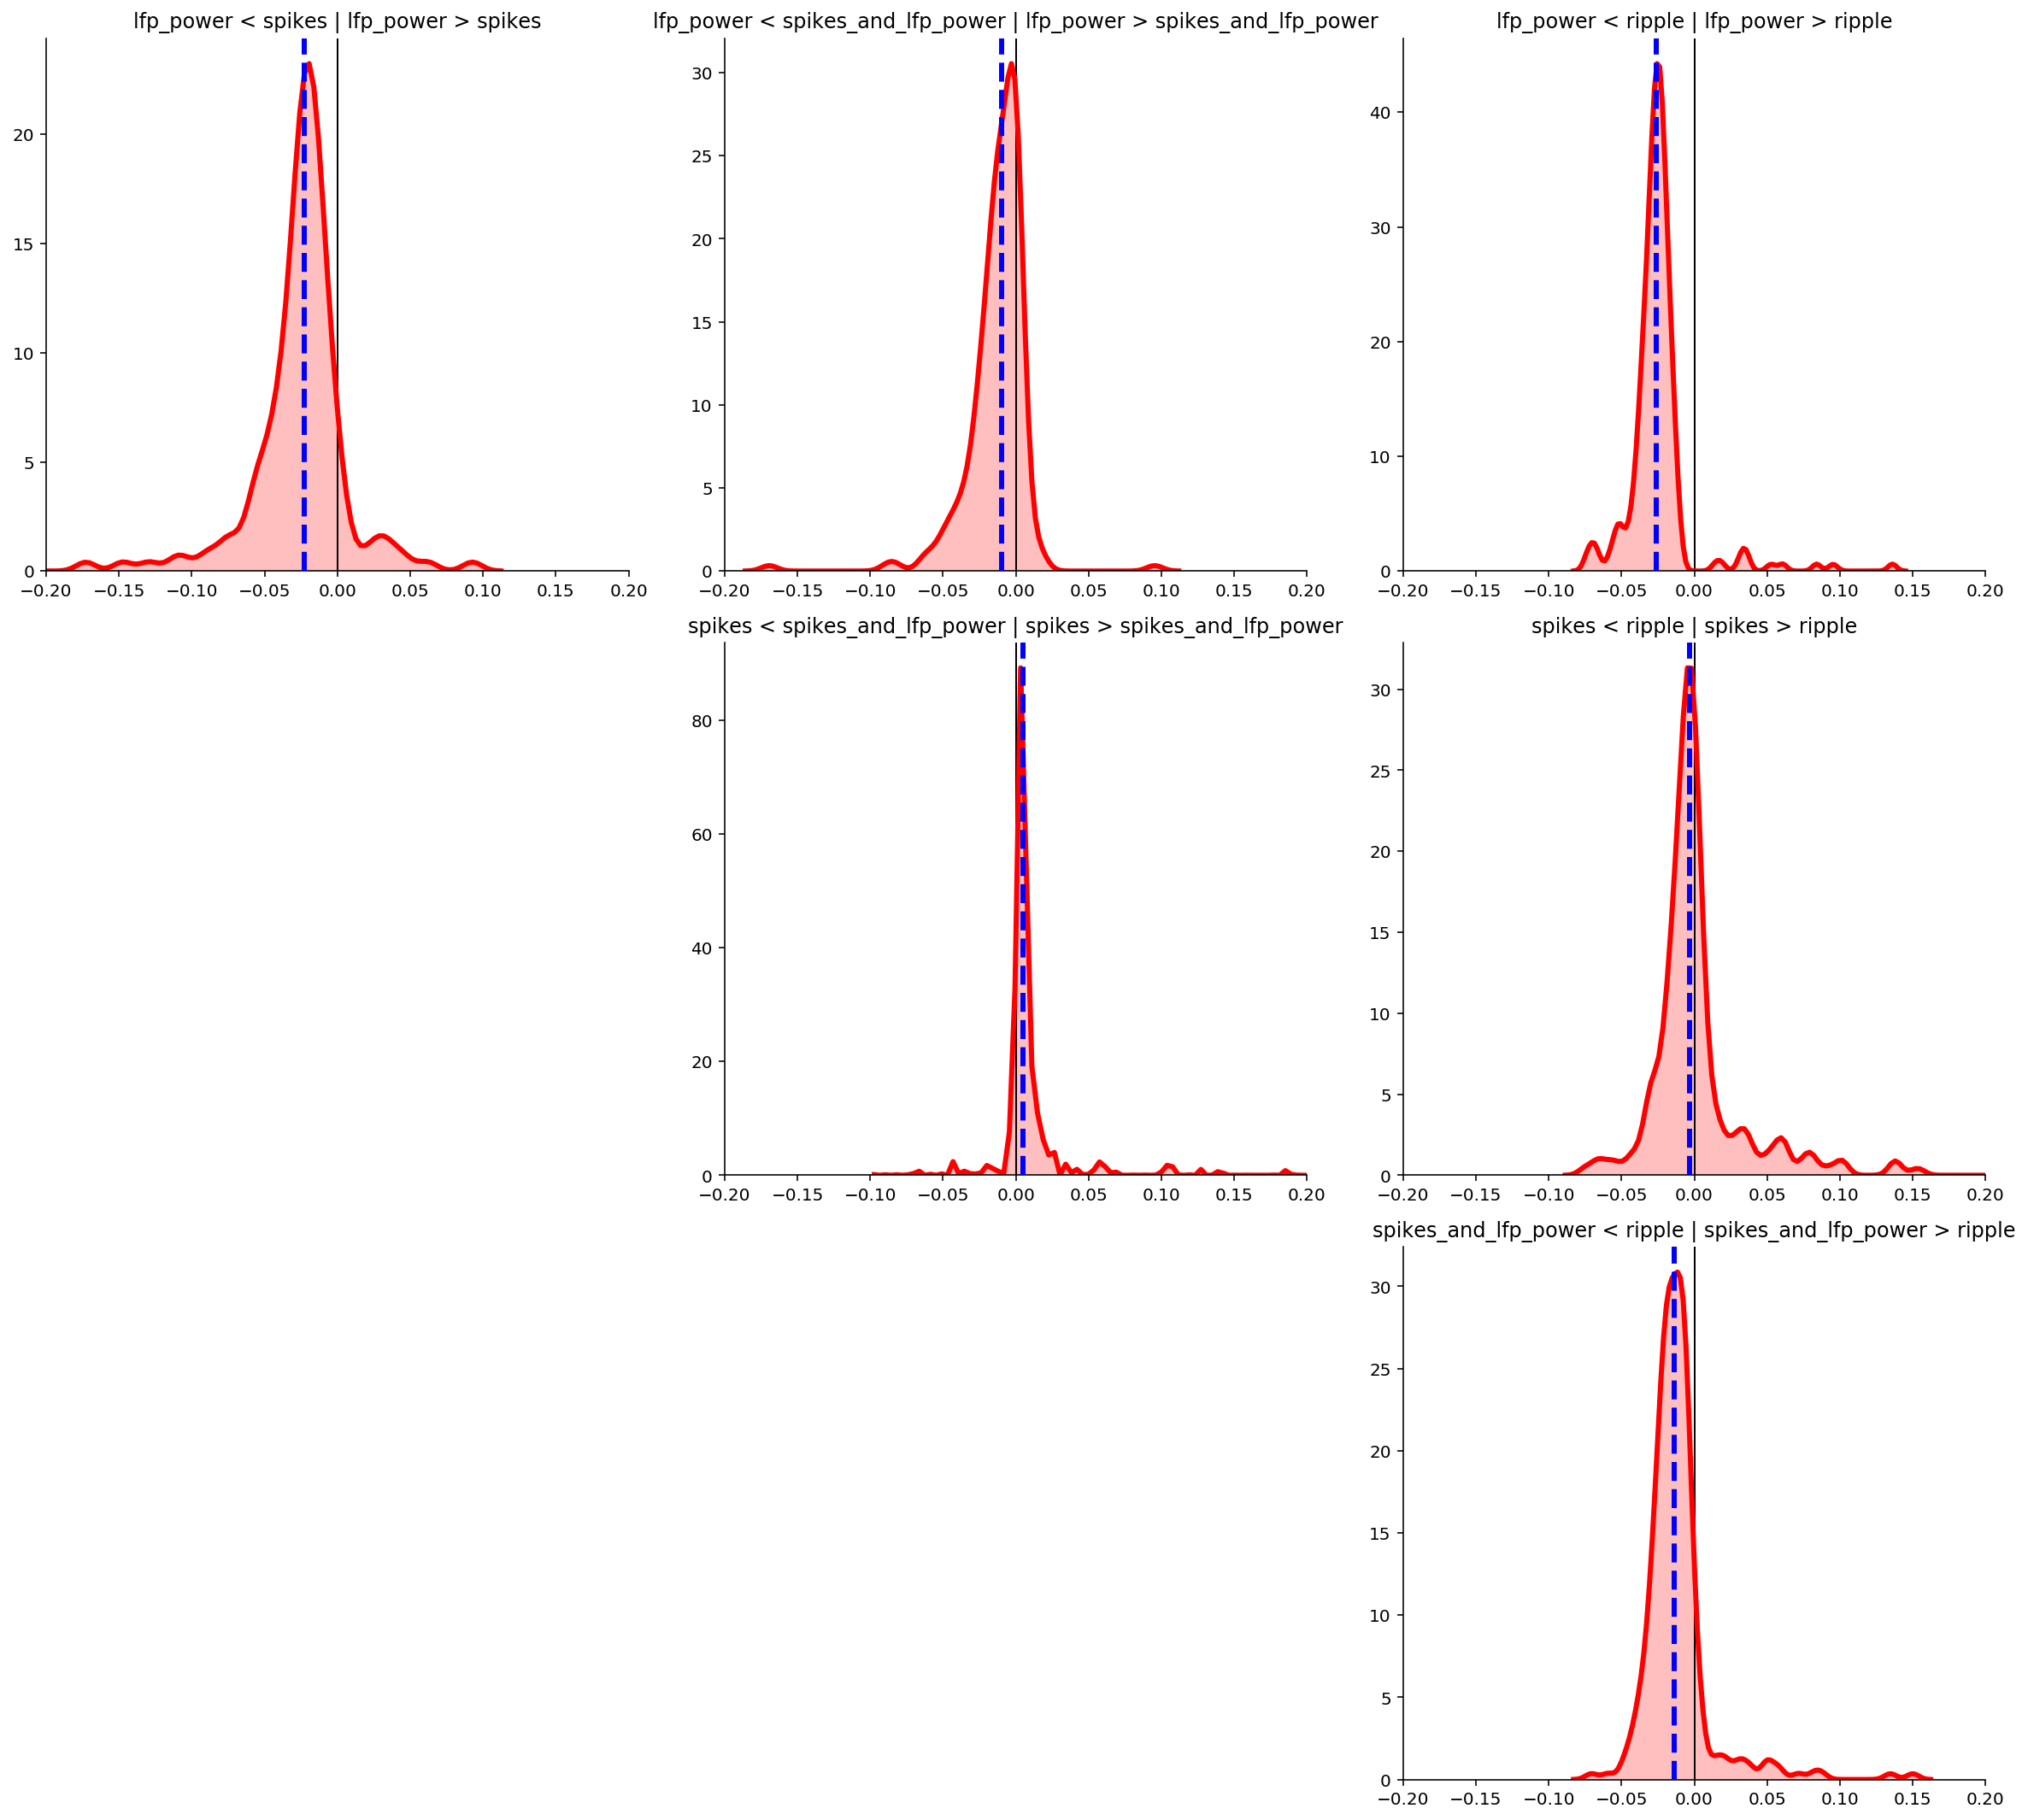

In [67]:
import seaborn as sns

def vertical_mean_line(x, **kwargs):
    plt.axvline(x.median(), **kwargs)


time_difference = 'end_time_difference'

g = sns.FacetGrid(data=overlap_info,  row='data_source1',
                  col='data_source2', height=5, aspect=1.1,
                  row_order=USE_LIKELIHOODS.keys(),
                  col_order=USE_LIKELIHOODS.keys(), sharey=False, sharex=False)
kde_kws = {'color': 'red', 'lw': 3, 'shade': True}
g.map(plt.axvline, x=0, color='k', linewidth=1, zorder=1)
    
g.map(vertical_mean_line, time_difference,
      color='blue', linewidth=3, zorder=100, linestyle='--')
g.map(sns.kdeplot, time_difference, **kde_kws
      ).set_titles('{row_name} < {col_name} | {row_name} > {col_name}', size=12)
g.set(xlim=(-0.2, 0.2))


for i, j in zip(*np.tril_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
